In [22]:
import csv

import random
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [23]:
df = pd.read_csv('/srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/train50k_processed.csv', header=None)
df.columns = ['image_path', 'time', 'speed']
print("Data Loaded Successfully...")
print(f"Dataset Size: {len(df)}")
print(df.head())

Data Loaded Successfully...
Dataset Size: 50000
                                          image_path      time     speed
0  /srv/beegfs02/scratch/aegis_guardian/data/data...  0.083333  0.499493
1  /srv/beegfs02/scratch/aegis_guardian/data/data...  0.166667  0.500541
2  /srv/beegfs02/scratch/aegis_guardian/data/data...  0.250000  0.501369
3  /srv/beegfs02/scratch/aegis_guardian/data/data...  0.333333  0.502367
4  /srv/beegfs02/scratch/aegis_guardian/data/data...  0.416667  0.503638


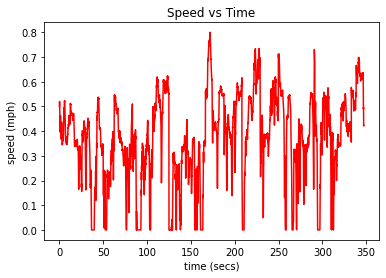

In [24]:
video_fps = 12
times = np.asarray(df['time'], dtype = np.float32) / video_fps
speeds = np.asarray(df['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.xlabel('time (secs)')
plt.ylabel('speed (mph)')
plt.savefig('Ground_Truth_Speed_vs_Time.jpg')

In [25]:
np.random.seed(143)

def batch_shuffle(dframe):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    randomized_list = np.arange(len(dframe)-1)
    np.random.shuffle(randomized_list)
    
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for i in randomized_list:
        idx1 = i
        idx2 = i + 1
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(10)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt == 2:
            test_frames = [test_data, row1, row2]
            test_data = pd.concat(test_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt > 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data, test_data


In [26]:
# create training and validation set
train_data, valid_data, test_data = batch_shuffle(df)

In [40]:
valid_data.reset_index().head(20)

level_0  index                                         image_path  \
0         0  40266  /srv/beegfs02/scratch/aegis_guardian/data/data...   
1         0  40267  /srv/beegfs02/scratch/aegis_guardian/data/data...   
2         0  35346  /srv/beegfs02/scratch/aegis_guardian/data/data...   
3         0  35347  /srv/beegfs02/scratch/aegis_guardian/data/data...   
4         0  10283  /srv/beegfs02/scratch/aegis_guardian/data/data...   
5         0  10284  /srv/beegfs02/scratch/aegis_guardian/data/data...   
6         0   7900  /srv/beegfs02/scratch/aegis_guardian/data/data...   
7         0   7901  /srv/beegfs02/scratch/aegis_guardian/data/data...   
8         0  32079  /srv/beegfs02/scratch/aegis_guardian/data/data...   
9         0  32080  /srv/beegfs02/scratch/aegis_guardian/data/data...   
10        0  43192  /srv/beegfs02/scratch/aegis_guardian/data/data...   
11        0  43193  /srv/beegfs02/scratch/aegis_guardian/data/data...   
12        0    798  /srv/beegfs02/scratch/aegis_guardian/data/data...   
13        0    799  /srv/beegfs02/scratch/aegis_guardian/data/data...   
14        0  45171  /srv/beegfs02/scratch/aegis_guardian/data/data...   
15        0  45172  /srv/beegfs02/scratch/aegis_guardian/data/data...   
16        0  48540  /srv/beegfs02/scratch/aegis_guardian/data/data...   
17        0  48541  /srv/beegfs02/scratch/aegis_guardian/data/data...   
18        0  29650  /srv/beegfs02/scratch/aegis_guardian/data/data...   
19        0  29651  /srv/beegfs02/scratch/aegis_guardian/data/data...   

           time     speed  
0   3355.583333  0.292385  
1   3355.666667  0.291508  
2   2945.583333  0.464362  
3   2945.666667  0.467332  
4    857.000000  0.347915  
5    857.083333  0.346328  
6    658.416667  0.241855  
7    658.500000  0.242422  
8   2673.333333  0.697761  
9   2673.416667  0.698432  
10  3599.416667  0.412341  
11  3599.500000  0.413535  
12    66.583333  0.508057  
13    66.666667  0.508823  
14  3764.333333  0.269644  
15  3764.416667  0.277087  
16  4045.083333  0.485768  
17  4045.166667  0.486417  
18  2470.916667  0.556657  
19  2471.000000  0.556467

In [53]:
valid_data.iloc[1636]['image_path']

'/srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1501.833333333085.jpg'

In [27]:
# save to csv
train_data.to_csv('train.csv')
valid_data.to_csv('valid_data.csv')
test_data.to_csv('test_data.csv')

# verify data size
print('Training data size =', train_data.shape)
print('Validation data size =', valid_data.shape)
print('Test data size =', test_data.shape)

Training data size = (69762, 4)
Validation data size = (20214, 4)
Test data size = (10022, 4)


In [110]:
def change_brightness(image, bright_factor):
    """augment brightness"""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return image_rgb


def transform(image, bright_factor):
    """augment brightness, crop/resize"""
    image = change_brightness(image, bright_factor)
    image = cv2.resize(image[100:440, :-90], (220, 66), interpolation = cv2.INTER_AREA)
    return image

# def opticalFlowDense(prev_frame, curr_frame, bright_factor):
#     prev_frame, curr_frame = transform(prev_frame, bright_factor), transform(curr_frame, bright_factor)
#     prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
#     curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
#     hsv = np.zeros_like(prev_frame)
#     hsv[:,:,1] = 255
#     flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray,
#                                         None, 0.5, 1, 15, 2, 5, 1.3, 0)
#     mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
#     hsv[:,:,0] = ang * (180/ np.pi / 2)
#     hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
#     rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
#     return rgb_flow




def crop_image(image, scale):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (66, 220, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (66, 220, 3) if not done so already from perspective transform
    """
    # Crop out sky (top 130px) and the hood of the car (bottom 270px) 
    image_cropped = image[130:370,:] # -> (240, 640, 3)
    
    height = int(240*scale)
    width = int(640*scale)
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

def preprocess_image_valid_from_path(image_path, scale_factor=0.5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image(img, scale_factor)
    return img

def preprocess_image_from_path(image_path, scale_factor=0.5, bright_factor=1):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)
    img = crop_image(img, scale_factor)
    return img

In [83]:
def generate_training_data(data, batch_size = 16, scale_factor = 0.5):
    # sample an image from the data to compute image size
    img = preprocess_image_from_path(train_data.iloc[1]['image_path'],scale_factor)

    # create empty batches
    image_batch = np.zeros((batch_size, img.shape[0], img.shape[1], img.shape[2]))
    label_batch = np.zeros(batch_size)
    i=0
    
    while True:
        speed1 = data.iloc[i]['speed']
        speed2 = data.iloc[i+1]['speed']
        
        bright_factor = 0.2 + np.random.uniform()
        img1 = preprocess_image_from_path(data.iloc[i]['image_path'],scale_factor,bright_factor)
        img2 = preprocess_image_from_path(data.iloc[i+1]['image_path'],scale_factor,bright_factor)
        
        rgb_flow_diff = opticalFlowDense(img1, img2)
        avg_speed = np.mean([speed1,speed2])
        
        image_batch[(i//2)%batch_size] = rgb_flow_diff
        label_batch[(i//2)%batch_size] = avg_speed
        
        if not(((i//2)+1)%batch_size):
            yield image_batch, label_batch
        i+=2
        i=i%data.shape[0]

def generate_validation_data(data, batch_size = 16, scale_factor = 0.5):
    i=0
    while i < len(data):
        speed1 = data.iloc[i]['speed']
        speed2 = data.iloc[i+1]['speed']
    
        img1 = preprocess_image_valid_from_path(data.iloc[i]['image_path'],scale_factor)
        img2 = preprocess_image_valid_from_path(data.iloc[i+1]['image_path'],scale_factor)
        
        rgb_diff = opticalFlowDense(img1, img2, bright_factor)
        rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
        avg_speed = np.array([[np.mean([speed1,speed2])]])
        
        i1 = data.iloc[i]['image_path']
        i2 = data.iloc[i+1]['image_path']
#         print('------------------------------------------------------------------------------------------')
#         print(f'\nImage {i}: {i1}')
#         print(f'Image {i+1}: {i2}')
#         print(f'Image 1 processed: {np.average(img1)}')
#         print(f'Image 2 processed: {np.average(img2)}')
#         print(f'Optical flow avg: {np.average(rgb_diff)}')
#         print(f'Label: {avg_speed}')
#         print('------------------------------------------------------------------------------------------')
        
        if(i==1636):
            print('testing now')
            print(data.iloc[1636]['image_path'])
        i+=2
#         return rgb_diff, avg_speed

In [33]:
generate_validation_data(valid_data)

------------------------------------------------------------------------------------------

Image 0: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3355.5833333349665.jpg
Image 1: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3355.6666666683.jpg
Image 1 processed: 187.96154729109276
Image 2 processed: 191.83845270890725
Optical flow avg: -317.4491882324219
Label: [[0.29194617]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2945.5833333342207.jpg
Image 3: /srv/beegfs02/scratch/aegis_guardian/data/datasets/fi

------------------------------------------------------------------------------------------

Image 28: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2626.2500000003065.jpg
Image 29: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2626.33333333364.jpg
Image 1 processed: 172.16696510560146
Image 2 processed: 172.22199265381084
Optical flow avg: -240.59095764160156
Label: [[0.50942328]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 30: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1630.1666666663016.jpg
Image 31: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 56: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/392.7499999999805.jpg
Image 57: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/392.8333333333138.jpg
Image 1 processed: 123.0709595959596
Image 2 processed: 128.01214416896235
Optical flow avg: -4859.59326171875
Label: [[0.43130249]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 58: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1207.083333333353.jpg
Image 59: /srv/beegfs02/scratch/aegis_guardian/data/datasets/

------------------------------------------------------------------------------------------

Image 84: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/606.9166666666632.jpg
Image 85: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/606.9999999999966.jpg
Image 1 processed: 134.98689164370984
Image 2 processed: 135.5668044077135
Optical flow avg: -1348.4727783203125
Label: [[0.22836822]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 86: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3538.500000001966.jpg
Image 87: /srv/beegfs02/scratch/aegis_guardian/data/dataset

------------------------------------------------------------------------------------------

Image 112: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1241.0833333333221.jpg
Image 113: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1241.1666666666554.jpg
Image 1 processed: 123.1416207529844
Image 2 processed: 140.46866391184574
Optical flow avg: -1197.5096435546875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 114: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3895.5833333359487.jpg
Image 115: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 140: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3312.916666668222.jpg
Image 141: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3313.0000000015557.jpg
Image 1 processed: 190.12722681359045
Image 2 processed: 195.25162993572084
Optical flow avg: -643.1239624023438
Label: [[0.42344384]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1399.4166666665114.jpg
Image 143: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 166: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3135.6666666679.jpg
Image 167: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3135.7500000012333.jpg
Image 1 processed: 82.39791092745638
Image 2 processed: 84.61682736455464
Optical flow avg: -2489.939697265625
Label: [[0.53648045]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 168: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2847.0833333340415.jpg
Image 169: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/844.6666666667713.jpg
Image 193: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/844.7500000001047.jpg
Image 1 processed: 149.64586776859505
Image 2 processed: 130.28220844811753
Optical flow avg: -1458.0716552734375
Label: [[0.35273143]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 194: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3539.1666666686338.jpg
Image 195: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1197.5833333333617.jpg
Image 221: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1197.666666666695.jpg
Image 1 processed: 152.49566115702478
Image 2 processed: 155.2055785123967
Optical flow avg: -1519.83349609375
Label: [[0.36849075]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 222: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2323.916666666423.jpg
Image 223: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/693.5833333333693.jpg
Image 247: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/693.6666666667027.jpg
Image 1 processed: 124.20817263544537
Image 2 processed: 124.09529384756658
Optical flow avg: -2471.080322265625
Label: [[0.23473177]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 248: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1963.8333333326648.jpg
Image 249: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3541.1666666686374.jpg
Image 277: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3541.250000001971.jpg
Image 1 processed: 172.69722222222222
Image 2 processed: 172.20286960514233
Optical flow avg: -406.54986572265625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 278: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2814.166666667315.jpg
Image 279: /srv/beegfs02/scratch/aegis_guardian/data/datasets/

------------------------------------------------------------------------------------------

Image 302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1552.1666666663725.jpg
Image 303: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1552.2499999997058.jpg
Image 1 processed: 168.9533287419651
Image 2 processed: 170.8660927456382
Optical flow avg: -832.8731079101562
Label: [[0.1565317]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 304: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2449.999999999986.jpg
Image 305: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 328: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3586.7500000020536.jpg
Image 329: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3586.833333335387.jpg
Image 1 processed: 173.42385215794306
Image 2 processed: 174.12644628099173
Optical flow avg: -334.42529296875
Label: [[0.40401126]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2998.083333334316.jpg
Image 331: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 354: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/905.0833333334655.jpg
Image 355: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/905.1666666667988.jpg
Image 1 processed: 111.5863406795225
Image 2 processed: 112.51476124885215
Optical flow avg: -1253.043212890625
Label: [[0.29711697]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 356: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/857.7500000001106.jpg
Image 357: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 380: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/930.333333333477.jpg
Image 381: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/930.4166666668103.jpg
Image 1 processed: 176.3355142332415
Image 2 processed: 175.48627180899908
Optical flow avg: -441.9311218261719
Label: [[0.32807368]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 382: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2501.416666666746.jpg
Image 383: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 410: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3039.833333334392.jpg
Image 411: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3039.9166666677256.jpg
Image 1 processed: 122.71542699724517
Image 2 processed: 123.20626721763085
Optical flow avg: -909.5894165039062
Label: [[0.54689302]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 412: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2508.9166666667597.jpg
Image 413: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 438: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1597.916666666331.jpg
Image 439: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1597.9999999996642.jpg
Image 1 processed: 183.60798898071624
Image 2 processed: 182.9668732782369
Optical flow avg: -560.2025756835938
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 440: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3712.8333333356163.jpg
Image 441: /srv/beegfs02/scratch/aegis_guardian/data/datasets/f

Optical flow avg: -1489.1248779296875
Label: [[0.53929579]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/533.7499999999633.jpg
Image 465: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/533.8333333332967.jpg
Image 1 processed: 130.23590449954085
Image 2 processed: 130.9002295684114
Optical flow avg: -2262.545654296875
Label: [[0.53364645]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 466: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Ha

------------------------------------------------------------------------------------------

Image 490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/107.16666666666494.jpg
Image 491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/107.24999999999827.jpg
Image 1 processed: 172.56324609733701
Image 2 processed: 172.40247933884297
Optical flow avg: -899.8593139648438
Label: [[0.34896014]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1959.8333333326684.jpg
Image 493: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/579.8333333333176.jpg
Image 521: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/579.9166666666509.jpg
Image 1 processed: 134.07235996326907
Image 2 processed: 117.21487603305785
Optical flow avg: -1383.7021484375
Label: [[0.31055518]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 522: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2330.1666666664346.jpg
Image 523: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 548: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2151.333333332776.jpg
Image 549: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2151.4166666661094.jpg
Image 1 processed: 196.12160238751147
Image 2 processed: 195.90757575757576
Optical flow avg: -280.14483642578125
Label: [[0.39860253]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 550: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3710.166666668945.jpg
Image 551: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3506.750000001908.jpg
Image 575: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3506.8333333352416.jpg
Image 1 processed: 180.50876951331497
Image 2 processed: 177.73833792470157
Optical flow avg: -1330.0235595703125
Label: [[0.51092227]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 576: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/268.0833333333422.jpg
Image 577: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1782.416666666163.jpg
Image 603: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1782.4999999994964.jpg
Image 1 processed: 197.70096418732783
Image 2 processed: 197.11492194674014
Optical flow avg: -292.97052001953125
Label: [[0.26210263]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 604: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/558.3333333333078.jpg
Image 605: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1833.0833333327837.jpg
Image 629: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1833.166666666117.jpg
Image 1 processed: 180.8120523415978
Image 2 processed: 179.81602387511478
Optical flow avg: -1356.378173828125
Label: [[0.36108186]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 630: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3627.916666668795.jpg
Image 631: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1465.6666666664512.jpg
Image 657: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1465.7499999997844.jpg
Image 1 processed: 155.53969237832874
Image 2 processed: 158.56602387511478
Optical flow avg: -1382.001708984375
Label: [[0.5639104]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 658: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1434.4166666664796.jpg
Image 659: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/878.9166666667869.jpg
Image 685: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/879.0000000001203.jpg
Image 1 processed: 121.78197887970616
Image 2 processed: 122.43041781450873
Optical flow avg: -376.9626159667969
Label: [[0.25978664]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 686: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1499.4166666664205.jpg
Image 687: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 712: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2584.25000000023.jpg
Image 713: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2584.3333333335636.jpg
Image 1 processed: 147.79807162534436
Image 2 processed: 145.9627640036731
Optical flow avg: -806.2789916992188
Label: [[0.44479574]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 714: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3460.9166666684914.jpg
Image 715: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 740: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3179.7500000013133.jpg
Image 741: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3179.833333334647.jpg
Image 1 processed: 121.17470156106519
Image 2 processed: 121.31338383838384
Optical flow avg: -2556.258544921875
Label: [[0.21430611]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 742: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3541.750000001972.jpg
Image 743: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 768: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2746.9166666671927.jpg
Image 769: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2747.000000000526.jpg
Image 1 processed: 196.53831496786043
Image 2 processed: 195.2159090909091
Optical flow avg: -131.54563903808594
Label: [[0.69377078]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 770: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1853.0833333327655.jpg
Image 771: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 794: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3440.3333333351206.jpg
Image 795: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3440.416666668454.jpg
Image 1 processed: 151.00224977043158
Image 2 processed: 152.5959136822773
Optical flow avg: -791.5873413085938
Label: [[0.53913811]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 796: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1371.4999999998702.jpg
Image 797: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1832.5833333327842.jpg
Image 821: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1832.6666666661174.jpg
Image 1 processed: 134.9390266299357
Image 2 processed: 183.3424471992654
Optical flow avg: -636.5585327148438
Label: [[0.36111772]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 822: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1942.249999999351.jpg
Image 823: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3413.250000001738.jpg
Image 847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3413.3333333350715.jpg
Image 1 processed: 143.80665748393022
Image 2 processed: 140.72050045913682
Optical flow avg: -1542.322509765625
Label: [[0.36903136]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/936.2500000001463.jpg
Image 849: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 874: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1479.3333333331054.jpg
Image 875: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1479.4166666664387.jpg
Image 1 processed: 214.5477272727273
Image 2 processed: 216.764072543618
Optical flow avg: -20.861984252929688
Label: [[0.62279883]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4015.6666666695005.jpg
Image 877: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 900: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/655.2500000000185.jpg
Image 901: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/655.3333333333519.jpg
Image 1 processed: 130.54779614325068
Image 2 processed: 130.3109963269054
Optical flow avg: -660.1484985351562
Label: [[0.21283154]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 902: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1445.4166666664696.jpg
Image 903: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/959.0000000001567.jpg
Image 931: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/959.08333333349.jpg
Image 1 processed: 131.61099632690542
Image 2 processed: 131.30624426078973
Optical flow avg: -1271.1773681640625
Label: [[0.27706442]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3867.250000002564.jpg
Image 933: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 958: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2628.083333333643.jpg
Image 959: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2628.1666666669767.jpg
Image 1 processed: 172.02667584940312
Image 2 processed: 172.01666666666668
Optical flow avg: -150.3617401123047
Label: [[0.48986666]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 960: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2953.000000000901.jpg
Image 961: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 986: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2411.166666666582.jpg
Image 987: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2411.2499999999154.jpg
Image 1 processed: 188.50238751147842
Image 2 processed: 188.43588154269972
Optical flow avg: -92.11392974853516
Label: [[0.3911826]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 988: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1422.3333333331573.jpg
Image 989: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 1014: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1803.9166666661436.jpg
Image 1015: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1803.9999999994768.jpg
Image 1 processed: 139.2621212121212
Image 2 processed: 185.88457300275482
Optical flow avg: -460.33746337890625
Label: [[0.28047695]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1016: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2809.0833333339724.jpg
Image 1017: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 1040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/903.5000000001314.jpg
Image 1041: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/903.5833333334648.jpg
Image 1 processed: 98.72001836547291
Image 2 processed: 99.55686409550046
Optical flow avg: -1488.9117431640625
Label: [[0.31989683]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1042: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/201.08333333333871.jpg
Image 1043: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1068: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2777.8333333339156.jpg
Image 1069: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2777.916666667249.jpg
Image 1 processed: 186.44915059687787
Image 2 processed: 110.99233241505969
Optical flow avg: -2734.910888671875
Label: [[0.4443398]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1070: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2453.999999999993.jpg
Image 1071: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1096: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2022.4166666659448.jpg
Image 1097: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2022.499999999278.jpg
Image 1 processed: 199.43096877869604
Image 2 processed: 113.7376492194674
Optical flow avg: -612.642578125
Label: [[0.53851914]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1098: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/475.9999999999616.jpg
Image 1099: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 1124: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/210.0000000000064.jpg
Image 1125: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/210.08333333333974.jpg
Image 1 processed: 105.24104683195593
Image 2 processed: 103.09781910009183
Optical flow avg: -516.2564086914062
Label: [[0.34021991]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1126: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3248.083333334771.jpg
Image 1127: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 1152: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1521.1666666664007.jpg
Image 1153: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1521.249999999734.jpg
Image 1 processed: 167.55915977961433
Image 2 processed: 166.96237373737372
Optical flow avg: -388.1004943847656
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1154: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/103.08333333333184.jpg
Image 1155: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 1180: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.1666666667456.jpg
Image 1181: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.250000000079.jpg
Image 1 processed: 137.46611570247933
Image 2 processed: 128.14467401285583
Optical flow avg: -1645.56494140625
Label: [[0.47772513]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1182: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3911.1666666693104.jpg
Image 1183: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 1208: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4067.333333336261.jpg
Image 1209: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4067.4166666695946.jpg
Image 1 processed: 123.93151974288338
Image 2 processed: 123.27330119375574
Optical flow avg: -2130.90478515625
Label: [[0.63693157]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1210: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2293.999999999702.jpg
Image 1211: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1236: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/42.666666666666785.jpg
Image 1237: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/42.75000000000012.jpg
Image 1 processed: 110.5209595959596
Image 2 processed: 111.42594123048669
Optical flow avg: -2630.115966796875
Label: [[0.36088496]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1238: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1527.4999999997283.jpg
Image 1239: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 1262: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/348.41666666665725.jpg
Image 1263: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/348.49999999999056.jpg
Image 1 processed: 125.03395316804408
Image 2 processed: 106.2227502295684
Optical flow avg: -1668.7188720703125
Label: [[0.40167804]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1264: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1352.1666666665544.jpg
Image 1265: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 1290: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1186.8333333333715.jpg
Image 1291: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1186.9166666667047.jpg
Image 1 processed: 189.04286042240588
Image 2 processed: 190.13746556473828
Optical flow avg: -566.8189086914062
Label: [[0.31732475]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1292: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2767.750000000564.jpg
Image 1293: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 1318: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/444.4166666666354.jpg
Image 1319: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/444.49999999996874.jpg
Image 1 processed: 114.94639577594123
Image 2 processed: 114.94432966023875
Optical flow avg: -1303.650634765625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1320: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/669.8333333333585.jpg
Image 1321: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 1344: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1524.499999999731.jpg
Image 1345: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1524.5833333330643.jpg
Image 1 processed: 198.3142561983471
Image 2 processed: 198.07334710743802
Optical flow avg: -71.28104400634766
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1346: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1480.9999999997706.jpg
Image 1347: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 1372: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2857.0833333340597.jpg
Image 1373: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2857.166666667393.jpg
Image 1 processed: 182.4739898989899
Image 2 processed: 182.50027548209366
Optical flow avg: -90.22673797607422
Label: [[0.34058515]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1913.9166666660435.jpg
Image 1375: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 1398: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3891.833333335942.jpg
Image 1399: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3891.9166666692754.jpg
Image 1 processed: 174.05335169880624
Image 2 processed: 110.54104683195592
Optical flow avg: -2398.9189453125
Label: [[0.50773251]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1400: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2773.8333333339083.jpg
Image 1401: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1424: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2973.666666667605.jpg
Image 1425: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2973.7500000009386.jpg
Image 1 processed: 154.86533516988064
Image 2 processed: 153.8732093663912
Optical flow avg: -1233.9027099609375
Label: [[0.51766035]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1426: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/605.2499999999958.jpg
Image 1427: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 1452: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4012.5833333361616.jpg
Image 1453: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4012.666666669495.jpg
Image 1 processed: 205.521854912764
Image 2 processed: 204.68321854912764
Optical flow avg: -75.28341674804688
Label: [[0.54864032]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1454: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1859.1666666660933.jpg
Image 1455: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1480: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3207.7500000013642.jpg
Image 1481: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3207.8333333346977.jpg
Image 1 processed: 73.38275941230486
Image 2 processed: 73.89327364554637
Optical flow avg: -2812.94775390625
Label: [[0.1920175]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1482: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1716.5833333328897.jpg
Image 1483: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 1506: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2782.0833333339233.jpg
Image 1507: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2782.166666667257.jpg
Image 1 processed: 155.48089990817263
Image 2 processed: 157.36825068870525
Optical flow avg: -761.724365234375
Label: [[0.3316518]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1508: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3606.1666666687556.jpg
Image 1509: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1534: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/524.8333333332926.jpg
Image 1535: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/524.9166666666259.jpg
Image 1 processed: 133.82961432506886
Image 2 processed: 131.02924701561065
Optical flow avg: -3131.24853515625
Label: [[0.52417203]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1536: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/742.5000000000582.jpg
Image 1537: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 1562: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2508.416666666759.jpg
Image 1563: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2508.5000000000923.jpg
Image 1 processed: 156.08918732782368
Image 2 processed: 156.76129476584023
Optical flow avg: -741.5029296875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1564: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2628.416666666977.jpg
Image 1565: /srv/beegfs02/scratch/aegis_guardian/data/datasets/

------------------------------------------------------------------------------------------

Image 1588: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3801.6666666691112.jpg
Image 1589: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3801.7500000024447.jpg
Image 1 processed: 137.71049127640038
Image 2 processed: 135.12235996326905
Optical flow avg: -1660.70703125
Label: [[0.31408555]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1590: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1284.416666666616.jpg
Image 1591: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 1616: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1026.5833333335172.jpg
Image 1617: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1026.6666666668505.jpg
Image 1 processed: 159.9361570247934
Image 2 processed: 162.2560606060606
Optical flow avg: -2090.103271484375
Label: [[0.37994214]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1618: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2302.416666666384.jpg
Image 1619: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1642: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/505.0833333332883.jpg
Image 1643: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/505.1666666666216.jpg
Image 1 processed: 109.45162993572085
Image 2 processed: 109.31058310376493
Optical flow avg: -3517.47998046875
Label: [[0.16908838]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1644: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4068.000000002929.jpg
Image 1645: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 1668: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/300.5000000000015.jpg
Image 1669: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/300.5833333333348.jpg
Image 1 processed: 123.3980945821855
Image 2 processed: 123.40126262626262
Optical flow avg: -161.24972534179688
Label: [[0.20559674]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1670: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2208.4999999995466.jpg
Image 1671: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 1694: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2403.9166666665687.jpg
Image 1695: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2403.9999999999022.jpg
Image 1 processed: 135.4797520661157
Image 2 processed: 120.88482552800734
Optical flow avg: -996.70263671875
Label: [[0.24254319]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1696: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/574.999999999982.jpg
Image 1697: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 1722: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1427.416666666486.jpg
Image 1723: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1427.4999999998192.jpg
Image 1 processed: 152.4464416896235
Image 2 processed: 159.95647382920112
Optical flow avg: -2100.748291015625
Label: [[0.6038138]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1724: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/157.58333333333377.jpg
Image 1725: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1752: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3764.7500000023774.jpg
Image 1753: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3764.833333335711.jpg
Image 1 processed: 124.8209595959596
Image 2 processed: 124.81430211202938
Optical flow avg: -488.5916748046875
Label: [[0.28624955]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1754: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3170.416666667963.jpg
Image 1755: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1780: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/338.9999999999927.jpg
Image 1781: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/339.08333333332604.jpg
Image 1 processed: 83.32332415059687
Image 2 processed: 75.63780991735537
Optical flow avg: -2683.870849609375
Label: [[0.43206711]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1782: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1674.7499999995944.jpg
Image 1783: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1808: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2399.7499999998945.jpg
Image 1809: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2399.833333333228.jpg
Image 1 processed: 113.56078971533518
Image 2 processed: 113.6182277318641
Optical flow avg: -584.9072265625
Label: [[0.38170256]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1810: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2782.8333333339247.jpg
Image 1811: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 1836: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/26.41666666666656.jpg
Image 1837: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/26.499999999999893.jpg
Image 1 processed: 136.6331496786042
Image 2 processed: 139.88168044077136
Optical flow avg: -786.5228881835938
Label: [[0.40193972]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1838: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/174.91666666666907.jpg
Image 1839: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 1862: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/408.3333333333103.jpg
Image 1863: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/408.4166666666436.jpg
Image 1 processed: 172.5940541781451
Image 2 processed: 172.62270431588612
Optical flow avg: -236.7685089111328
Label: [[0.39661873]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1864: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1786.8333333328258.jpg
Image 1865: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 1890: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/252.91666666667794.jpg
Image 1891: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/253.00000000001128.jpg
Image 1 processed: 123.77747933884298
Image 2 processed: 123.63578971533516
Optical flow avg: -1284.305908203125
Label: [[0.32726828]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1892: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2510.0833333334285.jpg
Image 1893: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 1918: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/632.7500000000083.jpg
Image 1919: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/632.8333333333417.jpg
Image 1 processed: 133.15881542699725
Image 2 processed: 132.62924701561064
Optical flow avg: -2212.085693359375
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1920: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/512.3333333332869.jpg
Image 1921: /srv/beegfs02/scratch/aegis_guardian/data/dataset

------------------------------------------------------------------------------------------

Image 1946: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3451.8333333351416.jpg
Image 1947: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3451.916666668475.jpg
Image 1 processed: 113.7179292929293
Image 2 processed: 115.48973829201103
Optical flow avg: -1312.85986328125
Label: [[0.5410165]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1948: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2409.833333333246.jpg
Image 1949: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 1972: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1069.583333333478.jpg
Image 1973: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1069.6666666668114.jpg
Image 1 processed: 112.9856290174472
Image 2 processed: 112.37304866850322
Optical flow avg: -3023.514404296875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1974: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2639.5000000003306.jpg
Image 1975: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 1998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1715.6666666662238.jpg
Image 1999: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1715.749999999557.jpg
Image 1 processed: 161.09804866850322
Image 2 processed: 157.13216253443525
Optical flow avg: -1700.8074951171875
Label: [[0.3618537]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2000: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1807.0833333328073.jpg
Image 2001: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3200.00000000135.jpg
Image 2025: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3200.0833333346836.jpg
Image 1 processed: 99.88363177226813
Image 2 processed: 99.8752984389348
Optical flow avg: -1228.3443603515625
Label: [[0.01348049]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2026: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2563.5000000001924.jpg
Image 2027: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 2052: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3187.416666667994.jpg
Image 2053: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3187.5000000013274.jpg
Image 1 processed: 103.53526170798898
Image 2 processed: 103.02860422405877
Optical flow avg: -2462.936279296875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2054: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1114.3333333334374.jpg
Image 2055: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 2080: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2714.5833333338005.jpg
Image 2081: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2714.666666667134.jpg
Image 1 processed: 180.54414600550965
Image 2 processed: 180.54499540863176
Optical flow avg: -598.2387084960938
Label: [[0.68445833]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2082: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2568.1666666668675.jpg
Image 2083: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2106: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3696.5000000022533.jpg
Image 2107: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3696.5833333355868.jpg
Image 1 processed: 133.719536271809
Image 2 processed: 166.1387741046832
Optical flow avg: -399.3388977050781
Label: [[0.44594411]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2108: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2809.2500000006394.jpg
Image 2109: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 2134: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3468.416666668505.jpg
Image 2135: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3468.5000000018385.jpg
Image 1 processed: 112.66802112029384
Image 2 processed: 113.0956611570248
Optical flow avg: -2144.877197265625
Label: [[0.48441212]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2618.91666666696.jpg
Image 2137: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 2164: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/161.50000000000088.jpg
Image 2165: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/161.58333333333422.jpg
Image 1 processed: 132.92027089072545
Image 2 processed: 133.34171258034894
Optical flow avg: -827.58447265625
Label: [[0.47884508]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2166: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/36.74999999999995.jpg
Image 2167: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 2190: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1724.2499999995493.jpg
Image 2191: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1724.3333333328826.jpg
Image 1 processed: 157.34373278236916
Image 2 processed: 132.26189164370982
Optical flow avg: -1442.334228515625
Label: [[0.33817615]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3082.750000001137.jpg
Image 2193: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2216: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3036.2500000010523.jpg
Image 2217: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3036.3333333343858.jpg
Image 1 processed: 87.64393939393939
Image 2 processed: 145.92926997245178
Optical flow avg: -1872.531005859375
Label: [[0.54399447]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2218: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/718.0000000000471.jpg
Image 2219: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 2244: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1151.5000000000703.jpg
Image 2245: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1151.5833333334035.jpg
Image 1 processed: 147.29552341597795
Image 2 processed: 143.18953168044078
Optical flow avg: -4901.25
Label: [[0.29850684]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2872.083333334087.jpg
Image 2247: /srv/beegfs02/scratch/aegis_guardian/data/dataset

------------------------------------------------------------------------------------------

Image 2272: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3807.0833333357878.jpg
Image 2273: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3807.1666666691212.jpg
Image 1 processed: 143.46524334251606
Image 2 processed: 142.66854912764003
Optical flow avg: -3061.0703125
Label: [[0.36595117]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/322.91666666666305.jpg
Image 2275: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 2300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1996.4999999993017.jpg
Image 2301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1996.583333332635.jpg
Image 1 processed: 161.27669880624427
Image 2 processed: 128.05893021120295
Optical flow avg: -728.8327026367188
Label: [[0.35053235]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2817.916666667322.jpg
Image 2303: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 2326: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2284.333333333018.jpg
Image 2327: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2284.4166666663514.jpg
Image 1 processed: 161.8904958677686
Image 2 processed: 164.59065656565656
Optical flow avg: -386.6895751953125
Label: [[0.40344286]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2328: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2161.0833333327937.jpg
Image 2329: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 2354: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/615.3333333333337.jpg
Image 2355: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/615.4166666666671.jpg
Image 1 processed: 136.2619834710744
Image 2 processed: 136.84814049586777
Optical flow avg: -1128.993408203125
Label: [[0.10402769]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2356: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1824.749999999458.jpg
Image 2357: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 2380: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.7500000000028.jpg
Image 2381: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.8333333333361.jpg
Image 1 processed: 118.83078512396695
Image 2 processed: 122.65252525252525
Optical flow avg: -1156.1748046875
Label: [[0.2506692]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2382: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/426.9166666666394.jpg
Image 2383: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 2408: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2177.083333332823.jpg
Image 2409: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2177.1666666661563.jpg
Image 1 processed: 186.71129476584022
Image 2 processed: 140.47979797979798
Optical flow avg: -1206.969482421875
Label: [[0.43537464]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2410: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1093.3333333334565.jpg
Image 2411: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2434: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2651.6666666670194.jpg
Image 2435: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2651.750000000353.jpg
Image 1 processed: 162.9385904499541
Image 2 processed: 164.8205004591368
Optical flow avg: -597.4209594726562
Label: [[0.51316891]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2436: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4052.166666669567.jpg
Image 2437: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 2462: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/150.74999999999966.jpg
Image 2463: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/150.833333333333.jpg
Image 1 processed: 129.11400367309457
Image 2 processed: 129.3836776859504
Optical flow avg: -992.4086303710938
Label: [[0.51076019]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2328.666666666432.jpg
Image 2465: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 2490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/505.41666666662155.jpg
Image 2491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/505.49999999995487.jpg
Image 1 processed: 111.41733241505969
Image 2 processed: 109.73333333333333
Optical flow avg: -3525.78076171875
Label: [[0.17380286]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2224.3333333329088.jpg
Image 2493: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2516: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4053.750000002903.jpg
Image 2517: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4053.8333333362366.jpg
Image 1 processed: 98.65413223140496
Image 2 processed: 103.87848943985307
Optical flow avg: -2420.3193359375
Label: [[0.49007005]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1760.7499999995161.jpg
Image 2519: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 2544: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3817.583333335807.jpg
Image 2545: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3817.6666666691403.jpg
Image 1 processed: 202.9907483930211
Image 2 processed: 204.90803489439853
Optical flow avg: -297.0428161621094
Label: [[0.33785935]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3924.000000002667.jpg
Image 2547: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 2572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3751.8333333356873.jpg
Image 2573: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3751.9166666690207.jpg
Image 1 processed: 124.79136822773187
Image 2 processed: 124.8057621671258
Optical flow avg: -348.3487854003906
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2010.9999999992885.jpg
Image 2575: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 2600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3798.5833333357723.jpg
Image 2601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3798.666666669106.jpg
Image 1 processed: 172.90787419651056
Image 2 processed: 170.0199954086318
Optical flow avg: -100.44783020019531
Label: [[0.27039029]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3846.83333333586.jpg
Image 2603: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 2626: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3956.1666666693923.jpg
Image 2627: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3956.2500000027258.jpg
Image 1 processed: 161.93145087235996
Image 2 processed: 161.8010789715335
Optical flow avg: -875.879150390625
Label: [[0.41755488]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2856.5000000007253.jpg
Image 2629: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 2652: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1765.249999999512.jpg
Image 2653: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1765.3333333328453.jpg
Image 1 processed: 190.92263544536272
Image 2 processed: 190.60693296602386
Optical flow avg: -222.88613891601562
Label: [[0.21433504]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2654: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3897.166666669285.jpg
Image 2655: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2680: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/312.49999999999875.jpg
Image 2681: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/312.58333333333206.jpg
Image 1 processed: 123.23918732782369
Image 2 processed: 123.18820018365473
Optical flow avg: -236.6521759033203
Label: [[0.38459618]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3484.8333333352016.jpg
Image 2683: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 2708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2191.583333332849.jpg
Image 2709: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2191.6666666661827.jpg
Image 1 processed: 199.58971533516987
Image 2 processed: 198.37876492194675
Optical flow avg: -336.9251708984375
Label: [[0.55853818]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1112.4166666667725.jpg
Image 2711: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2734: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.7500000000792.jpg
Image 2735: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.8333333334126.jpg
Image 1 processed: 144.08647842056934
Image 2 processed: 143.59141414141413
Optical flow avg: -1011.9213256835938
Label: [[0.47736569]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1879.2499999994084.jpg
Image 2737: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2762: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2747.0833333338596.jpg
Image 2763: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2747.166666667193.jpg
Image 1 processed: 193.37878787878788
Image 2 processed: 191.5837235996327
Optical flow avg: -197.4480438232422
Label: [[0.69496651]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3910.6666666693095.jpg
Image 2765: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 2788: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3203.5000000013565.jpg
Image 2789: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3203.58333333469.jpg
Image 1 processed: 79.77594123048668
Image 2 processed: 79.68119834710744
Optical flow avg: -1818.489990234375
Label: [[0.03492284]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2790: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3716.5000000022897.jpg
Image 2791: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 2814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2616.2500000002883.jpg
Image 2815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2616.333333333622.jpg
Image 1 processed: 172.47922405876952
Image 2 processed: 172.43163452708907
Optical flow avg: -158.0734405517578
Label: [[0.53528265]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2816: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/959.2500000001568.jpg
Image 2817: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 2842: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3469.750000001841.jpg
Image 2843: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3469.8333333351743.jpg
Image 1 processed: 85.43842975206611
Image 2 processed: 84.76485307621671
Optical flow avg: -756.8016967773438
Label: [[0.46574325]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2844: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3916.1666666693195.jpg
Image 2845: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 2870: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3535.8333333352944.jpg
Image 2871: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3535.916666668628.jpg
Image 1 processed: 196.36967401285582
Image 2 processed: 196.33799357208449
Optical flow avg: -317.7447509765625
Label: [[0.00065685]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2872: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1873.8333333327466.jpg
Image 2873: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 2896: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/425.58333333330637.jpg
Image 2897: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/425.6666666666397.jpg
Image 1 processed: 149.56136363636364
Image 2 processed: 149.9147153351699
Optical flow avg: -292.547119140625
Label: [[0.18643171]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2898: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/559.9166666666418.jpg
Image 2899: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 2922: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3073.9166666677875.jpg
Image 2923: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3074.000000001121.jpg
Image 1 processed: 131.78904958677685
Image 2 processed: 131.43168044077134
Optical flow avg: -1031.43994140625
Label: [[0.45041397]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2924: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/952.5833333334871.jpg
Image 2925: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 2948: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3449.2500000018035.jpg
Image 2949: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3449.333333335137.jpg
Image 1 processed: 175.36517447199265
Image 2 processed: 152.75684113865933
Optical flow avg: -1622.58642578125
Label: [[0.54047345]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2950: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2936.5833333342043.jpg
Image 2951: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 2974: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2210.7499999995507.jpg
Image 2975: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2210.833333332884.jpg
Image 1 processed: 155.92722681359044
Image 2 processed: 160.37724977043158
Optical flow avg: -631.557373046875
Label: [[0.57409302]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2976: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2632.9166666669853.jpg
Image 2977: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 3002: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/440.6666666666363.jpg
Image 3003: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/440.7499999999696.jpg
Image 1 processed: 119.34072543617998
Image 2 processed: 120.27688246097337
Optical flow avg: -2225.102294921875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3004: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1103.500000000114.jpg
Image 3005: /srv/beegfs02/scratch/aegis_guardian/data/dataset

------------------------------------------------------------------------------------------

Image 3030: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/839.7500000001024.jpg
Image 3031: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/839.8333333334358.jpg
Image 1 processed: 150.69061065197428
Image 2 processed: 149.1799357208448
Optical flow avg: -98.16533660888672
Label: [[0.36423324]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3032: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3817.1666666691394.jpg
Image 3033: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 3058: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2535.083333333474.jpg
Image 3059: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2535.1666666668075.jpg
Image 1 processed: 148.3022497704316
Image 2 processed: 144.98673094582185
Optical flow avg: -696.7182006835938
Label: [[0.21319433]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3060: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/736.2500000000554.jpg
Image 3061: /srv/beegfs02/scratch/aegis_guardian/data

Label: [[0.44508636]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3086: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1639.1666666662934.jpg
Image 3087: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1639.2499999996267.jpg
Image 1 processed: 144.2613406795225
Image 2 processed: 153.6989210284665
Optical flow avg: -945.7958374023438
Label: [[0.26506053]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3088: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-cha

------------------------------------------------------------------------------------------

Image 3110: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4078.7500000029486.jpg
Image 3111: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4078.833333336282.jpg
Image 1 processed: 132.29949494949494
Image 2 processed: 132.53025711662076
Optical flow avg: -1099.7947998046875
Label: [[0.59636866]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3112: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2519.750000000113.jpg
Image 3113: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3634.1666666688066.jpg
Image 3137: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3634.25000000214.jpg
Image 1 processed: 154.90270890725435
Image 2 processed: 155.48399908172635
Optical flow avg: -288.11273193359375
Label: [[0.49223998]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3138: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2964.500000000922.jpg
Image 3139: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 3164: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1905.7499999993843.jpg
Image 3165: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1905.8333333327175.jpg
Image 1 processed: 143.26237373737374
Image 2 processed: 90.09435261707989
Optical flow avg: -1424.6700439453125
Label: [[0.32241635]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3166: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4106.9166666696065.jpg
Image 3167: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 3190: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1595.8333333329995.jpg
Image 3191: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1595.9166666663327.jpg
Image 1 processed: 185.19357208448116
Image 2 processed: 184.52640036730946
Optical flow avg: -611.9022216796875
Label: [[0.0270808]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2014.5833333326186.jpg
Image 3193: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3218: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1214.5833333333462.jpg
Image 3219: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1214.6666666666795.jpg
Image 1 processed: 131.6331496786042
Image 2 processed: 136.88565197428835
Optical flow avg: -1067.7689208984375
Label: [[0.35813206]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2663.083333333707.jpg
Image 3221: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/428.41666666663906.jpg
Image 3247: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/428.4999999999724.jpg
Image 1 processed: 121.49522497704316
Image 2 processed: 119.45752984389348
Optical flow avg: -1486.4481201171875
Label: [[0.23084255]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3248: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3350.5833333349574.jpg
Image 3249: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 3274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3341.3333333349406.jpg
Image 3275: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3341.416666668274.jpg
Image 1 processed: 190.10649678604224
Image 2 processed: 190.48239210284666
Optical flow avg: -640.719970703125
Label: [[0.3110306]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2590.250000000241.jpg
Image 3277: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 3304: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3821.5000000024806.jpg
Image 3305: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3821.583333335814.jpg
Image 1 processed: 81.95938934802571
Image 2 processed: 196.76154729109274
Optical flow avg: -233.44345092773438
Label: [[0.33788695]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3306: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/194.08333333333792.jpg
Image 3307: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/597.9166666666591.jpg
Image 3331: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/597.9999999999925.jpg
Image 1 processed: 119.97734159779614
Image 2 processed: 120.78783287419651
Optical flow avg: -1880.034912109375
Label: [[0.32236371]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3332: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3888.250000002602.jpg
Image 3333: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 3358: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3053.8333333344176.jpg
Image 3359: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3053.916666667751.jpg
Image 1 processed: 65.83927915518825
Image 2 processed: 121.82481634527089
Optical flow avg: -1273.478271484375
Label: [[0.56393345]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3360: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1784.333333332828.jpg
Image 3361: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 3384: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3322.9166666682404.jpg
Image 3385: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3323.000000001574.jpg
Image 1 processed: 135.23909550045914
Image 2 processed: 136.37089072543617
Optical flow avg: -1415.4422607421875
Label: [[0.3864509]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3386: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3212.166666668039.jpg
Image 3387: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 3412: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3177.5833333346427.jpg
Image 3413: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3177.666666667976.jpg
Image 1 processed: 117.76310835629018
Image 2 processed: 117.8407943067034
Optical flow avg: -2369.19482421875
Label: [[0.27768065]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3414: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/940.000000000148.jpg
Image 3415: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 3440: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2938.250000000874.jpg
Image 3441: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2938.3333333342075.jpg
Image 1 processed: 163.04882920110194
Image 2 processed: 177.07105142332415
Optical flow avg: -234.94790649414062
Label: [[0.56298134]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3442: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3861.6666666692204.jpg
Image 3443: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 3466: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3032.3333333343785.jpg
Image 3467: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3032.416666667712.jpg
Image 1 processed: 87.38071625344352
Image 2 processed: 87.35385674931129
Optical flow avg: -451.1084899902344
Label: [[0.54767152]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3468: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1762.4166666661813.jpg
Image 3469: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 3494: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1571.1666666663552.jpg
Image 3495: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1571.2499999996885.jpg
Image 1 processed: 98.70098714416896
Image 2 processed: 99.75199724517907
Optical flow avg: -714.3751831054688
Label: [[0.31327138]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3496: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/643.5833333333466.jpg
Image 3497: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 3520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2605.4166666669353.jpg
Image 3521: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2605.5000000002688.jpg
Image 1 processed: 162.71505968778695
Image 2 processed: 161.612580348944
Optical flow avg: -148.0644073486328
Label: [[0.53599915]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3522: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4117.7500000029.jpg
Image 3523: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 3546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1629.666666666302.jpg
Image 3547: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1629.7499999996353.jpg
Image 1 processed: 151.67309458218548
Image 2 processed: 152.2851469237833
Optical flow avg: -1206.8204345703125
Label: [[0.22383993]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3548: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1202.5833333333571.jpg
Image 3549: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/700.8333333333726.jpg
Image 3573: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/700.916666666706.jpg
Image 1 processed: 107.29249311294765
Image 2 processed: 108.20500459136822
Optical flow avg: -3926.489501953125
Label: [[0.19538619]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/623.4166666666707.jpg
Image 3575: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 3598: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1112.8333333334388.jpg
Image 3599: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1112.916666666772.jpg
Image 1 processed: 142.9606749311295
Image 2 processed: 144.5784894398531
Optical flow avg: -1267.99951171875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1959.666666666002.jpg
Image 3601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/

------------------------------------------------------------------------------------------

Image 3626: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3464.6666666684982.jpg
Image 3627: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3464.7500000018317.jpg
Image 1 processed: 186.32293388429753
Image 2 processed: 185.40098714416897
Optical flow avg: -1025.48291015625
Label: [[0.53725168]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3799.0000000024397.jpg
Image 3629: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3654: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1791.2499999994884.jpg
Image 3655: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1791.3333333328217.jpg
Image 1 processed: 190.5409779614325
Image 2 processed: 190.54598255280072
Optical flow avg: -93.92382049560547
Label: [[0.28589609]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2179.16666666616.jpg
Image 3657: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 3682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/674.4166666666939.jpg
Image 3683: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/674.5000000000273.jpg
Image 1 processed: 123.10709366391184
Image 2 processed: 123.08983011937558
Optical flow avg: -1883.4027099609375
Label: [[0.14867146]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3845.7500000025248.jpg
Image 3685: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3816.416666669138.jpg
Image 3711: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3816.5000000024716.jpg
Image 1 processed: 180.73142791551882
Image 2 processed: 188.5454315886134
Optical flow avg: -640.56201171875
Label: [[0.33891673]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3712: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2066.083333332621.jpg
Image 3713: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 3736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2384.6666666665337.jpg
Image 3737: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2384.749999999867.jpg
Image 1 processed: 86.93227731864096
Image 2 processed: 87.82998163452709
Optical flow avg: -660.5311279296875
Label: [[0.48297924]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/997.3333333335074.jpg
Image 3739: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 3762: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/888.2500000001245.jpg
Image 3763: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/888.3333333334579.jpg
Image 1 processed: 124.80840220385674
Image 2 processed: 123.46035353535353
Optical flow avg: -891.5493774414062
Label: [[0.30798885]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/495.7499999999571.jpg
Image 3765: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 3790: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3466.333333335168.jpg
Image 3791: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3466.4166666685014.jpg
Image 1 processed: 166.24825528007347
Image 2 processed: 162.40443067033976
Optical flow avg: -880.6654052734375
Label: [[0.51622349]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1784.666666666161.jpg
Image 3793: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 3818: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3759.4166666690344.jpg
Image 3819: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3759.500000002368.jpg
Image 1 processed: 85.85904499540864
Image 2 processed: 87.3809917355372
Optical flow avg: -1830.84375
Label: [[0.22770045]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4132.333333336181.jpg
Image 3821: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 3846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3635.416666668809.jpg
Image 3847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3635.5000000021423.jpg
Image 1 processed: 119.87047750229569
Image 2 processed: 158.76016988062443
Optical flow avg: -408.7779541015625
Label: [[0.53077631]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1479.7499999997717.jpg
Image 3849: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3874: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3965.0000000027417.jpg
Image 3875: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3965.083333336075.jpg
Image 1 processed: 107.62922405876951
Image 2 processed: 137.48859044995407
Optical flow avg: -1362.4866943359375
Label: [[0.42480032]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4079.666666669617.jpg
Image 3877: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 3902: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3233.9166666680785.jpg
Image 3903: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3234.000000001412.jpg
Image 1 processed: 95.83900367309458
Image 2 processed: 95.84579889807162
Optical flow avg: -2150.18212890625
Label: [[0.30710894]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/330.41666666666134.jpg
Image 3905: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 3930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1117.5833333334344.jpg
Image 3931: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1117.6666666667677.jpg
Image 1 processed: 173.35144628099172
Image 2 processed: 173.87231404958678
Optical flow avg: -2548.146240234375
Label: [[0.1017556]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1814.416666666134.jpg
Image 3933: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 3956: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2999.083333334318.jpg
Image 3957: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2999.1666666676515.jpg
Image 1 processed: 91.21184573002755
Image 2 processed: 88.81186868686869
Optical flow avg: -1424.4906005859375
Label: [[0.70126726]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3958: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1973.3333333326561.jpg
Image 3959: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 3984: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1068.5000000001457.jpg
Image 3985: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1068.583333333479.jpg
Image 1 processed: 124.40206611570248
Image 2 processed: 122.51441689623508
Optical flow avg: -3081.0048828125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3986: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1129.2500000000905.jpg
Image 3987: /srv/beegfs02/scratch/aegis_guardian/data/dataset

------------------------------------------------------------------------------------------

Image 4012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3199.3333333346823.jpg
Image 4013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3199.4166666680158.jpg
Image 1 processed: 150.4732093663912
Image 2 processed: 98.8636593204775
Optical flow avg: -1567.8983154296875
Label: [[8.65285467e-05]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4014: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1817.7499999994643.jpg
Image 4015: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 4038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4059.6666666695805.jpg
Image 4039: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4059.750000002914.jpg
Image 1 processed: 58.370936639118455
Image 2 processed: 59.115977961432506
Optical flow avg: -2993.63330078125
Label: [[0.54524639]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/158.58333333333388.jpg
Image 4041: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3309.8333333348833.jpg
Image 4067: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3309.9166666682167.jpg
Image 1 processed: 165.89935720844812
Image 2 processed: 163.23163452708908
Optical flow avg: -948.3154296875
Label: [[0.42700112]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4068: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1614.4999999996492.jpg
Image 4069: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 4092: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2469.583333333355.jpg
Image 4093: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2469.6666666666883.jpg
Image 1 processed: 148.8646694214876
Image 2 processed: 122.21997245179064
Optical flow avg: -2899.84326171875
Label: [[0.5583461]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4094: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2371.5833333331766.jpg
Image 4095: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 4118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/391.33333333331416.jpg
Image 4119: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/391.4166666666475.jpg
Image 1 processed: 132.06779155188246
Image 2 processed: 131.3675849403122
Optical flow avg: -3625.078857421875
Label: [[0.44380147]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4120: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1579.4166666663477.jpg
Image 4121: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4146: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1295.6666666666058.jpg
Image 4147: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1295.749999999939.jpg
Image 1 processed: 169.0473370064279
Image 2 processed: 170.06884756657485
Optical flow avg: -400.3570251464844
Label: [[0.41684521]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4148: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2194.4166666661877.jpg
Image 4149: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1463.8333333331195.jpg
Image 4173: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1463.9166666664528.jpg
Image 1 processed: 143.30656565656565
Image 2 processed: 143.27959136822773
Optical flow avg: -3669.459228515625
Label: [[0.58143195]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4174: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3166.0000000012883.jpg
Image 4175: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 4198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3916.0000000026525.jpg
Image 4199: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3916.083333335986.jpg
Image 1 processed: 108.58096877869605
Image 2 processed: 107.1656795224977
Optical flow avg: -3250.5009765625
Label: [[0.54506148]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4200: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/182.50000000000327.jpg
Image 4201: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 4226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/896.9166666667951.jpg
Image 4227: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/897.0000000001285.jpg
Image 1 processed: 92.61517447199266
Image 2 processed: 92.29570707070707
Optical flow avg: -1227.9696044921875
Label: [[0.33115831]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4228: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/968.0833333334941.jpg
Image 4229: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 4254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3311.0833333348855.jpg
Image 4255: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3311.166666668219.jpg
Image 1 processed: 197.3421717171717
Image 2 processed: 203.53909550045913
Optical flow avg: -390.32574462890625
Label: [[0.42640714]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4256: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4079.9166666696174.jpg
Image 4257: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 4282: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4134.916666669505.jpg
Image 4283: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4135.000000002838.jpg
Image 1 processed: 159.69336547291093
Image 2 processed: 159.3970844811754
Optical flow avg: -1007.2979736328125
Label: [[0.62873684]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4284: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3062.7500000011005.jpg
Image 4285: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4310: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2672.416666667057.jpg
Image 4311: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2672.5000000003906.jpg
Image 1 processed: 63.051721763085396
Image 2 processed: 152.50704775022956
Optical flow avg: -463.5796203613281
Label: [[0.68804766]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4312: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2138.9166666660867.jpg
Image 4313: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 4336: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2938.750000000875.jpg
Image 4337: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2938.8333333342084.jpg
Image 1 processed: 176.47495408631772
Image 2 processed: 176.1888888888889
Optical flow avg: -295.587646484375
Label: [[0.55850734]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4338: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/411.58333333330955.jpg
Image 4339: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 4364: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2316.833333333077.jpg
Image 4365: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2316.9166666664105.jpg
Image 1 processed: 178.35422405876952
Image 2 processed: 178.23723599632692
Optical flow avg: -19.94989776611328
Label: [[0.43640489]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4366: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3764.0833333357095.jpg
Image 4367: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 4390: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1716.9166666662227.jpg
Image 4391: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1716.999999999556.jpg
Image 1 processed: 112.2611111111111
Image 2 processed: 156.44428374655647
Optical flow avg: -1225.416259765625
Label: [[0.36324159]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4392: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/876.6666666667859.jpg
Image 4393: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 4418: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3421.5833333350865.jpg
Image 4419: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3421.66666666842.jpg
Image 1 processed: 167.95185950413224
Image 2 processed: 168.90264003673096
Optical flow avg: -1093.722900390625
Label: [[0.38163851]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1194.750000000031.jpg
Image 4421: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 4444: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/885.8333333334567.jpg
Image 4445: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/885.9166666667901.jpg
Image 1 processed: 135.81937557392104
Image 2 processed: 137.60592286501378
Optical flow avg: -826.0121459960938
Label: [[0.27812695]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4446: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1508.4999999997456.jpg
Image 4447: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4472: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2376.1666666665183.jpg
Image 4473: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2376.2499999998518.jpg
Image 1 processed: 117.39224058769513
Image 2 processed: 143.26372819100092
Optical flow avg: -440.5766906738281
Label: [[0.45262773]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1786.583333332826.jpg
Image 4475: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 4500: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/972.083333333496.jpg
Image 4501: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/972.1666666668293.jpg
Image 1 processed: 111.65798898071625
Image 2 processed: 107.63280532598715
Optical flow avg: -936.9677734375
Label: [[0.25905614]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1922.6666666660356.jpg
Image 4503: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 4528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3029.666666667707.jpg
Image 4529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3029.7500000010405.jpg
Image 1 processed: 87.60367309458219
Image 2 processed: 87.58661616161616
Optical flow avg: -932.7060546875
Label: [[0.56297103]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/472.2499999999624.jpg
Image 4531: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 4554: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1083.500000000132.jpg
Image 4555: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1083.5833333334654.jpg
Image 1 processed: 130.13691460055097
Image 2 processed: 92.84550045913683
Optical flow avg: -1590.9366455078125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/242.00000000001003.jpg
Image 4557: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 4580: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2725.0833333338196.jpg
Image 4581: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2725.166666667153.jpg
Image 1 processed: 167.74148301193756
Image 2 processed: 167.01808999081726
Optical flow avg: -302.802978515625
Label: [[0.6178584]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4582: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3488.9166666685423.jpg
Image 4583: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 4608: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/630.000000000007.jpg
Image 4609: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/630.0833333333404.jpg
Image 1 processed: 122.66542699724518
Image 2 processed: 121.00553259871441
Optical flow avg: -1935.272705078125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4610: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/818.5000000000928.jpg
Image 4611: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 4634: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1047.0833333334986.jpg
Image 4635: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1047.1666666668318.jpg
Image 1 processed: 123.15906795224977
Image 2 processed: 124.22821395775941
Optical flow avg: -1727.42822265625
Label: [[0.33595514]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4636: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/432.0833333333049.jpg
Image 4637: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4660: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2501.916666666747.jpg
Image 4661: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2502.0000000000805.jpg
Image 1 processed: 181.06285583103764
Image 2 processed: 180.5547520661157
Optical flow avg: -402.4786071777344
Label: [[0.13538139]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4662: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1834.3333333327826.jpg
Image 4663: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4688: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2917.9166666675037.jpg
Image 4689: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2918.000000000837.jpg
Image 1 processed: 159.77006427915518
Image 2 processed: 181.4160927456382
Optical flow avg: -203.15211486816406
Label: [[0.55771246]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4690: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1293.499999999941.jpg
Image 4691: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4716: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1757.8333333328521.jpg
Image 4717: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1757.9166666661854.jpg
Image 1 processed: 192.42587235996328
Image 2 processed: 190.63549127640036
Optical flow avg: -267.625244140625
Label: [[0.30847689]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4718: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/976.9166666668315.jpg
Image 4719: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4744: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3709.5833333356104.jpg
Image 4745: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3709.666666668944.jpg
Image 1 processed: 144.6087235996327
Image 2 processed: 145.3421717171717
Optical flow avg: -2100.756591796875
Label: [[0.40827281]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4746: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3539.0833333353003.jpg
Image 4747: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 4772: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1445.3333333331364.jpg
Image 4773: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1445.4166666664696.jpg
Image 1 processed: 188.07692837465564
Image 2 processed: 188.03833792470155
Optical flow avg: -366.03265380859375
Label: [[0.56696041]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4774: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3157.66666666794.jpg
Image 4775: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 4802: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2320.083333333083.jpg
Image 4803: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2320.1666666664164.jpg
Image 1 processed: 175.6544077134986
Image 2 processed: 175.73863636363637
Optical flow avg: -174.9652862548828
Label: [[0.41634142]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4804: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2531.4166666668007.jpg
Image 4805: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4830: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/919.5000000001387.jpg
Image 4831: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/919.5833333334721.jpg
Image 1 processed: 126.98808539944903
Image 2 processed: 126.95296143250688
Optical flow avg: -280.3916320800781
Label: [[0.00706121]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4832: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.83333333373.jpg
Image 4833: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 4858: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2678.083333333734.jpg
Image 4859: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2678.1666666670676.jpg
Image 1 processed: 162.17180899908172
Image 2 processed: 162.3078971533517
Optical flow avg: -494.2546691894531
Label: [[0.71487808]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4860: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2321.333333333085.jpg
Image 4861: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 4886: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/957.2500000001559.jpg
Image 4887: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/957.3333333334892.jpg
Image 1 processed: 102.66499081726354
Image 2 processed: 101.60264003673095
Optical flow avg: -1652.7342529296875
Label: [[0.24739066]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4888: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3961.3333333360683.jpg
Image 4889: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 4914: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1029.1666666668482.jpg
Image 4915: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1029.2500000001814.jpg
Image 1 processed: 158.52949954086318
Image 2 processed: 159.20358126721763
Optical flow avg: -1426.866943359375
Label: [[0.29859824]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4916: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1079.0833333334695.jpg
Image 4917: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 4942: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3013.166666667677.jpg
Image 4943: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3013.2500000010104.jpg
Image 1 processed: 85.64988521579431
Image 2 processed: 155.01707988980715
Optical flow avg: -870.3655395507812
Label: [[0.64730723]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4944: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1316.4999999999202.jpg
Image 4945: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 4970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2764.666666667225.jpg
Image 4971: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2764.7500000005584.jpg
Image 1 processed: 176.34676308539946
Image 2 processed: 175.6484618916437
Optical flow avg: -788.3574829101562
Label: [[0.40612105]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4972: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/325.5833333333291.jpg
Image 4973: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 4998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2593.666666666914.jpg
Image 4999: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2593.7500000002474.jpg
Image 1 processed: 163.0572543617998
Image 2 processed: 169.4169191919192
Optical flow avg: -328.2854919433594
Label: [[0.51807486]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5000: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/392.2499999999806.jpg
Image 5001: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 5024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2417.7499999999272.jpg
Image 5025: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2417.8333333332607.jpg
Image 1 processed: 129.76111111111112
Image 2 processed: 130.73044077134986
Optical flow avg: -1133.952392578125
Label: [[0.50895624]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5026: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/872.2500000001172.jpg
Image 5027: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 5050: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3893.3333333359446.jpg
Image 5051: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3893.416666669278.jpg
Image 1 processed: 148.20785123966942
Image 2 processed: 146.91196051423324
Optical flow avg: -877.6190795898438
Label: [[0.5046855]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5052: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1914.4999999993763.jpg
Image 5053: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 5076: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1727.3333333328799.jpg
Image 5077: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1727.4166666662131.jpg
Image 1 processed: 146.56251147842056
Image 2 processed: 148.89954086317724
Optical flow avg: -938.6303100585938
Label: [[0.25429607]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5078: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/654.2500000000181.jpg
Image 5079: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 5104: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1622.833333332975.jpg
Image 5105: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1622.9166666663082.jpg
Image 1 processed: 163.29081726354454
Image 2 processed: 161.8951331496786
Optical flow avg: -811.610107421875
Label: [[0.2196945]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5106: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/886.1666666667902.jpg
Image 5107: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 5130: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2210.24999999955.jpg
Image 5131: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2210.3333333328833.jpg
Image 1 processed: 166.6360422405877
Image 2 processed: 167.5171028466483
Optical flow avg: -917.535888671875
Label: [[0.57267428]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5132: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1903.5833333327196.jpg
Image 5133: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 5156: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4.333333333333335.jpg
Image 5157: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4.416666666666668.jpg
Image 1 processed: 157.02752525252527
Image 2 processed: 157.27215335169882
Optical flow avg: -529.7689819335938
Label: [[0.49897252]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5158: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2428.7499999999472.jpg
Image 5159: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 5182: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2296.6666666663737.jpg
Image 5183: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2296.749999999707.jpg
Image 1 processed: 165.56007805325987
Image 2 processed: 165.27561983471074
Optical flow avg: -333.0599670410156
Label: [[0.30018609]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5184: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3646.5000000021623.jpg
Image 5185: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 5210: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/308.41666666666634.jpg
Image 5211: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/308.49999999999966.jpg
Image 1 processed: 123.28810835629018
Image 2 processed: 123.29331955922865
Optical flow avg: -182.1868133544922
Label: [[0.29407467]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5212: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1990.4999999993072.jpg
Image 5213: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 5236: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/836.500000000101.jpg
Image 5237: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/836.5833333334343.jpg
Image 1 processed: 164.52722681359046
Image 2 processed: 158.05309917355373
Optical flow avg: -661.7546997070312
Label: [[0.37321147]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5238: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3421.500000001753.jpg
Image 5239: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 5262: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1450.416666666465.jpg
Image 5263: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1450.4999999997983.jpg
Image 1 processed: 181.51595500459138
Image 2 processed: 180.28810835629017
Optical flow avg: -760.2555541992188
Label: [[0.57247474]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5264: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1114.0000000001044.jpg
Image 5265: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 5290: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/999.250000000175.jpg
Image 5291: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/999.3333333335083.jpg
Image 1 processed: 129.92991276400366
Image 2 processed: 115.49795684113866
Optical flow avg: -3198.80224609375
Label: [[0.30044406]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5292: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1859.6666666660929.jpg
Image 5293: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 5316: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/516.3333333332887.jpg
Image 5317: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/516.4166666666221.jpg
Image 1 processed: 130.78716712580348
Image 2 processed: 131.55631313131312
Optical flow avg: -755.6903076171875
Label: [[0.45268996]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5318: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3239.7500000014224.jpg
Image 5319: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 5344: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/677.7500000000288.jpg
Image 5345: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/677.8333333333621.jpg
Image 1 processed: 127.15488980716253
Image 2 processed: 126.88854453627181
Optical flow avg: -610.6024169921875
Label: [[0.21485932]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5346: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2149.583333332773.jpg
Image 5347: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 5372: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/59.41666666666726.jpg
Image 5373: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/59.5000000000006.jpg
Image 1 processed: 119.96595500459136
Image 2 processed: 118.0311753902663
Optical flow avg: -981.0831298828125
Label: [[0.45126744]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/643.1666666666797.jpg
Image 5375: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 5400: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/24.166666666666593.jpg
Image 5401: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/24.249999999999925.jpg
Image 1 processed: 145.86547291092745
Image 2 processed: 141.04841597796144
Optical flow avg: -2341.66455078125
Label: [[0.37905438]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2636.166666666991.jpg
Image 5403: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 5428: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1395.083333333182.jpg
Image 5429: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1395.1666666665153.jpg
Image 1 processed: 187.74035812672176
Image 2 processed: 188.15858585858587
Optical flow avg: -178.8089599609375
Label: [[0.20278123]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5430: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1466.7499999997835.jpg
Image 5431: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 5456: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1185.5833333333726.jpg
Image 5457: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1185.6666666667059.jpg
Image 1 processed: 176.77309458218548
Image 2 processed: 174.9231634527089
Optical flow avg: -941.4088134765625
Label: [[0.327722]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5458: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/399.41666666664565.jpg
Image 5459: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 5484: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1872.4999999994145.jpg
Image 5485: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1872.5833333327478.jpg
Image 1 processed: 137.05488980716254
Image 2 processed: 140.37681359044996
Optical flow avg: -1276.7265625
Label: [[0.24386331]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5486: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1253.666666666644.jpg
Image 5487: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 5510: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/826.416666666763.jpg
Image 5511: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/826.5000000000964.jpg
Image 1 processed: 129.05906795224976
Image 2 processed: 131.13730486685031
Optical flow avg: -834.6470947265625
Label: [[0.39926371]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5512: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2790.5833333339388.jpg
Image 5513: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 5540: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2718.8333333338082.jpg
Image 5541: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2718.9166666671417.jpg
Image 1 processed: 165.43767217630855
Image 2 processed: 166.9100321395776
Optical flow avg: -231.99822998046875
Label: [[0.66632606]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5542: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3794.8333333357655.jpg
Image 5543: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 5568: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2343.1666666664582.jpg
Image 5569: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2343.2499999997917.jpg
Image 1 processed: 160.49093204775022
Image 2 processed: 160.206290174472
Optical flow avg: -140.46043395996094
Label: [[0.37117864]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5570: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1584.1666666663434.jpg
Image 5571: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 5594: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1190.916666666701.jpg
Image 5595: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1191.0000000000343.jpg
Image 1 processed: 162.24933425160697
Image 2 processed: 126.23996786042241
Optical flow avg: -1080.16552734375
Label: [[0.34456174]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5596: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3211.00000000137.jpg
Image 5597: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 5622: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3600.916666668746.jpg
Image 5623: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3601.0000000020796.jpg
Image 1 processed: 160.4624655647383
Image 2 processed: 159.89283746556472
Optical flow avg: -455.7174377441406
Label: [[0.41978235]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5624: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2494.000000000066.jpg
Image 5625: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 5650: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3333.833333334927.jpg
Image 5651: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3333.9166666682604.jpg
Image 1 processed: 115.68425160697888
Image 2 processed: 117.82697428833792
Optical flow avg: -1340.6817626953125
Label: [[0.3618194]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5652: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1574.9166666663518.jpg
Image 5653: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 5676: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/924.7500000001411.jpg
Image 5677: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/924.8333333334745.jpg
Image 1 processed: 90.08523875114784
Image 2 processed: 90.73574380165289
Optical flow avg: -1125.8515625
Label: [[0.15283567]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5678: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3932.750000002683.jpg
Image 5679: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 5704: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/732.4166666667203.jpg
Image 5705: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/732.5000000000537.jpg
Image 1 processed: 96.14258494031222
Image 2 processed: 94.09630394857668
Optical flow avg: -1857.9581298828125
Label: [[0.38253097]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5706: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/595.9999999999916.jpg
Image 5707: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 5730: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2097.749999999345.jpg
Image 5731: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2097.8333333326786.jpg
Image 1 processed: 165.61978879706152
Image 2 processed: 168.29742883379248
Optical flow avg: -257.3557434082031
Label: [[0.36238659]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5732: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3140.833333334576.jpg
Image 5733: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 5758: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/215.50000000000702.jpg
Image 5759: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/215.58333333334036.jpg
Image 1 processed: 87.16303948576676
Image 2 processed: 86.10599173553719
Optical flow avg: -805.0208740234375
Label: [[0.35442536]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5760: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2437.999999999964.jpg
Image 5761: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 5786: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/46.6666666666669.jpg
Image 5787: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/46.750000000000234.jpg
Image 1 processed: 99.18429752066116
Image 2 processed: 117.54476584022039
Optical flow avg: -1759.925048828125
Label: [[0.37312047]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5788: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3462.1666666684937.jpg
Image 5789: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 5814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/639.9166666666782.jpg
Image 5815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/640.0000000000116.jpg
Image 1 processed: 105.13719008264462
Image 2 processed: 106.84141414141415
Optical flow avg: -2240.5361328125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5816: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1099.5833333334508.jpg
Image 5817: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 5842: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3079.5833333344644.jpg
Image 5843: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3079.666666667798.jpg
Image 1 processed: 149.22467860422407
Image 2 processed: 149.10511937557393
Optical flow avg: -1614.789306640625
Label: [[0.2185655]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5844: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2795.083333333947.jpg
Image 5845: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 5868: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2489.6666666667247.jpg
Image 5869: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2489.750000000058.jpg
Image 1 processed: 190.3447658402204
Image 2 processed: 191.2024334251607
Optical flow avg: -282.6029968261719
Label: [[0.5423093]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5870: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2682.9166666670762.jpg
Image 5871: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 5896: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2785.666666667263.jpg
Image 5897: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2785.7500000005966.jpg
Image 1 processed: 169.72835169880625
Image 2 processed: 169.3632920110193
Optical flow avg: -586.5230712890625
Label: [[0.32922244]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5898: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1205.2500000000214.jpg
Image 5899: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 5924: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/197.750000000005.jpg
Image 5925: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/197.83333333333835.jpg
Image 1 processed: 195.94896694214876
Image 2 processed: 197.26606978879707
Optical flow avg: -1093.9378662109375
Label: [[0.45183946]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5926: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1302.5833333332662.jpg
Image 5927: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 5952: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2900.3333333341384.jpg
Image 5953: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2900.416666667472.jpg
Image 1 processed: 187.303145087236
Image 2 processed: 177.9287878787879
Optical flow avg: -195.7911376953125
Label: [[0.56577385]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5954: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2799.916666667289.jpg
Image 5955: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 5980: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/739.9166666667237.jpg
Image 5981: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/740.0000000000571.jpg
Image 1 processed: 122.01393480257117
Image 2 processed: 131.02215335169882
Optical flow avg: -2158.300537109375
Label: [[0.21535362]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5982: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/921.583333333473.jpg
Image 5983: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 6008: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2625.833333333639.jpg
Image 6009: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2625.9166666669726.jpg
Image 1 processed: 172.26717171717172
Image 2 processed: 172.18801652892563
Optical flow avg: -238.76437377929688
Label: [[0.51331524]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6010: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/719.5000000000477.jpg
Image 6011: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 6036: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1920.4999999993709.jpg
Image 6037: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1920.5833333327041.jpg
Image 1 processed: 150.60305325987144
Image 2 processed: 148.2164600550964
Optical flow avg: -973.5132446289062
Label: [[0.32859054]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/694.5000000000364.jpg
Image 6039: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 6064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3499.2500000018945.jpg
Image 6065: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3499.333333335228.jpg
Image 1 processed: 125.35557851239669
Image 2 processed: 181.87217630853993
Optical flow avg: -705.9025268554688
Label: [[0.47046626]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2274.249999999666.jpg
Image 6067: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 6090: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3391.8333333350324.jpg
Image 6091: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3391.916666668366.jpg
Image 1 processed: 143.3057621671258
Image 2 processed: 128.29866850321395
Optical flow avg: -1084.4486083984375
Label: [[0.32919396]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6092: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1079.3333333334692.jpg
Image 6093: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 6118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1244.8333333333187.jpg
Image 6119: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1244.916666666652.jpg
Image 1 processed: 140.39081726354453
Image 2 processed: 140.39717630853994
Optical flow avg: -171.4350128173828
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6120: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/648.6666666666822.jpg
Image 6121: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 6144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1375.2499999998668.jpg
Image 6145: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1375.3333333332.jpg
Image 1 processed: 99.65929752066116
Image 2 processed: 140.45190541781452
Optical flow avg: -1115.24462890625
Label: [[0.4948483]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6146: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/924.0000000001407.jpg
Image 6147: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 6172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1748.2499999995275.jpg
Image 6173: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1748.3333333328608.jpg
Image 1 processed: 161.58464187327823
Image 2 processed: 129.2260101010101
Optical flow avg: -1705.7303466796875
Label: [[0.38087771]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6174: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/986.8333333335027.jpg
Image 6175: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 6200: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3032.8333333343794.jpg
Image 6201: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3032.916666667713.jpg
Image 1 processed: 87.41473829201102
Image 2 processed: 87.34839302112029
Optical flow avg: -611.52783203125
Label: [[0.54708338]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6202: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/192.5000000000044.jpg
Image 6203: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 6226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3447.3333333351334.jpg
Image 6227: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3447.416666668467.jpg
Image 1 processed: 120.73280532598714
Image 2 processed: 125.54850780532598
Optical flow avg: -2300.380859375
Label: [[0.53996234]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6228: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1875.916666666078.jpg
Image 6229: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 6254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2152.333333332778.jpg
Image 6255: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2152.4166666661113.jpg
Image 1 processed: 191.38666207529843
Image 2 processed: 190.60601469237832
Optical flow avg: -382.9914245605469
Label: [[0.39792108]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6256: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/772.1666666667384.jpg
Image 6257: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 6282: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1794.4166666661522.jpg
Image 6283: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1794.4999999994855.jpg
Image 1 processed: 190.15250229568412
Image 2 processed: 189.98170339761248
Optical flow avg: -174.98431396484375
Label: [[0.27872809]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6284: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3363.416666668314.jpg
Image 6285: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 6310: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2455.83333333333.jpg
Image 6311: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2455.9166666666633.jpg
Image 1 processed: 136.46868686868686
Image 2 processed: 156.98376951331497
Optical flow avg: -534.172607421875
Label: [[0.52747159]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6312: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/297.91666666666873.jpg
Image 6313: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 6338: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1305.9166666665965.jpg
Image 6339: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1305.9999999999297.jpg
Image 1 processed: 122.44876033057851
Image 2 processed: 199.73606519742884
Optical flow avg: -192.18853759765625
Label: [[0.46131126]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6340: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4107.0833333362725.jpg
Image 6341: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 6364: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4078.4166666696146.jpg
Image 6365: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4078.500000002948.jpg
Image 1 processed: 131.60006887052342
Image 2 processed: 131.9817722681359
Optical flow avg: -1591.78857421875
Label: [[0.59916233]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6366: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4051.000000002898.jpg
Image 6367: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 6392: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/925.2500000001413.jpg
Image 6393: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/925.3333333334747.jpg
Image 1 processed: 92.12320936639118
Image 2 processed: 92.61117998163452
Optical flow avg: -832.9677734375
Label: [[0.18025888]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6394: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3074.7500000011223.jpg
Image 6395: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 6420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2998.583333334317.jpg
Image 6421: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2998.6666666676506.jpg
Image 1 processed: 89.11714876033058
Image 2 processed: 87.98399908172635
Optical flow avg: -2192.8046875
Label: [[0.70346479]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6422: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2588.166666666904.jpg
Image 6423: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 6448: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2620.5833333336295.jpg
Image 6449: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2620.666666666963.jpg
Image 1 processed: 69.54074839302112
Image 2 processed: 85.24915059687787
Optical flow avg: -2329.4228515625
Label: [[0.52881577]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6450: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/707.0000000000421.jpg
Image 6451: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 6474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2885.2500000007776.jpg
Image 6475: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2885.333333334111.jpg
Image 1 processed: 180.42261248852157
Image 2 processed: 180.38803948576677
Optical flow avg: -213.5329132080078
Label: [[0.46573215]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6476: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/849.1666666667734.jpg
Image 6477: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 6500: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/80.2499999999998.jpg
Image 6501: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/80.33333333333313.jpg
Image 1 processed: 124.47203856749312
Image 2 processed: 123.8587924701561
Optical flow avg: -1569.2833251953125
Label: [[0.42274082]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3444.4166666684614.jpg
Image 6503: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 6528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/650.6666666666831.jpg
Image 6529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/650.7500000000165.jpg
Image 1 processed: 133.32995867768594
Image 2 processed: 133.04853076216713
Optical flow avg: -489.5068359375
Label: [[0.16533309]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/781.5833333334093.jpg
Image 6531: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 6556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1905.5833333327178.jpg
Image 6557: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1905.666666666051.jpg
Image 1 processed: 139.9353994490358
Image 2 processed: 141.8102157943067
Optical flow avg: -1124.0765380859375
Label: [[0.32235728]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6558: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/384.41666666664906.jpg
Image 6559: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 6584: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1998.9999999992995.jpg
Image 6585: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1999.0833333326327.jpg
Image 1 processed: 168.14547750229568
Image 2 processed: 169.99297520661156
Optical flow avg: -250.3644561767578
Label: [[0.55327749]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6586: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3278.500000001493.jpg
Image 6587: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 6612: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/267.500000000009.jpg
Image 6613: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/267.5833333333423.jpg
Image 1 processed: 122.49162075298439
Image 2 processed: 122.48278236914601
Optical flow avg: -794.3009033203125
Label: [[0.24191163]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6614: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1791.3333333328217.jpg
Image 6615: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 6640: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1154.2500000000678.jpg
Image 6641: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1154.333333333401.jpg
Image 1 processed: 152.98689164370984
Image 2 processed: 149.7847337006428
Optical flow avg: -1476.7779541015625
Label: [[0.2426573]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6642: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3214.416666668043.jpg
Image 6643: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 6668: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/139.08333333333167.jpg
Image 6669: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/139.166666666665.jpg
Image 1 processed: 148.15603764921946
Image 2 processed: 92.69678604224059
Optical flow avg: -3556.93798828125
Label: [[0.45881511]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6670: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2873.9166666674237.jpg
Image 6671: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 6696: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3341.5000000016075.jpg
Image 6697: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3341.583333334941.jpg
Image 1 processed: 189.44458218549127
Image 2 processed: 187.63083103764922
Optical flow avg: -458.3522644042969
Label: [[0.3011106]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6698: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1926.666666666032.jpg
Image 6699: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 6722: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2327.2499999997626.jpg
Image 6723: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2327.333333333096.jpg
Image 1 processed: 159.12789256198346
Image 2 processed: 159.71685032139578
Optical flow avg: -107.24314880371094
Label: [[0.39850362]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6724: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2282.5833333330147.jpg
Image 6725: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 6750: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1144.8333333334097.jpg
Image 6751: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1144.916666666743.jpg
Image 1 processed: 151.9112947658402
Image 2 processed: 151.91671258034896
Optical flow avg: -279.5927429199219
Label: [[0.30979933]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6752: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/406.0833333333108.jpg
Image 6753: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 6776: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/247.0000000000106.jpg
Image 6777: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/247.08333333334394.jpg
Image 1 processed: 117.68923324150597
Image 2 processed: 117.92796143250689
Optical flow avg: -2630.19384765625
Label: [[0.34754224]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6778: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.6666666665483.jpg
Image 6779: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 6804: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3781.2500000024074.jpg
Image 6805: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3781.333333335741.jpg
Image 1 processed: 138.84648760330577
Image 2 processed: 138.69407713498623
Optical flow avg: -2582.482177734375
Label: [[0.31940729]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6806: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/857.5000000001105.jpg
Image 6807: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 6830: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/506.1666666666214.jpg
Image 6831: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/506.2499999999547.jpg
Image 1 processed: 121.1757116620753
Image 2 processed: 123.48353994490358
Optical flow avg: -2786.23486328125
Label: [[0.19165191]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6832: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2265.8333333329842.jpg
Image 6833: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 6858: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1772.0833333328392.jpg
Image 6859: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1772.1666666661724.jpg
Image 1 processed: 177.0732782369146
Image 2 processed: 175.90140036730946
Optical flow avg: -915.572265625
Label: [[0.24890062]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6860: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/829.1666666667643.jpg
Image 6861: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 6884: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3793.000000002429.jpg
Image 6885: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3793.0833333357623.jpg
Image 1 processed: 135.29451331496787
Image 2 processed: 134.57580348943986
Optical flow avg: -4406.119140625
Label: [[0.20868221]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6886: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1371.8333333332032.jpg
Image 6887: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 6912: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2523.8333333334535.jpg
Image 6913: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2523.916666666787.jpg
Image 1 processed: 162.39258494031222
Image 2 processed: 162.50117079889807
Optical flow avg: -145.71653747558594
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6914: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1885.4166666660694.jpg
Image 6915: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 6940: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3864.4166666692254.jpg
Image 6941: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3864.500000002559.jpg
Image 1 processed: 161.940564738292
Image 2 processed: 160.29308999081726
Optical flow avg: -1190.05029296875
Label: [[0.49715954]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6942: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2174.6666666661517.jpg
Image 6943: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 6970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2056.4166666659366.jpg
Image 6971: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2056.49999999927.jpg
Image 1 processed: 198.0154499540863
Image 2 processed: 197.0576675849403
Optical flow avg: -71.41853332519531
Label: [[0.76010792]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6972: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3727.250000002309.jpg
Image 6973: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 6998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2521.2500000001155.jpg
Image 6999: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2521.333333333449.jpg
Image 1 processed: 161.97258953168043
Image 2 processed: 162.28418273645548
Optical flow avg: -314.83917236328125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7000: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2494.5833333334003.jpg
Image 7001: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 7026: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2171.083333332812.jpg
Image 7027: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2171.1666666661454.jpg
Image 1 processed: 107.05032139577594
Image 2 processed: 107.24299816345271
Optical flow avg: -1135.908203125
Label: [[0.4082495]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7028: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1630.9999999996342.jpg
Image 7029: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 7054: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3316.5833333348955.jpg
Image 7055: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3316.666666668229.jpg
Image 1 processed: 196.5030303030303
Image 2 processed: 195.1852846648301
Optical flow avg: -144.55670166015625
Label: [[0.41217745]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7056: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1773.4166666661713.jpg
Image 7057: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7082: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3953.8333333360547.jpg
Image 7083: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3953.916666669388.jpg
Image 1 processed: 83.67334710743802
Image 2 processed: 108.37176308539945
Optical flow avg: -3028.141357421875
Label: [[0.3911749]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7084: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1954.7499999993397.jpg
Image 7085: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 7108: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3919.333333335992.jpg
Image 7109: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3919.4166666693254.jpg
Image 1 processed: 142.58298898071627
Image 2 processed: 142.04166666666666
Optical flow avg: -832.0184326171875
Label: [[0.52859421]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7110: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2535.5000000001414.jpg
Image 7111: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 7136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/627.8333333333394.jpg
Image 7137: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/627.9166666666728.jpg
Image 1 processed: 134.65472910927457
Image 2 processed: 135.64267676767676
Optical flow avg: -1334.596923828125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7138: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2054.8333333326004.jpg
Image 7139: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 7162: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2332.4166666664387.jpg
Image 7163: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2332.499999999772.jpg
Image 1 processed: 165.3666896235078
Image 2 processed: 165.30484389348027
Optical flow avg: -264.48291015625
Label: [[0.38274671]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7164: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1672.33333333293.jpg
Image 7165: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 7188: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/976.3333333334979.jpg
Image 7189: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/976.4166666668312.jpg
Image 1 processed: 116.57607897153352
Image 2 processed: 120.87139577594122
Optical flow avg: -895.5118408203125
Label: [[0.26373509]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7190: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1084.2500000001314.jpg
Image 7191: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7216: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3905.750000002634.jpg
Image 7217: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3905.8333333359674.jpg
Image 1 processed: 108.61997245179063
Image 2 processed: 169.0997474747475
Optical flow avg: -979.6455688476562
Label: [[0.50941793]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7218: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/34.333333333333215.jpg
Image 7219: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7244: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/783.2500000000767.jpg
Image 7245: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/783.3333333334101.jpg
Image 1 processed: 132.50651974288337
Image 2 processed: 132.30663452708907
Optical flow avg: -1531.5546875
Label: [[0.48941977]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2746.5833333338587.jpg
Image 7247: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 7272: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2947.833333334225.jpg
Image 7273: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2947.9166666675583.jpg
Image 1 processed: 201.0613865932048
Image 2 processed: 201.63275941230486
Optical flow avg: -303.9173889160156
Label: [[0.51804281]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/307.74999999999983.jpg
Image 7275: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1280.16666666662.jpg
Image 7301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1280.2499999999532.jpg
Image 1 processed: 136.66935261707988
Image 2 processed: 134.01588613406796
Optical flow avg: -744.3555297851562
Label: [[0.46304019]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/865.5833333334475.jpg
Image 7303: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 7330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/963.7500000001588.jpg
Image 7331: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/963.8333333334922.jpg
Image 1 processed: 134.05750688705234
Image 2 processed: 132.60185950413222
Optical flow avg: -440.5279235839844
Label: [[0.32187456]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7332: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1877.3333333327435.jpg
Image 7333: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7356: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1844.2499999994402.jpg
Image 7357: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1844.3333333327735.jpg
Image 1 processed: 156.8794536271809
Image 2 processed: 157.28269054178145
Optical flow avg: -1113.9732666015625
Label: [[0.36295618]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7358: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/633.0833333333418.jpg
Image 7359: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 7382: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/174.7500000000024.jpg
Image 7383: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/174.83333333333573.jpg
Image 1 processed: 117.52378328741965
Image 2 processed: 117.06046831955923
Optical flow avg: -3173.683837890625
Label: [[0.46965207]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7384: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4052.0000000029.jpg
Image 7385: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 7410: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1115.6666666667695.jpg
Image 7411: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1115.7500000001028.jpg
Image 1 processed: 140.77364554637282
Image 2 processed: 138.73790174471992
Optical flow avg: -5059.42236328125
Label: [[0.01437147]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7412: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1045.3333333335001.jpg
Image 7413: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 7438: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1393.3333333331836.jpg
Image 7439: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1393.416666666517.jpg
Image 1 processed: 185.15858585858587
Image 2 processed: 183.75461432506887
Optical flow avg: -425.0959167480469
Label: [[0.27521676]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7440: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/597.0833333333254.jpg
Image 7441: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7466: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2264.083333332981.jpg
Image 7467: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2264.1666666663145.jpg
Image 1 processed: 171.6179292929293
Image 2 processed: 141.00672635445363
Optical flow avg: -1550.472900390625
Label: [[0.4909688]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7468: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1565.4166666663605.jpg
Image 7469: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 7492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2452.416666666657.jpg
Image 7493: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2452.4999999999905.jpg
Image 1 processed: 177.85394857667586
Image 2 processed: 174.55068870523417
Optical flow avg: -824.0518188476562
Label: [[0.55248661]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7494: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3539.416666668634.jpg
Image 7495: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2423.9999999999386.jpg
Image 7521: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2424.083333333272.jpg
Image 1 processed: 167.87036271808998
Image 2 processed: 166.51150137741047
Optical flow avg: -316.5992431640625
Label: [[0.50765292]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7522: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2065.8333333326204.jpg
Image 7523: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 7548: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/571.9166666666473.jpg
Image 7549: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/571.9999999999807.jpg
Image 1 processed: 114.4715564738292
Image 2 processed: 118.86675849403122
Optical flow avg: -2194.92578125
Label: [[0.3377348]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7550: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1338.8333333332332.jpg
Image 7551: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 7574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/902.7500000001311.jpg
Image 7575: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/902.8333333334645.jpg
Image 1 processed: 91.01356749311294
Image 2 processed: 92.38856749311294
Optical flow avg: -1783.79833984375
Label: [[0.33093573]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7576: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2403.749999999902.jpg
Image 7577: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 7600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2017.583333332616.jpg
Image 7601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2017.6666666659492.jpg
Image 1 processed: 196.42213039485767
Image 2 processed: 196.05488980716254
Optical flow avg: -259.1511535644531
Label: [[0.5629299]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3395.0833333350383.jpg
Image 7603: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2036.4999999992654.jpg
Image 7629: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2036.5833333325986.jpg
Image 1 processed: 196.63595041322313
Image 2 processed: 196.14350321395776
Optical flow avg: -32.25839614868164
Label: [[0.69877174]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7630: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2726.4166666671554.jpg
Image 7631: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 7656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1062.1666666668182.jpg
Image 7657: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1062.2500000001514.jpg
Image 1 processed: 149.3109963269054
Image 2 processed: 151.26988062442607
Optical flow avg: -1701.9920654296875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7658: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1543.6666666663803.jpg
Image 7659: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 7684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/131.08333333333076.jpg
Image 7685: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/131.1666666666641.jpg
Image 1 processed: 156.4252295684114
Image 2 processed: 156.27708907254362
Optical flow avg: -1365.3759765625
Label: [[0.45723474]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7686: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/64.25000000000071.jpg
Image 7687: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 7712: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3292.8333333348523.jpg
Image 7713: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3292.916666668186.jpg
Image 1 processed: 134.8575987144169
Image 2 processed: 171.00002295684115
Optical flow avg: -423.91766357421875
Label: [[0.19023845]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7714: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/725.4166666667171.jpg
Image 7715: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1773.2499999995048.jpg
Image 7739: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1773.333333332838.jpg
Image 1 processed: 164.3972681359045
Image 2 processed: 166.0861111111111
Optical flow avg: -975.956298828125
Label: [[0.24854816]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7740: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/650.5000000000164.jpg
Image 7741: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 7764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/503.3333333332887.jpg
Image 7765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/503.416666666622.jpg
Image 1 processed: 120.10775941230487
Image 2 processed: 120.35429292929292
Optical flow avg: -3728.4609375
Label: [[0.17176829]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/175.41666666666913.jpg
Image 7767: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 7790: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1814.2499999994675.jpg
Image 7791: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1814.3333333328007.jpg
Image 1 processed: 57.511753902662996
Image 2 processed: 66.60782828282828
Optical flow avg: -867.6716918945312
Label: [[0.21806356]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3201.166666668019.jpg
Image 7793: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7818: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3853.5833333358723.jpg
Image 7819: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3853.666666669206.jpg
Image 1 processed: 192.36427915518826
Image 2 processed: 192.58983011937556
Optical flow avg: -96.34185028076172
Label: [[0.41957112]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3196.2500000013433.jpg
Image 7821: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 7844: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1723.4166666662168.jpg
Image 7845: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1723.49999999955.jpg
Image 1 processed: 127.76694214876034
Image 2 processed: 168.8146005509642
Optical flow avg: -1171.81494140625
Label: [[0.34007366]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1776.9999999995014.jpg
Image 7847: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 7872: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2472.500000000027.jpg
Image 7873: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2472.5833333333603.jpg
Image 1 processed: 118.78496326905417
Image 2 processed: 125.48849862258953
Optical flow avg: -986.8917236328125
Label: [[0.55453079]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7874: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4087.3333333362975.jpg
Image 7875: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 7900: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/389.8333333333145.jpg
Image 7901: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/389.9166666666478.jpg
Image 1 processed: 113.52006427915519
Image 2 processed: 112.0464416896235
Optical flow avg: -2650.448486328125
Label: [[0.4522656]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7902: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1348.4166666665578.jpg
Image 7903: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 7926: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1020.1666666668511.jpg
Image 7927: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1020.2500000001845.jpg
Image 1 processed: 158.68992194674013
Image 2 processed: 158.71914600550963
Optical flow avg: -1471.30859375
Label: [[0.3412096]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7928: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1419.2499999998267.jpg
Image 7929: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 7954: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2635.6666666669903.jpg
Image 7955: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2635.750000000324.jpg
Image 1 processed: 169.22415059687788
Image 2 processed: 170.81664370982554
Optical flow avg: -63.82258987426758
Label: [[0.44608058]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7956: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1363.999999999877.jpg
Image 7957: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7982: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1073.083333333475.jpg
Image 7983: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1073.1666666668082.jpg
Image 1 processed: 113.87017906336088
Image 2 processed: 116.52479338842976
Optical flow avg: -1096.2874755859375
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7984: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3880.166666669254.jpg
Image 7985: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 8008: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/743.6666666667254.jpg
Image 8009: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/743.7500000000588.jpg
Image 1 processed: 121.79166666666667
Image 2 processed: 121.75955004591368
Optical flow avg: -337.5556640625
Label: [[0.35220212]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8010: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/900.25000000013.jpg
Image 8011: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 8034: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1204.4166666666888.jpg
Image 8035: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1204.500000000022.jpg
Image 1 processed: 105.11386593204774
Image 2 processed: 104.45259412304867
Optical flow avg: -901.1370239257812
Label: [[0.4209391]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8036: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/320.49999999999693.jpg
Image 8037: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 8062: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/867.0833333334482.jpg
Image 8063: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/867.1666666667816.jpg
Image 1 processed: 165.34373278236916
Image 2 processed: 166.86019283746558
Optical flow avg: -324.3717956542969
Label: [[0.32109824]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1757.7499999995189.jpg
Image 8065: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 8090: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2019.7499999992806.jpg
Image 8091: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2019.8333333326138.jpg
Image 1 processed: 125.26742424242424
Image 2 processed: 176.6896694214876
Optical flow avg: -213.21485900878906
Label: [[0.55838252]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8092: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1029.750000000181.jpg
Image 8093: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 8118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1890.749999999398.jpg
Image 8119: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1890.8333333327312.jpg
Image 1 processed: 173.21177685950414
Image 2 processed: 170.9522727272727
Optical flow avg: -318.7416076660156
Label: [[0.23915635]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8120: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2907.0833333341507.jpg
Image 8121: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 8146: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4153.50000000277.jpg
Image 8147: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4153.583333336103.jpg
Image 1 processed: 151.37764003673095
Image 2 processed: 151.36058310376492
Optical flow avg: -1277.3487548828125
Label: [[0.63437999]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8148: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/120.83333333333083.jpg
Image 8149: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 8174: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3988.583333336118.jpg
Image 8175: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3988.6666666694514.jpg
Image 1 processed: 178.2949494949495
Image 2 processed: 178.33822314049587
Optical flow avg: -402.583740234375
Label: [[0.40712557]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8176: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3777.5000000024006.jpg
Image 8177: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 8202: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1263.7499999999682.jpg
Image 8203: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1263.8333333333014.jpg
Image 1 processed: 164.4150826446281
Image 2 processed: 165.46115702479338
Optical flow avg: -1406.28857421875
Label: [[0.31417735]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8204: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/95.9999999999989.jpg
Image 8205: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 8228: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1911.833333332712.jpg
Image 8229: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1911.9166666660453.jpg
Image 1 processed: 124.15208907254362
Image 2 processed: 128.6623507805326
Optical flow avg: -2127.478271484375
Label: [[0.3492806]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8230: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3609.333333335428.jpg
Image 8231: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 8256: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/361.24999999998766.jpg
Image 8257: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/361.333333333321.jpg
Image 1 processed: 138.0144857667585
Image 2 processed: 67.64295224977043
Optical flow avg: -2121.186767578125
Label: [[0.16416278]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8258: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2520.9166666667816.jpg
Image 8259: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 8284: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3036.6666666677197.jpg
Image 8285: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3036.750000001053.jpg
Image 1 processed: 88.0517217630854
Image 2 processed: 88.03891184573003
Optical flow avg: -1692.2901611328125
Label: [[0.54453416]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8286: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/741.9166666667246.jpg
Image 8287: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 8310: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2901.9166666674746.jpg
Image 8311: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2902.000000000808.jpg
Image 1 processed: 167.78601928374655
Image 2 processed: 169.58601928374657
Optical flow avg: -168.19113159179688
Label: [[0.53939766]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8312: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/555.3333333333064.jpg
Image 8313: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 8338: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1603.1666666663261.jpg
Image 8339: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1603.2499999996594.jpg
Image 1 processed: 181.40436179981634
Image 2 processed: 182.11838842975206
Optical flow avg: -601.7765502929688
Label: [[0.13433847]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8340: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1194.5833333333644.jpg
Image 8341: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 8364: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/50.833333333333684.jpg
Image 8365: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/50.91666666666702.jpg
Image 1 processed: 132.6314738292011
Image 2 processed: 132.83629476584022
Optical flow avg: -1314.3359375
Label: [[0.37684311]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8366: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1778.2499999995002.jpg
Image 8367: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 8392: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1076.2500000001387.jpg
Image 8393: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1076.333333333472.jpg
Image 1 processed: 139.4858126721763
Image 2 processed: 126.73955463728191
Optical flow avg: -1241.31005859375
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8394: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2676.166666667064.jpg
Image 8395: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 8420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3198.250000001347.jpg
Image 8421: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3198.3333333346804.jpg
Image 1 processed: 90.06310835629017
Image 2 processed: 90.62876492194674
Optical flow avg: -2944.95947265625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8422: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1716.1666666662234.jpg
Image 8423: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 8448: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1289.583333333278.jpg
Image 8449: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1289.6666666666113.jpg
Image 1 processed: 176.3934573002755
Image 2 processed: 178.81432506887052
Optical flow avg: -1150.435546875
Label: [[0.40291606]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8450: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3623.416666668787.jpg
Image 8451: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 8476: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3209.583333334701.jpg
Image 8477: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3209.6666666680344.jpg
Image 1 processed: 79.31696510560147
Image 2 processed: 79.56969696969696
Optical flow avg: -2827.77978515625
Label: [[0.28857647]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8478: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/341.7499999999921.jpg
Image 8479: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 8502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/288.08333333333763.jpg
Image 8503: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/288.16666666667095.jpg
Image 1 processed: 121.97759412304868
Image 2 processed: 121.94049586776859
Optical flow avg: -394.211669921875
Label: [[0.30426119]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8504: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1119.2500000000996.jpg
Image 8505: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 8528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2397.1666666665565.jpg
Image 8529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2397.24999999989.jpg
Image 1 processed: 108.3809917355372
Image 2 processed: 107.56359044995409
Optical flow avg: -659.1422119140625
Label: [[0.47068194]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1260.0833333333048.jpg
Image 8531: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 8554: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2853.333333334053.jpg
Image 8555: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2853.4166666673864.jpg
Image 1 processed: 174.53787878787878
Image 2 processed: 174.7202479338843
Optical flow avg: -181.7664337158203
Label: [[0.35918245]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2063.833333332617.jpg
Image 8557: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 8582: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3668.583333335536.jpg
Image 8583: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3668.6666666688693.jpg
Image 1 processed: 166.0055096418733
Image 2 processed: 167.1115243342516
Optical flow avg: -697.5526733398438
Label: [[0.43811291]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8584: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3534.3333333352916.jpg
Image 8585: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 8608: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1724.8333333328821.jpg
Image 8609: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1724.9166666662154.jpg
Image 1 processed: 152.82213039485768
Image 2 processed: 152.28358585858587
Optical flow avg: -657.32421875
Label: [[0.33915719]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8610: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/949.3333333334856.jpg
Image 8611: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 8634: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1801.9166666661454.jpg
Image 8635: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1801.9999999994786.jpg
Image 1 processed: 187.28643250688705
Image 2 processed: 187.45211202938475
Optical flow avg: -538.8341674804688
Label: [[0.28100426]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8636: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3439.0833333351184.jpg
Image 8637: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 8662: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1948.666666666012.jpg
Image 8663: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1948.7499999993452.jpg
Image 1 processed: 135.43542240587695
Image 2 processed: 134.48962350780533
Optical flow avg: -495.30816650390625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8664: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3231.5000000014074.jpg
Image 8665: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 8688: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3762.8333333357073.jpg
Image 8689: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3762.9166666690408.jpg
Image 1 processed: 124.84657943067035
Image 2 processed: 124.84497245179064
Optical flow avg: -819.240234375
Label: [[0.15233599]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8690: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3883.750000002594.jpg
Image 8691: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 8716: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2627.8333333336427.jpg
Image 8717: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2627.916666666976.jpg
Image 1 processed: 172.1065197428834
Image 2 processed: 172.1178145087236
Optical flow avg: -90.39806365966797
Label: [[0.49233083]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8718: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/453.4999999999667.jpg
Image 8719: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 8744: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3104.1666666678425.jpg
Image 8745: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3104.250000001176.jpg
Image 1 processed: 115.43803948576677
Image 2 processed: 113.71058310376492
Optical flow avg: -3024.915283203125
Label: [[0.01442903]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8746: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3222.833333334725.jpg
Image 8747: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 8772: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3690.1666666689084.jpg
Image 8773: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3690.250000002242.jpg
Image 1 processed: 199.24951790633608
Image 2 processed: 199.09837006427915
Optical flow avg: -188.0540008544922
Label: [[0.46803713]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8774: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3446.8333333351325.jpg
Image 8775: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 8800: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1525.8333333330631.jpg
Image 8801: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1525.9166666663964.jpg
Image 1 processed: 197.18448117539026
Image 2 processed: 197.3482323232323
Optical flow avg: -78.50297546386719
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8802: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2794.1666666672786.jpg
Image 8803: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 8828: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3899.0000000026216.jpg
Image 8829: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3899.083333335955.jpg
Image 1 processed: 163.7817033976125
Image 2 processed: 159.37382920110193
Optical flow avg: -383.1880187988281
Label: [[0.49114987]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8830: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2991.00000000097.jpg
Image 8831: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 8856: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1795.1666666661515.jpg
Image 8857: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1795.2499999994848.jpg
Image 1 processed: 187.57718089990817
Image 2 processed: 187.37805325987145
Optical flow avg: -119.85664367675781
Label: [[0.27800736]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8858: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1520.8333333330677.jpg
Image 8859: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 8884: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/296.25000000000244.jpg
Image 8885: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/296.33333333333576.jpg
Image 1 processed: 122.95002295684114
Image 2 processed: 122.94944903581268
Optical flow avg: -327.41705322265625
Label: [[0.2661377]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8886: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1595.4999999996664.jpg
Image 8887: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 8910: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/825.8333333334294.jpg
Image 8911: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/825.9166666667628.jpg
Image 1 processed: 121.79667125803489
Image 2 processed: 122.72378328741965
Optical flow avg: -1952.190673828125
Label: [[0.40133807]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8912: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/541.2499999999667.jpg
Image 8913: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 8938: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2643.000000000337.jpg
Image 8939: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2643.0833333336705.jpg
Image 1 processed: 187.16000918273645
Image 2 processed: 181.01678145087237
Optical flow avg: -622.1534423828125
Label: [[0.48141708]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8940: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3194.5833333346736.jpg
Image 8941: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 8966: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1328.4999999999093.jpg
Image 8967: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1328.5833333332425.jpg
Image 1 processed: 186.38007346189164
Image 2 processed: 187.57557392102848
Optical flow avg: -459.69366455078125
Label: [[0.58200604]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8968: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1862.333333332757.jpg
Image 8969: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 8994: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1399.583333333178.jpg
Image 8995: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1399.6666666665112.jpg
Image 1 processed: 139.18041781450873
Image 2 processed: 142.12164830119374
Optical flow avg: -980.0045166015625
Label: [[0.24419284]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8996: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/199.91666666667192.jpg
Image 8997: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9022: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2936.00000000087.jpg
Image 9023: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2936.0833333342034.jpg
Image 1 processed: 178.75229568411388
Image 2 processed: 178.8385904499541
Optical flow avg: -178.22216796875
Label: [[0.57049815]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/155.41666666666686.jpg
Image 9025: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 9050: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1523.833333333065.jpg
Image 9051: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1523.9166666663982.jpg
Image 1 processed: 194.80443067033977
Image 2 processed: 195.89710743801652
Optical flow avg: -106.56233978271484
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9052: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1076.5833333334717.jpg
Image 9053: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 9078: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3170.6666666679635.jpg
Image 9079: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3170.750000001297.jpg
Image 1 processed: 138.68425160697888
Image 2 processed: 150.79589072543618
Optical flow avg: -1085.157470703125
Label: [[0.36681121]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9080: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/449.6666666666342.jpg
Image 9081: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 9106: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/14.166666666666698.jpg
Image 9107: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/14.250000000000032.jpg
Image 1 processed: 116.8343204775023
Image 2 processed: 98.9952479338843
Optical flow avg: -1184.395263671875
Label: [[0.46045595]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9108: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2840.83333333403.jpg
Image 9109: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 9134: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2076.249999999306.jpg
Image 9135: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2076.3333333326395.jpg
Image 1 processed: 112.06611570247934
Image 2 processed: 177.68870523415978
Optical flow avg: -174.18971252441406
Label: [[0.67930319]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1686.583333332917.jpg
Image 9137: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9162: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/427.333333333306.jpg
Image 9163: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/427.4166666666393.jpg
Image 1 processed: 136.621028466483
Image 2 processed: 136.04694674012856
Optical flow avg: -864.7599487304688
Label: [[0.19605719]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9164: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3113.000000001192.jpg
Image 9165: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 9190: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2412.2499999999172.jpg
Image 9191: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2412.3333333332507.jpg
Image 1 processed: 188.46278696051422
Image 2 processed: 138.10495867768594
Optical flow avg: -992.0406494140625
Label: [[0.42462345]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/777.6666666667409.jpg
Image 9193: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9218: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3538.166666668632.jpg
Image 9219: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3538.2500000019654.jpg
Image 1 processed: 208.38193296602387
Image 2 processed: 115.0107438016529
Optical flow avg: -1938.0062255859375
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3598.500000002075.jpg
Image 9221: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 9244: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1881.1666666660733.jpg
Image 9245: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1881.2499999994066.jpg
Image 1 processed: 136.73911845730026
Image 2 processed: 136.74935720844812
Optical flow avg: -120.63895416259766
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/446.166666666635.jpg
Image 9247: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 9272: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1187.5000000000375.jpg
Image 9273: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1187.5833333333708.jpg
Image 1 processed: 184.99556932966024
Image 2 processed: 184.87307162534435
Optical flow avg: -656.161865234375
Label: [[0.30806557]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4052.500000002901.jpg
Image 9275: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 9300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/241.3333333333433.jpg
Image 9301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/241.41666666667663.jpg
Image 1 processed: 143.02424242424243
Image 2 processed: 142.22070707070708
Optical flow avg: -3661.855712890625
Label: [[0.35830589]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/256.91666666667805.jpg
Image 9303: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9328: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3258.5000000014566.jpg
Image 9329: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3258.58333333479.jpg
Image 1 processed: 131.57178604224057
Image 2 processed: 127.89065656565657
Optical flow avg: -844.7804565429688
Label: [[0.33855475]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3979.666666669435.jpg
Image 9331: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 9356: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/362.0833333333208.jpg
Image 9357: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/362.1666666666541.jpg
Image 1 processed: 154.17623966942148
Image 2 processed: 154.762419651056
Optical flow avg: -2402.657958984375
Label: [[0.17488674]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9358: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/771.416666666738.jpg
Image 9359: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 9384: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2325.1666666664255.jpg
Image 9385: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2325.249999999759.jpg
Image 1 processed: 159.38257575757575
Image 2 processed: 159.5045684113866
Optical flow avg: -129.946533203125
Label: [[0.40608932]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9386: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1430.2499999998167.jpg
Image 9387: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 9410: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3389.9166666683623.jpg
Image 9411: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3390.0000000016958.jpg
Image 1 processed: 114.83234618916437
Image 2 processed: 109.04203397612488
Optical flow avg: -2236.1025390625
Label: [[0.33364303]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9412: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1806.7499999994743.jpg
Image 9413: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 9436: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2093.749999999338.jpg
Image 9437: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2093.8333333326714.jpg
Image 1 processed: 168.3010789715335
Image 2 processed: 107.014898989899
Optical flow avg: -891.3167114257812
Label: [[0.47211504]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9438: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1539.4166666663841.jpg
Image 9439: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 9462: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/859.5000000001114.jpg
Image 9463: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/859.5833333334448.jpg
Image 1 processed: 131.50174471992653
Image 2 processed: 173.00674931129475
Optical flow avg: -253.04965209960938
Label: [[0.323556]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1892.1666666660633.jpg
Image 9465: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 9492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/556.4999999999736.jpg
Image 9493: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/556.583333333307.jpg
Image 1 processed: 127.7709595959596
Image 2 processed: 128.70259412304867
Optical flow avg: -2575.2392578125
Label: [[0.41227091]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9494: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2630.7500000003147.jpg
Image 9495: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 9518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3565.4166666686815.jpg
Image 9519: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3565.500000002015.jpg
Image 1 processed: 169.11788337924702
Image 2 processed: 159.62839761248853
Optical flow avg: -561.0794677734375
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/86.24999999999946.jpg
Image 9521: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 9544: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/700.7500000000392.jpg
Image 9545: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/700.8333333333726.jpg
Image 1 processed: 103.79226354453627
Image 2 processed: 107.29249311294765
Optical flow avg: -2695.55517578125
Label: [[0.19376661]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3178.833333334645.jpg
Image 9547: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 9570: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3450.000000001805.jpg
Image 9571: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3450.0833333351384.jpg
Image 1 processed: 160.84185032139578
Image 2 processed: 159.0992883379247
Optical flow avg: -1190.252197265625
Label: [[0.54093768]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2230.749999999587.jpg
Image 9573: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 9598: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/141.4999999999986.jpg
Image 9599: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/141.58333333333195.jpg
Image 1 processed: 157.40236455463727
Image 2 processed: 157.41802112029384
Optical flow avg: -926.9685668945312
Label: [[0.44666706]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1025.6666666668514.jpg
Image 9601: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9626: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3498.000000001892.jpg
Image 9627: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3498.0833333352257.jpg
Image 1 processed: 179.00245638200184
Image 2 processed: 176.2642561983471
Optical flow avg: -591.5910034179688
Label: [[0.43448362]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/715.5000000000459.jpg
Image 9629: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 9654: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3572.750000002028.jpg
Image 9655: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3572.8333333353617.jpg
Image 1 processed: 158.51150137741047
Image 2 processed: 157.4950183654729
Optical flow avg: -1038.573974609375
Label: [[0.21111693]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1739.4999999995355.jpg
Image 9657: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 9682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/367.49999999998624.jpg
Image 9683: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/367.58333333331956.jpg
Image 1 processed: 146.68422865013775
Image 2 processed: 145.86724058769514
Optical flow avg: -2002.9566650390625
Label: [[0.27557736]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/834.6666666667668.jpg
Image 9685: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 9708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/468.99999999996317.jpg
Image 9709: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/469.0833333332965.jpg
Image 1 processed: 127.73347107438016
Image 2 processed: 126.37977502295684
Optical flow avg: -2213.414306640625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3269.8333333348105.jpg
Image 9711: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 9736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2082.6666666659844.jpg
Image 9737: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2082.749999999318.jpg
Image 1 processed: 108.6541551882461
Image 2 processed: 160.07125803489438
Optical flow avg: -488.9986572265625
Label: [[0.62389065]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2497.250000000072.jpg
Image 9739: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 9764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1887.7499999994006.jpg
Image 9765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1887.833333332734.jpg
Image 1 processed: 156.37311753902662
Image 2 processed: 157.4492883379247
Optical flow avg: -1302.9700927734375
Label: [[0.22924364]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1784.5833333328278.jpg
Image 9767: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/168.08333333333496.jpg
Image 9793: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/168.1666666666683.jpg
Image 1 processed: 94.38500918273645
Image 2 processed: 95.50544077134987
Optical flow avg: -2749.129638671875
Label: [[0.46639852]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9794: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3824.000000002485.jpg
Image 9795: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 9820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/667.6666666666908.jpg
Image 9821: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/667.7500000000242.jpg
Image 1 processed: 123.65532598714417
Image 2 processed: 125.16072084481175
Optical flow avg: -1378.0828857421875
Label: [[0.23217306]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9822: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4104.1666666696165.jpg
Image 9823: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1981.1666666659823.jpg
Image 9847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1981.2499999993156.jpg
Image 1 processed: 105.72410468319559
Image 2 processed: 110.10856290174472
Optical flow avg: -1191.506103515625
Label: [[0.34846222]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/522.4999999999582.jpg
Image 9849: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9872: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3702.2500000022637.jpg
Image 9873: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3702.333333335597.jpg
Image 1 processed: 164.18053259871442
Image 2 processed: 164.1358126721763
Optical flow avg: -501.44793701171875
Label: [[0.42126341]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9874: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1663.1666666662716.jpg
Image 9875: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 9900: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/623.0000000000039.jpg
Image 9901: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/623.0833333333372.jpg
Image 1 processed: 134.98588154269973
Image 2 processed: 135.81200642791552
Optical flow avg: -2245.655029296875
Label: [[0.1989865]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9902: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3746.500000002344.jpg
Image 9903: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 9926: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/642.6666666666795.jpg
Image 9927: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/642.7500000000128.jpg
Image 1 processed: 137.54265381083562
Image 2 processed: 138.80291551882462
Optical flow avg: -596.154296875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9928: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2711.250000000461.jpg
Image 9929: /srv/beegfs02/scratch/aegis_guardian/data/datasets/fi

------------------------------------------------------------------------------------------

Image 9952: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/441.916666666636.jpg
Image 9953: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/441.9999999999693.jpg
Image 1 processed: 110.46173094582186
Image 2 processed: 137.39336547291092
Optical flow avg: -1394.17919921875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9954: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1201.5000000000248.jpg
Image 9955: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 9980: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3398.7500000017117.jpg
Image 9981: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3398.833333335045.jpg
Image 1 processed: 141.07550505050506
Image 2 processed: 140.59979338842976
Optical flow avg: -1642.4317626953125
Label: [[0.33785823]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9982: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/557.4999999999741.jpg
Image 9983: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 10006: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/896.0833333334614.jpg
Image 10007: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/896.1666666667948.jpg
Image 1 processed: 101.4478650137741
Image 2 processed: 98.98813131313132
Optical flow avg: -1801.25439453125
Label: [[0.32998996]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10008: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2198.249999999528.jpg
Image 10009: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 10034: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2774.166666667242.jpg
Image 10035: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2774.2500000005757.jpg
Image 1 processed: 168.22233700642792
Image 2 processed: 59.09894398530762
Optical flow avg: -1901.03173828125
Label: [[0.43202577]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10036: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2359.833333333155.jpg
Image 10037: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 10060: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2939.250000000876.jpg
Image 10061: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2939.3333333342093.jpg
Image 1 processed: 175.3603994490358
Image 2 processed: 175.2205922865014
Optical flow avg: -439.8643798828125
Label: [[0.5553768]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10062: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3545.083333335311.jpg
Image 10063: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 10086: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2311.833333333068.jpg
Image 10087: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2311.9166666664014.jpg
Image 1 processed: 183.07938475665748
Image 2 processed: 185.15390266299357
Optical flow avg: -151.74307250976562
Label: [[0.46620369]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10088: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1092.3333333334574.jpg
Image 10089: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 10114: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2097.4999999993447.jpg
Image 10115: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2097.583333332678.jpg
Image 1 processed: 112.34912764003673
Image 2 processed: 165.17832874196512
Optical flow avg: -520.17333984375
Label: [[0.35662384]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4033.250000002866.jpg
Image 10117: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 10142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3774.2500000023947.jpg
Image 10143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3774.333333335728.jpg
Image 1 processed: 96.01985766758494
Image 2 processed: 123.37842056932966
Optical flow avg: -3088.281005859375
Label: [[0.28945464]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2134.499999999412.jpg
Image 10145: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 10170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3928.9166666693427.jpg
Image 10171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3929.000000002676.jpg
Image 1 processed: 109.02061524334252
Image 2 processed: 133.42022497704315
Optical flow avg: -1499.004150390625
Label: [[0.42204621]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/167.91666666666828.jpg
Image 10173: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3829.5833333358287.jpg
Image 10199: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3829.666666669162.jpg
Image 1 processed: 201.52819100091827
Image 2 processed: 201.4143021120294
Optical flow avg: -63.03418731689453
Label: [[0.35009771]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10200: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1852.6666666660992.jpg
Image 10201: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 10224: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1156.5000000000657.jpg
Image 10225: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1156.583333333399.jpg
Image 1 processed: 142.46241965105602
Image 2 processed: 142.31629935720844
Optical flow avg: -635.744140625
Label: [[0.19389457]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/80.99999999999976.jpg
Image 10227: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 10252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2345.8333333331298.jpg
Image 10253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2345.9166666664632.jpg
Image 1 processed: 147.49499540863178
Image 2 processed: 147.98298898071624
Optical flow avg: -232.16323852539062
Label: [[0.38392719]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/605.9166666666628.jpg
Image 10255: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 10278: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/685.9166666666991.jpg
Image 10279: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/686.0000000000325.jpg
Image 1 processed: 122.2597337006428
Image 2 processed: 121.59010560146923
Optical flow avg: -2738.981201171875
Label: [[0.22648064]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10280: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2940.5833333342116.jpg
Image 10281: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 10308: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3551.416666668656.jpg
Image 10309: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3551.5000000019895.jpg
Image 1 processed: 144.302318640955
Image 2 processed: 147.77697428833793
Optical flow avg: -329.1478271484375
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10310: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3409.833333335065.jpg
Image 10311: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 10336: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/31.83333333333315.jpg
Image 10337: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/31.916666666666483.jpg
Image 1 processed: 101.25686409550046
Image 2 processed: 124.29832415059688
Optical flow avg: -1360.552978515625
Label: [[0.40169776]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10338: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2399.4166666665606.jpg
Image 10339: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10364: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1888.833333332733.jpg
Image 10365: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1888.9166666660662.jpg
Image 1 processed: 171.59387052341597
Image 2 processed: 172.54742883379248
Optical flow avg: -785.3766479492188
Label: [[0.25665167]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10366: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1771.4166666661731.jpg
Image 10367: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10392: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/833.6666666667663.jpg
Image 10393: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/833.7500000000997.jpg
Image 1 processed: 128.40725436179983
Image 2 processed: 111.00183654729109
Optical flow avg: -1039.6429443359375
Label: [[0.3648816]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10394: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1335.3333333332364.jpg
Image 10395: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 10420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/948.5833333334853.jpg
Image 10421: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/948.6666666668186.jpg
Image 1 processed: 86.59478879706153
Image 2 processed: 84.76421028466483
Optical flow avg: -1619.9405517578125
Label: [[0.17258908]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10422: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/806.0000000000871.jpg
Image 10423: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 10448: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3658.500000002184.jpg
Image 10449: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3658.5833333355176.jpg
Image 1 processed: 151.41274104683197
Image 2 processed: 147.7022727272727
Optical flow avg: -1544.0635986328125
Label: [[0.4781934]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10450: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4104.750000002948.jpg
Image 10451: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 10474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/518.4999999999563.jpg
Image 10475: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/518.5833333332897.jpg
Image 1 processed: 126.1967401285583
Image 2 processed: 126.62323232323233
Optical flow avg: -1316.280029296875
Label: [[0.47655253]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10476: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1763.8333333328467.jpg
Image 10477: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 10500: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2692.833333333761.jpg
Image 10501: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2692.9166666670944.jpg
Image 1 processed: 58.684986225895315
Image 2 processed: 153.4886593204775
Optical flow avg: -593.2376708984375
Label: [[0.56708666]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1962.6666666659992.jpg
Image 10503: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 10526: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.08333333275.jpg
Image 10527: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.1666666660835.jpg
Image 1 processed: 141.77837465564738
Image 2 processed: 139.598507805326
Optical flow avg: -1629.517578125
Label: [[0.43181814]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.1666666667111.jpg
Image 10529: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 10554: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1131.2500000000887.jpg
Image 10555: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1131.333333333422.jpg
Image 1 processed: 143.0384756657484
Image 2 processed: 143.7659779614325
Optical flow avg: -1685.933837890625
Label: [[0.28589509]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2701.1666666671094.jpg
Image 10557: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 10582: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/925.7500000001415.jpg
Image 10583: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/925.8333333334749.jpg
Image 1 processed: 96.61402662993572
Image 2 processed: 98.61737832874196
Optical flow avg: -1249.8812255859375
Label: [[0.2140298]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10584: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1846.0833333327719.jpg
Image 10585: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 10608: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1255.6666666666422.jpg
Image 10609: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1255.7499999999754.jpg
Image 1 processed: 139.76423324150596
Image 2 processed: 139.61999540863178
Optical flow avg: -585.8956298828125
Label: [[0.2654878]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10610: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/485.83333333329267.jpg
Image 10611: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10634: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3584.5000000020495.jpg
Image 10635: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3584.583333335383.jpg
Image 1 processed: 114.8374655647383
Image 2 processed: 184.91019283746556
Optical flow avg: -453.79986572265625
Label: [[0.41466841]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10636: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2288.2499999996917.jpg
Image 10637: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10660: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1409.7499999998354.jpg
Image 10661: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1409.8333333331686.jpg
Image 1 processed: 195.15578512396695
Image 2 processed: 192.10670339761248
Optical flow avg: -48.7758674621582
Label: [[0.47258047]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10662: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2606.6666666669375.jpg
Image 10663: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10688: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3678.583333335554.jpg
Image 10689: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3678.6666666688875.jpg
Image 1 processed: 191.1469237832874
Image 2 processed: 189.78859044995409
Optical flow avg: -694.7797241210938
Label: [[0.55907636]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10690: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/707.5000000000423.jpg
Image 10691: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 10716: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/738.0000000000562.jpg
Image 10717: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/738.0833333333895.jpg
Image 1 processed: 80.70084940312213
Image 2 processed: 82.03833792470157
Optical flow avg: -4191.0
Label: [[0.22896428]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10718: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/200.8333333333387.jpg
Image 10719: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 10744: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3831.7500000024993.jpg
Image 10745: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3831.833333335833.jpg
Image 1 processed: 199.8482782369146
Image 2 processed: 199.4877180899908
Optical flow avg: -41.11027526855469
Label: [[0.35215718]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10746: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1196.083333333363.jpg
Image 10747: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 10770: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2924.5833333341825.jpg
Image 10771: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2924.666666667516.jpg
Image 1 processed: 190.40208907254362
Image 2 processed: 189.89639577594124
Optical flow avg: -228.63906860351562
Label: [[0.58922591]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10772: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/55.41666666666715.jpg
Image 10773: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10798: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/713.3333333333783.jpg
Image 10799: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/713.4166666667116.jpg
Image 1 processed: 102.39256198347107
Image 2 processed: 102.44559228650138
Optical flow avg: -2480.593505859375
Label: [[0.29498595]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10800: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2347.3333333331325.jpg
Image 10801: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 10824: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1004.6666666668441.jpg
Image 10825: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1004.7500000001775.jpg
Image 1 processed: 141.42265840220387
Image 2 processed: 144.83383838383838
Optical flow avg: -508.8164978027344
Label: [[0.31970252]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10826: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/92.16666666666579.jpg
Image 10827: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10850: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3720.9166666689644.jpg
Image 10851: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3721.000000002298.jpg
Image 1 processed: 135.39694674012856
Image 2 processed: 134.98395316804408
Optical flow avg: -1740.8994140625
Label: [[0.01192954]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10852: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1626.3333333329717.jpg
Image 10853: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 10876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/785.7500000000779.jpg
Image 10877: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/785.8333333334112.jpg
Image 1 processed: 138.7403810835629
Image 2 processed: 138.44001377410467
Optical flow avg: -728.839599609375
Label: [[0.47629745]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10878: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2729.416666667161.jpg
Image 10879: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 10904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3774.333333335728.jpg
Image 10905: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3774.4166666690617.jpg
Image 1 processed: 123.37842056932966
Image 2 processed: 123.60530303030303
Optical flow avg: -1590.2449951171875
Label: [[0.28968693]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10906: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3718.250000002293.jpg
Image 10907: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2130.583333332738.jpg
Image 10931: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2130.6666666660717.jpg
Image 1 processed: 96.7785583103765
Image 2 processed: 97.92610192837465
Optical flow avg: -1735.3426513671875
Label: [[0.42966157]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3912.1666666693122.jpg
Image 10933: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 10958: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2527.500000000127.jpg
Image 10959: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2527.5833333334604.jpg
Image 1 processed: 144.17580348943986
Image 2 processed: 143.11795224977044
Optical flow avg: -799.353515625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10960: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1759.416666666184.jpg
Image 10961: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 10986: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1697.3333333329072.jpg
Image 10987: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1697.4166666662404.jpg
Image 1 processed: 124.38078512396694
Image 2 processed: 125.01854912764004
Optical flow avg: -5310.99365234375
Label: [[0.32691553]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10988: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2997.2500000009813.jpg
Image 10989: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 11014: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3032.416666667712.jpg
Image 11015: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3032.5000000010455.jpg
Image 1 processed: 87.35385674931129
Image 2 processed: 87.39951790633609
Optical flow avg: -502.57061767578125
Label: [[0.54745484]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11016: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3546.5000000019804.jpg
Image 11017: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 11042: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2331.416666666437.jpg
Image 11043: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2331.4999999997704.jpg
Image 1 processed: 160.5486914600551
Image 2 processed: 161.08269054178146
Optical flow avg: -463.0247802734375
Label: [[0.38567855]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11044: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1726.9166666662136.jpg
Image 11045: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 11070: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3841.33333333585.jpg
Image 11071: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3841.4166666691835.jpg
Image 1 processed: 198.1720385674931
Image 2 processed: 198.16747015610653
Optical flow avg: -166.8345489501953
Label: [[0.34845728]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11072: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2661.25000000037.jpg
Image 11073: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 11098: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1398.4999999998456.jpg
Image 11099: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1398.5833333331789.jpg
Image 1 processed: 127.39570707070708
Image 2 processed: 129.0809917355372
Optical flow avg: -957.1144409179688
Label: [[0.20924156]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11100: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3984.5833333361106.jpg
Image 11101: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 11126: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2748.000000000528.jpg
Image 11127: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2748.0833333338614.jpg
Image 1 processed: 177.28273645546372
Image 2 processed: 175.08303489439854
Optical flow avg: -567.9771118164062
Label: [[0.37906079]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11128: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/395.33333333331325.jpg
Image 11129: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 11152: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4080.2500000029513.jpg
Image 11153: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4080.333333336285.jpg
Image 1 processed: 138.05509641873277
Image 2 processed: 140.28388429752067
Optical flow avg: -564.6650390625
Label: [[0.59418118]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11154: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/124.41666666666396.jpg
Image 11155: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 11178: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2325.249999999759.jpg
Image 11179: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2325.3333333330925.jpg
Image 1 processed: 159.5045684113866
Image 2 processed: 137.50387970615245
Optical flow avg: -2034.5006103515625
Label: [[0.40679802]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11180: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1083.8333333334651.jpg
Image 11181: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 11206: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1948.083333332679.jpg
Image 11207: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1948.1666666660124.jpg
Image 1 processed: 147.62793847566576
Image 2 processed: 145.99653351698805
Optical flow avg: -608.2485961914062
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11208: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3188.5833333346627.jpg
Image 11209: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 11234: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2193.9166666661868.jpg
Image 11235: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2193.9999999995202.jpg
Image 1 processed: 172.54853076216713
Image 2 processed: 177.1977502295684
Optical flow avg: -401.1722717285156
Label: [[0.55723838]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11236: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3713.5833333356177.jpg
Image 11237: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 11260: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2774.7500000005766.jpg
Image 11261: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2774.83333333391.jpg
Image 1 processed: 182.01278696051423
Image 2 processed: 185.49853076216712
Optical flow avg: -704.6251831054688
Label: [[0.42067586]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11262: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2220.583333332902.jpg
Image 11263: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11286: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1755.3333333328544.jpg
Image 11287: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1755.4166666661877.jpg
Image 1 processed: 190.668870523416
Image 2 processed: 189.91584022038566
Optical flow avg: -393.4541931152344
Label: [[0.31868473]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11288: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3802.666666669113.jpg
Image 11289: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11314: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1502.9999999997506.jpg
Image 11315: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1503.0833333330838.jpg
Image 1 processed: 208.1654269972452
Image 2 processed: 87.33797061524334
Optical flow avg: -1266.319580078125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11316: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4101.166666669627.jpg
Image 11317: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 11342: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2244.833333332946.jpg
Image 11343: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2244.9166666662795.jpg
Image 1 processed: 157.33037190082644
Image 2 processed: 153.60927456382
Optical flow avg: -1244.6512451171875
Label: [[0.54401087]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11344: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3452.3333333351425.jpg
Image 11345: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11370: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1450.4999999997983.jpg
Image 11371: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1450.5833333331316.jpg
Image 1 processed: 180.28810835629017
Image 2 processed: 178.2779155188246
Optical flow avg: -1058.0885009765625
Label: [[0.57422464]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11372: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1246.7499999999836.jpg
Image 11373: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 11398: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1486.5833333330988.jpg
Image 11399: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1486.666666666432.jpg
Image 1 processed: 199.7834940312213
Image 2 processed: 200.4936409550046
Optical flow avg: -125.54914855957031
Label: [[0.59187213]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11400: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2901.5833333341407.jpg
Image 11401: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 11426: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2578.083333333552.jpg
Image 11427: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2578.1666666668857.jpg
Image 1 processed: 196.96060606060607
Image 2 processed: 196.5898530762167
Optical flow avg: -58.70766067504883
Label: [[0.42365595]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11428: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2313.749999999738.jpg
Image 11429: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11454: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3895.0000000026143.jpg
Image 11455: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3895.083333335948.jpg
Image 1 processed: 168.69846189164372
Image 2 processed: 168.3295684113866
Optical flow avg: -644.7864990234375
Label: [[0.49341812]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11456: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/644.2500000000135.jpg
Image 11457: /srv/beegfs02/scratch/aegis_guardian/

Image 2 processed: 181.84841597796142
Optical flow avg: -117.54177856445312
Label: [[0.18414]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11480: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4090.166666669636.jpg
Image 11481: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4090.2500000029695.jpg
Image 1 processed: 114.73581267217631
Image 2 processed: 115.98119834710744
Optical flow avg: -2527.4052734375
Label: [[0.67646178]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11482: /srv/beegfs02/scratch/aegis_guar

------------------------------------------------------------------------------------------

Image 11506: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/287.66666666667106.jpg
Image 11507: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/287.7500000000044.jpg
Image 1 processed: 121.96891643709826
Image 2 processed: 121.97089072543618
Optical flow avg: -156.3828582763672
Label: [[0.30471065]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11508: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3888.083333335935.jpg
Image 11509: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 11534: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/754.9166666667305.jpg
Image 11535: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/755.0000000000639.jpg
Image 1 processed: 129.07366850321395
Image 2 processed: 121.7679292929293
Optical flow avg: -770.0386962890625
Label: [[0.52237588]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11536: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2188.4166666661768.jpg
Image 11537: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11562: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/946.8333333334845.jpg
Image 11563: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/946.9166666668178.jpg
Image 1 processed: 97.7380624426079
Image 2 processed: 98.96186868686868
Optical flow avg: -1261.131591796875
Label: [[0.18975512]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11564: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3073.7500000011205.jpg
Image 11565: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 11590: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3525.083333335275.jpg
Image 11591: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3525.1666666686083.jpg
Image 1 processed: 169.84439853076216
Image 2 processed: 168.82495408631772
Optical flow avg: -235.71328735351562
Label: [[0.36510844]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11592: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/784.0833333334105.jpg
Image 11593: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 11618: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2461.9166666666742.jpg
Image 11619: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2462.0000000000077.jpg
Image 1 processed: 186.70080348943986
Image 2 processed: 183.16359044995409
Optical flow avg: -555.8615112304688
Label: [[0.53156195]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11620: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2300.7499999997144.jpg
Image 11621: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 11644: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1326.9166666665774.jpg
Image 11645: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1326.9999999999106.jpg
Image 1 processed: 174.1681818181818
Image 2 processed: 172.1673324150597
Optical flow avg: -530.9166870117188
Label: [[0.55736745]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11646: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3665.33333333553.jpg
Image 11647: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 11672: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2590.1666666669075.jpg
Image 11673: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2590.250000000241.jpg
Image 1 processed: 135.84731404958677
Image 2 processed: 137.73457300275481
Optical flow avg: -1017.0673828125
Label: [[0.50310424]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11674: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1890.5833333327314.jpg
Image 11675: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11700: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1288.4166666666124.jpg
Image 11701: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1288.4999999999457.jpg
Image 1 processed: 150.20192837465564
Image 2 processed: 153.07738751147843
Optical flow avg: -1735.5999755859375
Label: [[0.40781611]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11702: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3001.2500000009886.jpg
Image 11703: /srv/beegfs02/scratch/aegis_guard

------------------------------------------------------------------------------------------

Image 11726: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4109.416666669597.jpg
Image 11727: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4109.50000000293.jpg
Image 1 processed: 102.53386134067952
Image 2 processed: 161.66260330578513
Optical flow avg: -1864.6607666015625
Label: [[0.64062016]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11728: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3745.250000002342.jpg
Image 11729: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11754: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3292.250000001518.jpg
Image 11755: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3292.3333333348514.jpg
Image 1 processed: 161.20151515151514
Image 2 processed: 170.2010101010101
Optical flow avg: -469.1363525390625
Label: [[0.17495616]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11756: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1338.3333333332337.jpg
Image 11757: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 11782: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/636.1666666666765.jpg
Image 11783: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/636.2500000000099.jpg
Image 1 processed: 114.85743801652893
Image 2 processed: 112.3165059687787
Optical flow avg: -2869.17822265625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11784: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/990.3333333335042.jpg
Image 11785: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 11808: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3469.6666666685073.jpg
Image 11809: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3469.750000001841.jpg
Image 1 processed: 133.244536271809
Image 2 processed: 85.43842975206611
Optical flow avg: -1906.27490234375
Label: [[0.46701298]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11810: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3509.166666668579.jpg
Image 11811: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 11834: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4048.083333336226.jpg
Image 11835: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4048.1666666695596.jpg
Image 1 processed: 179.1714876033058
Image 2 processed: 178.58783287419652
Optical flow avg: -434.78619384765625
Label: [[0.49211753]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11836: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2586.333333333567.jpg
Image 11837: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 11860: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/127.08333333333047.jpg
Image 11861: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/127.1666666666638.jpg
Image 1 processed: 160.70179063360882
Image 2 processed: 100.18932506887052
Optical flow avg: -1384.082763671875
Label: [[0.4238492]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11862: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3617.083333335442.jpg
Image 11863: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11888: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3556.8333333353326.jpg
Image 11889: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3556.916666668666.jpg
Image 1 processed: 187.0536271808999
Image 2 processed: 186.2757805325987
Optical flow avg: -317.9363098144531
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11890: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3866.91666666923.jpg
Image 11891: /srv/beegfs02/scratch/aegis_guardian/data/datas

------------------------------------------------------------------------------------------

Image 11916: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/655.6666666666854.jpg
Image 11917: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/655.7500000000188.jpg
Image 1 processed: 130.05580808080808
Image 2 processed: 129.71719467401286
Optical flow avg: -883.1503295898438
Label: [[0.21447593]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11918: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/37.08333333333329.jpg
Image 11919: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 11942: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/466.66666666663036.jpg
Image 11943: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/466.7499999999637.jpg
Image 1 processed: 137.9910238751148
Image 2 processed: 143.18987603305786
Optical flow avg: -1088.309326171875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11944: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/265.58333333334275.jpg
Image 11945: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 11970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1473.4166666664441.jpg
Image 11971: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1473.4999999997774.jpg
Image 1 processed: 103.13551423324151
Image 2 processed: 189.9673324150597
Optical flow avg: -2010.9085693359375
Label: [[0.59409734]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11972: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2194.7499999995216.jpg
Image 11973: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 11998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3371.166666668328.jpg
Image 11999: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3371.2500000016616.jpg
Image 1 processed: 159.13067033976125
Image 2 processed: 159.50844811753902
Optical flow avg: -1948.62646484375
Label: [[0.27641861]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12000: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1853.249999999432.jpg
Image 12001: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 12024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3884.250000002595.jpg
Image 12025: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3884.3333333359283.jpg
Image 1 processed: 128.82520661157025
Image 2 processed: 129.96705693296602
Optical flow avg: -2306.81298828125
Label: [[0.46291649]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12026: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3783.6666666690785.jpg
Image 12027: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 12054: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3594.0833333354003.jpg
Image 12055: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3594.166666668734.jpg
Image 1 processed: 166.97040863177227
Image 2 processed: 172.52766299357208
Optical flow avg: -397.6109619140625
Label: [[0.30413893]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12056: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3507.3333333352425.jpg
Image 12057: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12080: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2308.249999999728.jpg
Image 12081: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2308.3333333330615.jpg
Image 1 processed: 169.69005968778697
Image 2 processed: 169.88599632690543
Optical flow avg: -332.1381530761719
Label: [[0.45166446]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12082: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1768.9999999995086.jpg
Image 12083: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12110: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2005.2499999992938.jpg
Image 12111: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2005.333333332627.jpg
Image 1 processed: 191.19166666666666
Image 2 processed: 189.34242424242424
Optical flow avg: -245.5107421875
Label: [[0.53106363]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12112: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3339.16666666827.jpg
Image 12113: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 12138: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2381.1666666665274.jpg
Image 12139: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2381.249999999861.jpg
Image 1 processed: 111.04308999081726
Image 2 processed: 111.03312672176308
Optical flow avg: -1241.3653564453125
Label: [[0.45533283]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12140: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/0.25.jpg
Image 12141: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 12166: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/518.416666666623.jpg
Image 12167: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/518.4999999999563.jpg
Image 1 processed: 126.56769972451791
Image 2 processed: 126.1967401285583
Optical flow avg: -590.036865234375
Label: [[0.47665986]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12168: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3048.3333333344076.jpg
Image 12169: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 12192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/14.583333333333368.jpg
Image 12193: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/14.666666666666702.jpg
Image 1 processed: 118.51340679522498
Image 2 processed: 120.61949035812673
Optical flow avg: -2222.554443359375
Label: [[0.46112937]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12194: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3228.333333334735.jpg
Image 12195: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12218: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1914.2499999993765.jpg
Image 12219: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1914.3333333327098.jpg
Image 1 processed: 153.3452479338843
Image 2 processed: 152.23751147842057
Optical flow avg: -788.8756713867188
Label: [[0.33555863]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/403.91666666664463.jpg
Image 12221: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2246.8333333329497.jpg
Image 12247: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2246.916666666283.jpg
Image 1 processed: 155.43335629017446
Image 2 processed: 153.53799357208447
Optical flow avg: -834.9985961914062
Label: [[0.54600063]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12248: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2017.0833333326163.jpg
Image 12249: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/291.4166666666702.jpg
Image 12275: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/291.5000000000035.jpg
Image 1 processed: 121.46154729109274
Image 2 processed: 121.51949035812672
Optical flow avg: -520.193359375
Label: [[0.28394649]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3634.750000002141.jpg
Image 12277: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 12300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1934.3333333326916.jpg
Image 12301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1934.4166666660249.jpg
Image 1 processed: 155.8261248852158
Image 2 processed: 155.19990817263545
Optical flow avg: -183.91232299804688
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/446.33333333330165.jpg
Image 12303: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 12328: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1388.7499999998545.jpg
Image 12329: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1388.8333333331877.jpg
Image 1 processed: 164.0575528007346
Image 2 processed: 165.7096189164371
Optical flow avg: -1034.9827880859375
Label: [[0.44432778]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/580.7499999999847.jpg
Image 12331: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 12354: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.1666666666696.jpg
Image 12355: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.2500000000029.jpg
Image 1 processed: 122.47669880624426
Image 2 processed: 122.46712580348944
Optical flow avg: -164.22854614257812
Label: [[0.2459872]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12356: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2284.0833333330174.jpg
Image 12357: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 12380: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3421.0833333350856.jpg
Image 12381: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3421.166666668419.jpg
Image 1 processed: 156.92015610651976
Image 2 processed: 163.58351698806246
Optical flow avg: -233.65509033203125
Label: [[0.38086657]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12382: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3840.833333335849.jpg
Image 12383: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12406: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2150.833333332775.jpg
Image 12407: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2150.9166666661085.jpg
Image 1 processed: 186.76476124885215
Image 2 processed: 191.96157024793388
Optical flow avg: -113.28014373779297
Label: [[0.39893387]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12408: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/900.0833333334632.jpg
Image 12409: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12432: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/156.58333333333366.jpg
Image 12433: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/156.666666666667.jpg
Image 1 processed: 117.0464416896235
Image 2 processed: 116.1297520661157
Optical flow avg: -641.5543212890625
Label: [[0.48624431]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12434: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/182.83333333333664.jpg
Image 12435: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 12462: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1990.5833333326404.jpg
Image 12463: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1990.6666666659737.jpg
Image 1 processed: 150.68572084481175
Image 2 processed: 150.07105142332415
Optical flow avg: -391.1337890625
Label: [[0.35897988]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2707.6666666671213.jpg
Image 12465: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 12490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3339.5833333349374.jpg
Image 12491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3339.666666668271.jpg
Image 1 processed: 180.5505280073462
Image 2 processed: 176.80521120293847
Optical flow avg: -1266.0728759765625
Label: [[0.32510533]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2448.0833333333157.jpg
Image 12493: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2340.749999999787.jpg
Image 12519: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2340.8333333331207.jpg
Image 1 processed: 163.67171717171718
Image 2 processed: 163.27258953168044
Optical flow avg: -200.40748596191406
Label: [[0.37542882]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2177.3333333328233.jpg
Image 12521: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 12544: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1247.9999999999825.jpg
Image 12545: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1248.0833333333157.jpg
Image 1 processed: 140.40055096418732
Image 2 processed: 140.38273645546371
Optical flow avg: -307.6156921386719
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2995.0000000009773.jpg
Image 12547: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 12572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1367.8333333332068.jpg
Image 12573: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1367.91666666654.jpg
Image 1 processed: 111.97190082644629
Image 2 processed: 131.84612029384758
Optical flow avg: -987.7985229492188
Label: [[0.54256861]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3704.000000002267.jpg
Image 12575: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 12600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2007.916666665958.jpg
Image 12601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2007.9999999992913.jpg
Image 1 processed: 164.67038567493114
Image 2 processed: 165.60746097337005
Optical flow avg: -960.6346435546875
Label: [[0.55277629]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2710.0833333337923.jpg
Image 12603: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12626: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2285.749999999687.jpg
Image 12627: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2285.8333333330206.jpg
Image 1 processed: 174.72573461891645
Image 2 processed: 177.16101928374655
Optical flow avg: -445.2789306640625
Label: [[0.38445016]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1043.5000000001685.jpg
Image 12629: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12654: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/146.41666666666583.jpg
Image 12655: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/146.49999999999918.jpg
Image 1 processed: 157.7591368227732
Image 2 processed: 157.45463728191
Optical flow avg: -903.3392944335938
Label: [[0.45917725]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2805.8333333339665.jpg
Image 12657: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 12680: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1683.9166666662527.jpg
Image 12681: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1683.999999999586.jpg
Image 1 processed: 110.98911845730028
Image 2 processed: 110.64155188246097
Optical flow avg: -897.1485595703125
Label: [[0.3179633]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1697.4999999995737.jpg
Image 12683: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 12708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1203.5833333333562.jpg
Image 12709: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1203.6666666666895.jpg
Image 1 processed: 136.12389807162535
Image 2 processed: 133.8855142332415
Optical flow avg: -979.5386352539062
Label: [[0.41601098]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3069.6666666677797.jpg
Image 12711: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/66.00000000000061.jpg
Image 12737: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/66.08333333333394.jpg
Image 1 processed: 124.07635445362718
Image 2 processed: 107.30601469237833
Optical flow avg: -1512.49365234375
Label: [[0.49776956]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1423.4166666664896.jpg
Image 12739: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 12764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4000.5833333361397.jpg
Image 12765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4000.666666669473.jpg
Image 1 processed: 162.78744260789716
Image 2 processed: 160.3334940312213
Optical flow avg: -635.5499267578125
Label: [[0.54270103]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/217.50000000000725.jpg
Image 12767: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 12792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/488.9166666666253.jpg
Image 12793: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/488.9999999999586.jpg
Image 1 processed: 131.8553948576676
Image 2 processed: 132.94159779614324
Optical flow avg: -1922.839111328125
Label: [[0.17301526]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12794: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/240.91666666667658.jpg
Image 12795: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 12820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2421.4166666666006.jpg
Image 12821: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2421.499999999934.jpg
Image 1 processed: 167.75989439853078
Image 2 processed: 161.27341597796143
Optical flow avg: -612.85791015625
Label: [[0.51685514]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12822: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/499.7499999999562.jpg
Image 12823: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 12848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3410.6666666684.jpg
Image 12849: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3410.7500000017335.jpg
Image 1 processed: 191.13191000918275
Image 2 processed: 189.98305785123966
Optical flow avg: -596.6740112304688
Label: [[0.34676219]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12850: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1360.083333333214.jpg
Image 12851: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 12876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1592.6666666663357.jpg
Image 12877: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1592.749999999669.jpg
Image 1 processed: 189.69334251606978
Image 2 processed: 189.5807162534435
Optical flow avg: -252.92083740234375
Label: [[0.14889233]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12878: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3879.0000000025852.jpg
Image 12879: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 12904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1949.7499999993443.jpg
Image 12905: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1949.8333333326775.jpg
Image 1 processed: 60.47311753902663
Image 2 processed: 48.15105601469238
Optical flow avg: -918.1505126953125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12906: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3249.9166666681076.jpg
Image 12907: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 12932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3529.6666666686165.jpg
Image 12933: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3529.75000000195.jpg
Image 1 processed: 147.49368686868686
Image 2 processed: 146.98670798898073
Optical flow avg: -301.5530090332031
Label: [[0.22258178]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12934: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2786.500000000598.jpg
Image 12935: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 12960: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2745.916666667191.jpg
Image 12961: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2746.0000000005243.jpg
Image 1 processed: 181.7008953168044
Image 2 processed: 184.0739210284665
Optical flow avg: -240.20181274414062
Label: [[0.69550125]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12962: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1602.9166666663264.jpg
Image 12963: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 12986: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1638.6666666662938.jpg
Image 12987: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1638.749999999627.jpg
Image 1 processed: 153.24384756657483
Image 2 processed: 153.24731404958678
Optical flow avg: -899.38037109375
Label: [[0.26161212]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12988: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3330.5000000015875.jpg
Image 12989: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1227.4166666666679.jpg
Image 13013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1227.5000000000011.jpg
Image 1 processed: 140.73489439853077
Image 2 processed: 140.67288797061525
Optical flow avg: -119.93834686279297
Label: [[0.32189624]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13014: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/433.4166666666379.jpg
Image 13015: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 13038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/688.3333333333669.jpg
Image 13039: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/688.4166666667003.jpg
Image 1 processed: 115.1225665748393
Image 2 processed: 115.24226354453627
Optical flow avg: -1212.9993896484375
Label: [[0.21442367]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3066.583333334441.jpg
Image 13041: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1277.9999999999552.jpg
Image 13065: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1278.0833333332885.jpg
Image 1 processed: 99.52180899908173
Image 2 processed: 123.00870064279155
Optical flow avg: -2191.30615234375
Label: [[0.40927124]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1763.1666666661806.jpg
Image 13067: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13094: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3070.6666666677816.jpg
Image 13095: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3070.750000001115.jpg
Image 1 processed: 147.77640036730946
Image 2 processed: 131.70594582185493
Optical flow avg: -1428.588623046875
Label: [[0.47669673]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13096: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2973.333333334271.jpg
Image 13097: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13122: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3380.916666668346.jpg
Image 13123: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3381.0000000016794.jpg
Image 1 processed: 138.74084022038568
Image 2 processed: 140.1836776859504
Optical flow avg: -1000.3715209960938
Label: [[0.32255026]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13124: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3626.000000002125.jpg
Image 13125: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13150: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3345.166666668281.jpg
Image 13151: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3345.2500000016144.jpg
Image 1 processed: 162.6845041322314
Image 2 processed: 164.3188246097337
Optical flow avg: -1392.9222412109375
Label: [[0.10456666]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13152: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3999.0000000028035.jpg
Image 13153: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13178: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3114.3333333345277.jpg
Image 13179: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3114.416666667861.jpg
Image 1 processed: 145.0051193755739
Image 2 processed: 145.1823691460055
Optical flow avg: -952.9766845703125
Label: [[0.45659282]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13180: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3462.8333333351616.jpg
Image 13181: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13206: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1135.250000000085.jpg
Image 13207: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1135.3333333334183.jpg
Image 1 processed: 152.0504820936639
Image 2 processed: 152.017217630854
Optical flow avg: -816.5087280273438
Label: [[0.28965281]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13208: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/210.08333333333974.jpg
Image 13209: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 13234: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3371.4166666683286.jpg
Image 13235: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3371.500000001662.jpg
Image 1 processed: 159.7189393939394
Image 2 processed: 159.39129935720845
Optical flow avg: -1434.912353515625
Label: [[0.27082795]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13236: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3970.916666669419.jpg
Image 13237: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13262: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3811.6666666691294.jpg
Image 13263: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3811.750000002463.jpg
Image 1 processed: 132.57134986225896
Image 2 processed: 132.6928145087236
Optical flow avg: -2447.068603515625
Label: [[0.37468661]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13264: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3958.333333336063.jpg
Image 13265: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13290: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/955.8333333334886.jpg
Image 13291: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/955.9166666668219.jpg
Image 1 processed: 98.34586776859504
Image 2 processed: 123.03957759412305
Optical flow avg: -2320.59912109375
Label: [[0.19274096]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13292: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3549.83333333532.jpg
Image 13293: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 13318: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3526.500000001944.jpg
Image 13319: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3526.5833333352775.jpg
Image 1 processed: 156.45642791551882
Image 2 processed: 155.1760101010101
Optical flow avg: -565.0669555664062
Label: [[0.35293077]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13320: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2900.750000000806.jpg
Image 13321: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13346: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/743.0000000000584.jpg
Image 13347: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/743.0833333333918.jpg
Image 1 processed: 121.91140955004592
Image 2 processed: 121.9475665748393
Optical flow avg: -211.90927124023438
Label: [[0.32940536]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1693.6666666662438.jpg
Image 13349: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/145.24999999999903.jpg
Image 13375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/145.33333333333238.jpg
Image 1 processed: 160.27949954086318
Image 2 processed: 159.83877410468318
Optical flow avg: -653.4177856445312
Label: [[0.428192]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13376: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1762.8333333328476.jpg
Image 13377: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1740.9166666662009.jpg
Image 13403: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1740.999999999534.jpg
Image 1 processed: 134.2517906336088
Image 2 processed: 127.33321854912764
Optical flow avg: -3158.25634765625
Label: [[0.39692759]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13404: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1105.7500000001119.jpg
Image 13405: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13428: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1334.583333333237.jpg
Image 13429: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1334.6666666665703.jpg
Image 1 processed: 122.87977502295684
Image 2 processed: 146.26078971533516
Optical flow avg: -990.38427734375
Label: [[0.58779613]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13430: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1605.083333332991.jpg
Image 13431: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 13456: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2068.666666665959.jpg
Image 13457: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2068.7499999992924.jpg
Image 1 processed: 172.74630394857667
Image 2 processed: 173.38434343434344
Optical flow avg: -573.2794799804688
Label: [[0.7372974]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13458: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4134.333333336173.jpg
Image 13459: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13482: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2191.916666666183.jpg
Image 13483: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2191.9999999995166.jpg
Image 1 processed: 148.74384756657483
Image 2 processed: 192.9439393939394
Optical flow avg: -140.09616088867188
Label: [[0.5569583]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13484: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1935.9999999993568.jpg
Image 13485: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13508: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3384.750000001686.jpg
Image 13509: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3384.8333333350197.jpg
Image 1 processed: 139.74274563820018
Image 2 processed: 141.7978650137741
Optical flow avg: -1034.9031982421875
Label: [[0.34624012]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13510: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.50000000000284.jpg
Image 13511: /srv/beegfs02/scratch/aegis_guardia

Image 1 processed: 121.6343204775023
Image 2 processed: 121.64988521579431
Optical flow avg: -193.2823944091797
Label: [[0.50206101]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13534: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/801.500000000085.jpg
Image 13535: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/801.5833333334184.jpg
Image 1 processed: 111.79106978879706
Image 2 processed: 113.73578971533517
Optical flow avg: -221.23043823242188
Label: [[0.48188144]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image

------------------------------------------------------------------------------------------

Image 13560: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1976.833333332653.jpg
Image 13561: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1976.9166666659862.jpg
Image 1 processed: 111.46813590449955
Image 2 processed: 111.9400826446281
Optical flow avg: -150.3563995361328
Label: [[0.35896452]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13562: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2639.416666666997.jpg
Image 13563: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13586: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3729.3333333356463.jpg
Image 13587: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3729.41666666898.jpg
Image 1 processed: 123.02752525252525
Image 2 processed: 122.95335169880624
Optical flow avg: -928.1494750976562
Label: [[0.3247654]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13588: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3729.083333335646.jpg
Image 13589: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 13616: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1955.0833333326727.jpg
Image 13617: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1955.166666666006.jpg
Image 1 processed: 73.09951790633609
Image 2 processed: 75.3938246097337
Optical flow avg: -1817.35888671875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13618: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/23.99999999999993.jpg
Image 13619: /srv/beegfs02/scratch/aegis_guardian/data/datase

------------------------------------------------------------------------------------------

Image 13644: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1858.416666666094.jpg
Image 13645: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1858.4999999994272.jpg
Image 1 processed: 137.31845730027547
Image 2 processed: 137.22509182736457
Optical flow avg: -512.3289184570312
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13646: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3160.6666666679453.jpg
Image 13647: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 13672: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.583333332751.jpg
Image 13673: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.6666666660844.jpg
Image 1 processed: 133.10638200183655
Image 2 processed: 134.03530762167125
Optical flow avg: -1712.617431640625
Label: [[0.43109176]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13674: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2035.416666665933.jpg
Image 13675: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13700: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1585.8333333330086.jpg
Image 13701: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1585.9166666663418.jpg
Image 1 processed: 192.67332415059687
Image 2 processed: 192.6517906336088
Optical flow avg: -386.5216369628906
Label: [[0.20740129]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13702: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/776.8333333334072.jpg
Image 13703: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13726: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2218.5833333328983.jpg
Image 13727: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2218.666666666232.jpg
Image 1 processed: 154.09972451790634
Image 2 processed: 157.8587235996327
Optical flow avg: -445.4629821777344
Label: [[0.56815101]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13728: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/892.9166666667933.jpg
Image 13729: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13754: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2381.583333333195.jpg
Image 13755: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2381.6666666665283.jpg
Image 1 processed: 109.63464187327824
Image 2 processed: 109.42564279155188
Optical flow avg: -1174.5950927734375
Label: [[0.45492998]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13756: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3517.8333333352616.jpg
Image 13757: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 13780: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/957.5833333334893.jpg
Image 13781: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/957.6666666668227.jpg
Image 1 processed: 99.24830119375574
Image 2 processed: 100.50539485766758
Optical flow avg: -1969.2496337890625
Label: [[0.26488557]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13782: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2494.0833333333994.jpg
Image 13783: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13808: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3592.833333335398.jpg
Image 13809: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3592.9166666687315.jpg
Image 1 processed: 114.47224517906336
Image 2 processed: 141.53351698806244
Optical flow avg: -503.03924560546875
Label: [[0.32268421]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13810: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3528.000000001947.jpg
Image 13811: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 13836: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/91.49999999999916.jpg
Image 13837: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/91.58333333333249.jpg
Image 1 processed: 137.44811753902664
Image 2 processed: 137.58677685950414
Optical flow avg: -1743.892578125
Label: [[0.36843952]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13838: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/392.41666666664725.jpg
Image 13839: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 13862: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1861.7499999994243.jpg
Image 13863: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1861.8333333327575.jpg
Image 1 processed: 137.19024334251608
Image 2 processed: 137.1942378328742
Optical flow avg: -271.3587341308594
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13864: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/940.4166666668149.jpg
Image 13865: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 13888: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/545.0833333333018.jpg
Image 13889: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/545.1666666666351.jpg
Image 1 processed: 105.19451331496786
Image 2 processed: 104.95922865013775
Optical flow avg: -2322.104248046875
Label: [[0.43262311]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13890: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2916.6666666675014.jpg
Image 13891: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13916: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3097.916666667831.jpg
Image 13917: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3098.0000000011646.jpg
Image 1 processed: 139.50865472910928
Image 2 processed: 137.55897612488522
Optical flow avg: -1657.0323486328125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13918: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/722.4166666667157.jpg
Image 13919: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 13942: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2558.250000000183.jpg
Image 13943: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2558.3333333335163.jpg
Image 1 processed: 163.77961432506888
Image 2 processed: 160.21629935720844
Optical flow avg: -656.7476806640625
Label: [[0.36929521]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13944: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4135.916666669501.jpg
Image 13945: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 13968: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1119.3333333334328.jpg
Image 13969: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1119.416666666766.jpg
Image 1 processed: 132.62435720844812
Image 2 processed: 128.59230945821855
Optical flow avg: -2447.6416015625
Label: [[0.15909536]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2569.9166666668707.jpg
Image 13971: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 13994: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3196.333333334677.jpg
Image 13995: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3196.4166666680103.jpg
Image 1 processed: 106.70996326905417
Image 2 processed: 106.550826446281
Optical flow avg: -2290.959228515625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13996: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1190.3333333333683.jpg
Image 13997: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 14022: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2910.916666667491.jpg
Image 14023: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2911.0000000008245.jpg
Image 1 processed: 176.0873507805326
Image 2 processed: 176.11818181818182
Optical flow avg: -331.0990905761719
Label: [[0.50307161]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2664.5833333337096.jpg
Image 14025: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14048: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2412.1666666665838.jpg
Image 14049: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2412.2499999999172.jpg
Image 1 processed: 180.8988751147842
Image 2 processed: 188.46278696051422
Optical flow avg: -44.55568313598633
Label: [[0.42107209]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14050: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2086.9999999993256.jpg
Image 14051: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 14076: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/467.3333333332969.jpg
Image 14077: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/467.4166666666302.jpg
Image 1 processed: 142.5169880624426
Image 2 processed: 136.10521120293848
Optical flow avg: -1189.535400390625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14078: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2376.2499999998518.jpg
Image 14079: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 14104: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/980.0000000001662.jpg
Image 14105: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/980.0833333334996.jpg
Image 1 processed: 115.16138659320478
Image 2 processed: 119.01522038567494
Optical flow avg: -785.7879028320312
Label: [[0.31521605]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14106: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/542.4999999999673.jpg
Image 14107: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 14134: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2211.333333332885.jpg
Image 14135: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2211.4166666662186.jpg
Image 1 processed: 157.74522497704316
Image 2 processed: 180.81726354453627
Optical flow avg: -260.409423828125
Label: [[0.57600844]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1224.6666666666704.jpg
Image 14137: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14160: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4071.250000002935.jpg
Image 14161: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4071.3333333362684.jpg
Image 1 processed: 83.2277318640955
Image 2 processed: 80.73606519742883
Optical flow avg: -3462.2978515625
Label: [[0.63921949]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14162: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3833.6666666691694.jpg
Image 14163: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 14188: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4074.2500000029404.jpg
Image 14189: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4074.333333336274.jpg
Image 1 processed: 92.17966023875115
Image 2 processed: 102.08294306703398
Optical flow avg: -2761.310302734375
Label: [[0.61149662]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14190: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2764.2500000005575.jpg
Image 14191: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14216: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2961.416666667583.jpg
Image 14217: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2961.5000000009163.jpg
Image 1 processed: 140.09550045913682
Image 2 processed: 140.49855371900827
Optical flow avg: -1068.224365234375
Label: [[0.60810878]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14218: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3655.8333333355126.jpg
Image 14219: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 14244: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/990.0000000001708.jpg
Image 14245: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/990.0833333335041.jpg
Image 1 processed: 130.0753443526171
Image 2 processed: 113.35259412304868
Optical flow avg: -2579.0810546875
Label: [[0.44567721]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3779.0000000024033.jpg
Image 14247: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 14270: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/670.0000000000252.jpg
Image 14271: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/670.0833333333586.jpg
Image 1 processed: 130.57561983471075
Image 2 processed: 131.3736225895317
Optical flow avg: -1513.28955078125
Label: [[0.204709]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14272: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1612.499999999651.jpg
Image 14273: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 14296: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2281.4999999996794.jpg
Image 14297: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2281.583333333013.jpg
Image 1 processed: 181.16595500459138
Image 2 processed: 184.85725436179982
Optical flow avg: -668.053466796875
Label: [[0.4092212]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14298: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.2500000000445.jpg
Image 14299: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 14322: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1192.1666666667.jpg
Image 14323: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1192.2500000000332.jpg
Image 1 processed: 140.6489898989899
Image 2 processed: 141.37107438016528
Optical flow avg: -500.474853515625
Label: [[0.33902657]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14324: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2721.2500000004793.jpg
Image 14325: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 14348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3855.3333333358755.jpg
Image 14349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3855.416666669209.jpg
Image 1 processed: 183.7559228650138
Image 2 processed: 184.32720385674932
Optical flow avg: -277.0439758300781
Label: [[0.47189234]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14350: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1047.9166666668311.jpg
Image 14351: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/715.8333333333794.jpg
Image 14375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/715.9166666667128.jpg
Image 1 processed: 110.40612947658403
Image 2 processed: 106.85755280073462
Optical flow avg: -3444.171630859375
Label: [[0.29258751]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14376: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1996.4166666659685.jpg
Image 14377: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2337.999999999782.jpg
Image 14403: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2338.0833333331157.jpg
Image 1 processed: 168.0049357208448
Image 2 processed: 167.31561065197428
Optical flow avg: -320.3189392089844
Label: [[0.38840674]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14404: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/491.3333333332914.jpg
Image 14405: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 14430: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1760.3333333328499.jpg
Image 14431: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1760.4166666661831.jpg
Image 1 processed: 186.63650137741047
Image 2 processed: 195.3550045913682
Optical flow avg: -187.25531005859375
Label: [[0.30971145]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14432: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2415.66666666659.jpg
Image 14433: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14458: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3323.500000001575.jpg
Image 14459: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3323.5833333349083.jpg
Image 1 processed: 134.27681359044996
Image 2 processed: 135.76007805325986
Optical flow avg: -2052.596923828125
Label: [[0.38152072]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14460: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/250.83333333334437.jpg
Image 14461: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 14486: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2330.4999999997685.jpg
Image 14487: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2330.583333333102.jpg
Image 1 processed: 160.05773645546373
Image 2 processed: 160.5194674012856
Optical flow avg: -367.0791931152344
Label: [[0.38535529]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14488: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1234.916666666661.jpg
Image 14489: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 14512: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1137.3333333334165.jpg
Image 14513: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1137.4166666667497.jpg
Image 1 processed: 129.3818870523416
Image 2 processed: 151.9633608815427
Optical flow avg: -1423.784423828125
Label: [[0.33854197]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14514: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1424.2499999998222.jpg
Image 14515: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14538: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1755.0833333328546.jpg
Image 14539: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1755.166666666188.jpg
Image 1 processed: 190.86441689623507
Image 2 processed: 189.90943526170798
Optical flow avg: -449.5299377441406
Label: [[0.31633137]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14540: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1460.6666666664557.jpg
Image 14541: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 14566: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3158.0833333346072.jpg
Image 14567: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3158.1666666679407.jpg
Image 1 processed: 110.24540863177226
Image 2 processed: 107.01352157943067
Optical flow avg: -2296.380615234375
Label: [[0.51891869]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14568: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3124.9166666678802.jpg
Image 14569: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 14594: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2652.833333333688.jpg
Image 14595: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2652.9166666670217.jpg
Image 1 processed: 147.1961432506887
Image 2 processed: 145.79960973370063
Optical flow avg: -1018.179443359375
Label: [[0.51890854]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14596: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1785.8333333328267.jpg
Image 14597: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14622: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.1666666665474.jpg
Image 14623: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.249999999881.jpg
Image 1 processed: 132.4874655647383
Image 2 processed: 132.75429292929292
Optical flow avg: -1067.6893310546875
Label: [[0.51199954]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14624: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1481.8333333331032.jpg
Image 14625: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 14650: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3146.0833333345854.jpg
Image 14651: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3146.166666667919.jpg
Image 1 processed: 115.87006427915519
Image 2 processed: 115.75027548209367
Optical flow avg: -3217.63525390625
Label: [[0.54246439]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14652: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/658.7500000000201.jpg
Image 14653: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 14678: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1546.0833333330447.jpg
Image 14679: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1546.166666666378.jpg
Image 1 processed: 186.48560606060607
Image 2 processed: 189.5889577594123
Optical flow avg: -196.46397399902344
Label: [[0.00104003]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14680: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3062.000000001099.jpg
Image 14681: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14706: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.8333333332153.jpg
Image 14707: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.9166666665487.jpg
Image 1 processed: 121.80043617998163
Image 2 processed: 119.84439853076216
Optical flow avg: -1295.595703125
Label: [[0.51650827]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3833.8333333358364.jpg
Image 14709: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 14732: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2447.6666666666483.jpg
Image 14733: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2447.749999999982.jpg
Image 1 processed: 175.0360422405877
Image 2 processed: 177.70454545454547
Optical flow avg: -401.9603271484375
Label: [[0.55892973]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14734: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3265.3333333348023.jpg
Image 14735: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14758: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/111.33333333333137.jpg
Image 14759: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/111.4166666666647.jpg
Image 1 processed: 171.58732782369145
Image 2 processed: 93.7090220385675
Optical flow avg: -3837.320068359375
Label: [[0.37569069]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14760: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/971.2500000001622.jpg
Image 14761: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 14786: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2636.5833333336586.jpg
Image 14787: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2636.666666666992.jpg
Image 1 processed: 172.93009641873277
Image 2 processed: 173.22098255280073
Optical flow avg: -479.8370666503906
Label: [[0.44820653]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14788: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1080.0833333334685.jpg
Image 14789: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 14814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2829.0000000006753.jpg
Image 14815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2829.083333334009.jpg
Image 1 processed: 127.91060606060606
Image 2 processed: 158.73960055096418
Optical flow avg: -638.725830078125
Label: [[0.37997853]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14816: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1692.9166666662445.jpg
Image 14817: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14840: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.0833333352475.jpg
Image 14841: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.166666668581.jpg
Image 1 processed: 154.3716712580349
Image 2 processed: 161.90601469237833
Optical flow avg: -909.6943359375
Label: [[0.4421939]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14842: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1440.7499999998072.jpg
Image 14843: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 14868: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.0000000000789.jpg
Image 14869: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.0833333334123.jpg
Image 1 processed: 136.23985307621672
Image 2 processed: 136.99265381083563
Optical flow avg: -1291.7109375
Label: [[0.47777106]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14870: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4012.333333336161.jpg
Image 14871: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 14894: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3150.5833333345936.jpg
Image 14895: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3150.666666667927.jpg
Image 1 processed: 131.41122589531682
Image 2 processed: 131.1785123966942
Optical flow avg: -1229.8001708984375
Label: [[0.54617936]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14896: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2156.5833333327855.jpg
Image 14897: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 14922: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3025.750000001033.jpg
Image 14923: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3025.8333333343667.jpg
Image 1 processed: 87.30229568411387
Image 2 processed: 87.22075298438935
Optical flow avg: -2343.32421875
Label: [[0.59279665]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14924: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2603.7500000002656.jpg
Image 14925: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 14948: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.666666667063.jpg
Image 14949: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.7500000003965.jpg
Image 1 processed: 160.89159779614326
Image 2 processed: 163.26230486685031
Optical flow avg: -327.0384216308594
Label: [[0.7004918]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14950: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1487.9999999997642.jpg
Image 14951: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 14976: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.7500000019154.jpg
Image 14977: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.833333335249.jpg
Image 1 processed: 183.0693526170799
Image 2 processed: 180.98250688705235
Optical flow avg: -971.7620849609375
Label: [[0.42718115]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14978: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3787.0833333357514.jpg
Image 14979: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 15002: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1100.1666666667836.jpg
Image 15003: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1100.2500000001169.jpg
Image 1 processed: 140.63452708907255
Image 2 processed: 145.87027089072544
Optical flow avg: -1906.723388671875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15004: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/43.00000000000013.jpg
Image 15005: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 15030: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3260.2500000014597.jpg
Image 15031: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3260.333333334793.jpg
Image 1 processed: 136.46724058769513
Image 2 processed: 139.0593204775023
Optical flow avg: -1855.352294921875
Label: [[0.32713002]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15032: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3939.6666666693623.jpg
Image 15033: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 15058: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/339.4999999999926.jpg
Image 15059: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/339.5833333333259.jpg
Image 1 processed: 97.22128099173554
Image 2 processed: 90.04354912764003
Optical flow avg: -3701.385009765625
Label: [[0.4299812]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15060: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3966.8333333360783.jpg
Image 15061: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 15086: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1787.9999999994914.jpg
Image 15087: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1788.0833333328246.jpg
Image 1 processed: 190.61551882460972
Image 2 processed: 190.45027548209367
Optical flow avg: -219.7158203125
Label: [[0.26668467]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15088: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.749999999418.jpg
Image 15089: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 15114: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/170.91666666666862.jpg
Image 15115: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/171.00000000000196.jpg
Image 1 processed: 88.81939853076217
Image 2 processed: 97.73769513314969
Optical flow avg: -2645.480712890625
Label: [[0.47000418]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2658.2500000003647.jpg
Image 15117: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 15142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2156.333333332785.jpg
Image 15143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2156.4166666661185.jpg
Image 1 processed: 170.0590220385675
Image 2 processed: 170.2323691460055
Optical flow avg: -809.6873168945312
Label: [[0.35546188]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/601.3333333333273.jpg
Image 15145: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 15170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2609.7500000002765.jpg
Image 15171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2609.83333333361.jpg
Image 1 processed: 172.71189164370983
Image 2 processed: 172.03154269972453
Optical flow avg: -248.7700653076172
Label: [[0.53613211]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/19.249999999999996.jpg
Image 15173: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 15198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1266.4999999999657.jpg
Image 15199: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1266.583333333299.jpg
Image 1 processed: 127.33909550045914
Image 2 processed: 123.22793847566575
Optical flow avg: -1261.9979248046875
Label: [[0.29119044]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15200: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/740.4166666667239.jpg
Image 15201: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 15224: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/465.6666666666306.jpg
Image 15225: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/465.7499999999639.jpg
Image 1 processed: 140.16584022038566
Image 2 processed: 140.5833103764922
Optical flow avg: -1435.8179931640625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2934.833333334201.jpg
Image 15227: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 15252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2391.916666666547.jpg
Image 15253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2391.9999999998804.jpg
Image 1 processed: 120.81965105601469
Image 2 processed: 131.46767676767678
Optical flow avg: -1100.741455078125
Label: [[0.50977172]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4045.7500000028886.jpg
Image 15255: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 15282: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1450.3333333331318.jpg
Image 15283: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1450.416666666465.jpg
Image 1 processed: 182.72079889807162
Image 2 processed: 181.51595500459138
Optical flow avg: -689.4666137695312
Label: [[0.57051354]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15284: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/810.916666666756.jpg
Image 15285: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15310: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1309.4166666665933.jpg
Image 15311: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1309.4999999999266.jpg
Image 1 processed: 178.455463728191
Image 2 processed: 173.7450642791552
Optical flow avg: -703.0533447265625
Label: [[0.47976639]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15312: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2990.5833333343026.jpg
Image 15313: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15338: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2273.9166666663323.jpg
Image 15339: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2273.9999999996658.jpg
Image 1 processed: 144.35766758494032
Image 2 processed: 143.46255739210284
Optical flow avg: -853.0810546875
Label: [[0.40356104]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15340: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1480.6666666664375.jpg
Image 15341: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15366: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2118.999999999384.jpg
Image 15367: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2119.0833333327173.jpg
Image 1 processed: 59.885697887970615
Image 2 processed: 63.48080808080808
Optical flow avg: -4342.23583984375
Label: [[0.40640572]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15368: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1393.9166666665164.jpg
Image 15369: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15394: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/171.6666666666687.jpg
Image 15395: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/171.75000000000205.jpg
Image 1 processed: 101.39855371900826
Image 2 processed: 103.97718089990818
Optical flow avg: -2406.444091796875
Label: [[0.47294239]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15396: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1408.999999999836.jpg
Image 15397: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 15420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2973.7500000009386.jpg
Image 15421: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2973.833333334272.jpg
Image 1 processed: 153.8732093663912
Image 2 processed: 153.27871900826446
Optical flow avg: -1174.8839111328125
Label: [[0.51732961]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15422: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3048.8333333344085.jpg
Image 15423: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 15446: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2363.083333333161.jpg
Image 15447: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2363.1666666664946.jpg
Image 1 processed: 166.59846189164372
Image 2 processed: 166.28331037649218
Optical flow avg: -217.96556091308594
Label: [[0.1744284]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15448: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2181.6666666661645.jpg
Image 15449: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 15474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2783.5000000005925.jpg
Image 15475: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2783.583333333926.jpg
Image 1 processed: 136.13464187327824
Image 2 processed: 137.48085399449036
Optical flow avg: -901.0516967773438
Label: [[0.32715564]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15476: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/265.7500000000094.jpg
Image 15477: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 15502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3699.3333333355918.jpg
Image 15503: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3699.4166666689252.jpg
Image 1 processed: 165.25851698806244
Image 2 processed: 165.47493112947657
Optical flow avg: -876.71728515625
Label: [[0.4047431]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15504: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3052.833333334416.jpg
Image 15505: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 15528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2815.916666667318.jpg
Image 15529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2816.0000000006517.jpg
Image 1 processed: 154.40831037649218
Image 2 processed: 149.18269054178145
Optical flow avg: -866.5191040039062
Label: [[0.38615374]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1625.2499999996394.jpg
Image 15531: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 15556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1391.2499999998522.jpg
Image 15557: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1391.3333333331855.jpg
Image 1 processed: 200.91643709825527
Image 2 processed: 200.6393709825528
Optical flow avg: -274.76025390625
Label: [[0.39934456]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15558: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3293.083333334853.jpg
Image 15559: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 15584: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3707.3333333356063.jpg
Image 15585: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3707.41666666894.jpg
Image 1 processed: 109.67715794306703
Image 2 processed: 111.46386593204775
Optical flow avg: -3288.817626953125
Label: [[0.38308862]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15586: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/487.1666666666257.jpg
Image 15587: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15610: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1049.16666666683.jpg
Image 15611: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1049.2500000001633.jpg
Image 1 processed: 127.90197428833793
Image 2 processed: 129.6575987144169
Optical flow avg: -2636.488037109375
Label: [[0.20498295]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15612: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1114.4166666667707.jpg
Image 15613: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15640: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3868.166666669232.jpg
Image 15641: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3868.2500000025657.jpg
Image 1 processed: 121.85904499540864
Image 2 processed: 122.36372819100092
Optical flow avg: -2897.07470703125
Label: [[0.50880488]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15642: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3736.000000002325.jpg
Image 15643: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15668: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2872.5000000007544.jpg
Image 15669: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2872.583333334088.jpg
Image 1 processed: 182.7558080808081
Image 2 processed: 143.92109733700642
Optical flow avg: -1229.337890625
Label: [[0.37434408]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15670: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/243.91666666667692.jpg
Image 15671: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 15698: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2507.416666666757.jpg
Image 15699: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2507.5000000000905.jpg
Image 1 processed: 161.30631313131312
Image 2 processed: 161.0642561983471
Optical flow avg: -973.2545166015625
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15700: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1258.6666666666395.jpg
Image 15701: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 15726: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3184.9166666679894.jpg
Image 15727: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3185.000000001323.jpg
Image 1 processed: 118.69095500459137
Image 2 processed: 116.41767676767677
Optical flow avg: -3546.44775390625
Label: [[0.00082107]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15728: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3697.5833333355886.jpg
Image 15729: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 15754: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/701.5833333333729.jpg
Image 15755: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/701.6666666667063.jpg
Image 1 processed: 98.78101469237833
Image 2 processed: 97.93769513314967
Optical flow avg: -3984.37255859375
Label: [[0.21567136]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15756: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1891.3333333327307.jpg
Image 15757: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 15782: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/523.3333333332919.jpg
Image 15783: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/523.4166666666252.jpg
Image 1 processed: 132.72784664830118
Image 2 processed: 117.65704775022957
Optical flow avg: -3229.6904296875
Label: [[0.50128749]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15784: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2525.7500000001237.jpg
Image 15785: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 15810: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2654.7500000003583.jpg
Image 15811: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2654.833333333692.jpg
Image 1 processed: 171.30316804407713
Image 2 processed: 64.90103305785124
Optical flow avg: -2562.841064453125
Label: [[0.53412196]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15812: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1031.666666666846.jpg
Image 15813: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15838: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2477.9166666667033.jpg
Image 15839: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2478.000000000037.jpg
Image 1 processed: 158.33810835629018
Image 2 processed: 125.16625344352617
Optical flow avg: -2477.327392578125
Label: [[0.55027257]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15840: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/318.83333333333064.jpg
Image 15841: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 15866: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1192.5833333333662.jpg
Image 15867: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1192.6666666666995.jpg
Image 1 processed: 150.52242883379247
Image 2 processed: 147.8064049586777
Optical flow avg: -1148.298583984375
Label: [[0.34515619]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15868: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1971.5833333326577.jpg
Image 15869: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 15894: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3041.166666667728.jpg
Image 15895: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3041.2500000010614.jpg
Image 1 processed: 117.97157943067035
Image 2 processed: 116.02846648301194
Optical flow avg: -2973.48876953125
Label: [[0.54362051]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15896: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3057.333333334424.jpg
Image 15897: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15922: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1490.5833333330952.jpg
Image 15923: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1490.6666666664285.jpg
Image 1 processed: 196.2403810835629
Image 2 processed: 193.45693296602389
Optical flow avg: -509.6344299316406
Label: [[0.5727271]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15924: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/803.500000000086.jpg
Image 15925: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 15950: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2118.333333332716.jpg
Image 15951: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2118.4166666660494.jpg
Image 1 processed: 51.518388429752065
Image 2 processed: 47.925459136822774
Optical flow avg: -3584.7412109375
Label: [[0.40890447]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15952: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2944.6666666675524.jpg
Image 15953: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 15978: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/251.58333333334446.jpg
Image 15979: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/251.6666666666778.jpg
Image 1 processed: 121.87449494949495
Image 2 processed: 121.89540863177227
Optical flow avg: -3006.62451171875
Label: [[0.33463994]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15980: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/808.7500000000883.jpg
Image 15981: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16006: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3626.9166666687934.jpg
Image 16007: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3627.000000002127.jpg
Image 1 processed: 113.24967860422406
Image 2 processed: 105.93089990817263
Optical flow avg: -926.7875366210938
Label: [[0.43611002]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16008: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3234.333333334746.jpg
Image 16009: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16034: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1559.083333333033.jpg
Image 16035: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1559.1666666663662.jpg
Image 1 processed: 146.24366391184574
Image 2 processed: 147.2962580348944
Optical flow avg: -423.8110046386719
Label: [[0.28935748]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16036: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1395.2499999998486.jpg
Image 16037: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16062: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2153.916666666114.jpg
Image 16063: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2153.9999999994475.jpg
Image 1 processed: 184.19873737373737
Image 2 processed: 150.1477961432507
Optical flow avg: -1049.31591796875
Label: [[0.3939176]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2146.9999999994347.jpg
Image 16065: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 16088: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1559.416666666366.jpg
Image 16089: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1559.4999999996992.jpg
Image 1 processed: 149.8966712580349
Image 2 processed: 125.8958448117539
Optical flow avg: -1429.2308349609375
Label: [[0.28808555]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16090: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/875.333333333452.jpg
Image 16091: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 16116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3583.6666666687147.jpg
Image 16117: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3583.750000002048.jpg
Image 1 processed: 186.44575298438934
Image 2 processed: 186.2934573002755
Optical flow avg: -574.239013671875
Label: [[0.43333828]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1685.4999999995846.jpg
Image 16119: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1271.9999999999607.jpg
Image 16143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1272.083333333294.jpg
Image 1 processed: 135.6818870523416
Image 2 processed: 132.9755968778696
Optical flow avg: -2755.260498046875
Label: [[0.26064896]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1707.4166666662313.jpg
Image 16145: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/228.16666666667513.jpg
Image 16171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/228.25000000000847.jpg
Image 1 processed: 101.69384756657485
Image 2 processed: 93.3536271808999
Optical flow avg: -1588.0679931640625
Label: [[0.3393091]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/202.8333333333389.jpg
Image 16173: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16196: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4114.16666666958.jpg
Image 16197: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4114.250000002913.jpg
Image 1 processed: 164.22479338842976
Image 2 processed: 164.59600550964188
Optical flow avg: -630.8965454101562
Label: [[0.63481275]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2174.4166666661513.jpg
Image 16199: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16224: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4047.8333333362257.jpg
Image 16225: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4047.916666669559.jpg
Image 1 processed: 165.5925849403122
Image 2 processed: 172.09857667584942
Optical flow avg: -594.012451171875
Label: [[0.49190499]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2019.6666666659473.jpg
Image 16227: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16250: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2743.6666666671867.jpg
Image 16251: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2743.7500000005202.jpg
Image 1 processed: 193.35176767676768
Image 2 processed: 61.719100091827364
Optical flow avg: -1608.3480224609375
Label: [[0.68009428]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3894.583333335947.jpg
Image 16253: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 16276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1367.7499999998736.jpg
Image 16277: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1367.8333333332068.jpg
Image 1 processed: 132.6716712580349
Image 2 processed: 111.97190082644629
Optical flow avg: -2232.244140625
Label: [[0.54223956]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16278: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3336.083333334931.jpg
Image 16279: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 16304: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2000.5833333326314.jpg
Image 16305: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2000.6666666659646.jpg
Image 1 processed: 177.83721303948576
Image 2 processed: 177.90649678604225
Optical flow avg: -337.044189453125
Label: [[0.56096999]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16306: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/262.5000000000101.jpg
Image 16307: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1178.8333333333787.jpg
Image 16331: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1178.916666666712.jpg
Image 1 processed: 152.60507346189164
Image 2 processed: 149.84993112947657
Optical flow avg: -842.9437255859375
Label: [[0.26522955]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16332: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1165.9166666667238.jpg
Image 16333: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 16358: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1617.0833333329801.jpg
Image 16359: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1617.1666666663134.jpg
Image 1 processed: 145.42653810835628
Image 2 processed: 150.29260789715335
Optical flow avg: -2289.1591796875
Label: [[0.19110754]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16360: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3177.1666666679753.jpg
Image 16361: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16384: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3560.500000002006.jpg
Image 16385: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3560.5833333353394.jpg
Image 1 processed: 187.36237373737373
Image 2 processed: 187.51760789715334
Optical flow avg: -503.18536376953125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16386: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/804.3333333334197.jpg
Image 16387: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 16410: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1150.416666666738.jpg
Image 16411: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1150.5000000000712.jpg
Image 1 processed: 163.55626721763085
Image 2 processed: 164.66744719926538
Optical flow avg: -2636.03662109375
Label: [[0.32477463]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16412: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1609.4999999996537.jpg
Image 16413: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16438: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3009.583333334337.jpg
Image 16439: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3009.6666666676706.jpg
Image 1 processed: 156.25638200183656
Image 2 processed: 84.73195592286501
Optical flow avg: -618.1911010742188
Label: [[0.69276787]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16440: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2540.750000000151.jpg
Image 16441: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2157.666666666121.jpg
Image 16465: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2157.7499999994543.jpg
Image 1 processed: 96.8150826446281
Image 2 processed: 139.94492653810835
Optical flow avg: -1461.7581787109375
Label: [[0.31172223]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16466: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3299.500000001531.jpg
Image 16467: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/254.75000000001148.jpg
Image 16491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/254.83333333334483.jpg
Image 1 processed: 124.01485307621671
Image 2 processed: 124.01409550045913
Optical flow avg: -975.9899291992188
Label: [[0.33170376]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3172.000000001299.jpg
Image 16493: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 16516: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/430.74999999997186.jpg
Image 16517: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/430.8333333333052.jpg
Image 1 processed: 130.92807621671258
Image 2 processed: 103.62766299357209
Optical flow avg: -3620.1376953125
Label: [[0.23925602]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2851.9166666673837.jpg
Image 16519: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 16544: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3567.916666668686.jpg
Image 16545: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3568.0000000020195.jpg
Image 1 processed: 138.84003673094583
Image 2 processed: 137.90904499540864
Optical flow avg: -824.2603149414062
Label: [[0.07408469]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3129.666666667889.jpg
Image 16547: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16570: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1583.7499999996771.jpg
Image 16571: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1583.8333333330104.jpg
Image 1 processed: 192.067883379247
Image 2 processed: 191.49044995408633
Optical flow avg: -666.6826171875
Label: [[0.24496746]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1418.333333333161.jpg
Image 16573: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 16598: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/547.9166666666364.jpg
Image 16599: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/547.9999999999698.jpg
Image 1 processed: 109.38200183654729
Image 2 processed: 113.25977961432507
Optical flow avg: -2686.426025390625
Label: [[0.41198705]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1022.3333333335188.jpg
Image 16601: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16626: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1386.7499999998563.jpg
Image 16627: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1386.8333333331896.jpg
Image 1 processed: 129.73721303948577
Image 2 processed: 133.14194214876034
Optical flow avg: -557.0903930664062
Label: [[0.46207716]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1859.416666666093.jpg
Image 16629: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 16652: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/952.333333333487.jpg
Image 16653: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/952.4166666668203.jpg
Image 1 processed: 74.41271808999082
Image 2 processed: 78.01030762167126
Optical flow avg: -1860.17578125
Label: [[0.09761395]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16654: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/57.583333333333876.jpg
Image 16655: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 16680: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2809.7500000006403.jpg
Image 16681: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2809.8333333339738.jpg
Image 1 processed: 161.34015151515152
Image 2 processed: 159.11404958677687
Optical flow avg: -836.8334350585938
Label: [[0.3393226]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3799.1666666691067.jpg
Image 16683: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 16706: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2848.5000000007108.jpg
Image 16707: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2848.5833333340443.jpg
Image 1 processed: 163.49384756657483
Image 2 processed: 162.99242424242425
Optical flow avg: -1123.65087890625
Label: [[0.39120379]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2278.833333333008.jpg
Image 16709: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16734: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3156.166666667937.jpg
Image 16735: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3156.2500000012706.jpg
Image 1 processed: 121.1587924701561
Image 2 processed: 121.55259412304866
Optical flow avg: -1331.4334716796875
Label: [[0.52745408]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2035.0833333326.jpg
Image 16737: /srv/beegfs02/scratch/aegis_guardian/d

Image 1 processed: 187.03184113865933
Image 2 processed: 187.30911386593203
Optical flow avg: -165.89556884765625
Label: [[0.55706846]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3532.000000001954.jpg
Image 16765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3532.0833333352875.jpg
Image 1 processed: 151.00156106519742
Image 2 processed: 157.7809458218549
Optical flow avg: -420.9168395996094
Label: [[0.10854133]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Ima

------------------------------------------------------------------------------------------

Image 16788: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/829.5000000000978.jpg
Image 16789: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/829.5833333334311.jpg
Image 1 processed: 120.45888429752065
Image 2 processed: 121.8873507805326
Optical flow avg: -967.964111328125
Label: [[0.36641629]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16790: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1035.1666666668427.jpg
Image 16791: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 16814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/656.5833333333525.jpg
Image 16815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/656.6666666666858.jpg
Image 1 processed: 128.88335629017448
Image 2 processed: 128.61168503213958
Optical flow avg: -870.014404296875
Label: [[0.22678164]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16816: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1824.416666666125.jpg
Image 16817: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 16840: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3395.5000000017058.jpg
Image 16841: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3395.5833333350392.jpg
Image 1 processed: 153.13060146923783
Image 2 processed: 129.00119375573922
Optical flow avg: -1770.32861328125
Label: [[0.33089466]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16842: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/679.2500000000294.jpg
Image 16843: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16868: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2607.5000000002724.jpg
Image 16869: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2607.583333333606.jpg
Image 1 processed: 167.25532598714418
Image 2 processed: 167.67708907254362
Optical flow avg: -237.5053253173828
Label: [[0.5375121]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16870: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/162.66666666666768.jpg
Image 16871: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16896: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/775.3333333334065.jpg
Image 16897: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/775.4166666667398.jpg
Image 1 processed: 121.86577134986226
Image 2 processed: 121.80158402203857
Optical flow avg: -307.5770568847656
Label: [[0.50703088]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16898: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2226.6666666662463.jpg
Image 16899: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 16924: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1859.3333333327598.jpg
Image 16925: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1859.416666666093.jpg
Image 1 processed: 137.4358585858586
Image 2 processed: 137.4206611570248
Optical flow avg: -598.4689331054688
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16926: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1148.2500000000732.jpg
Image 16927: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 16952: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1897.3333333327253.jpg
Image 16953: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1897.4166666660585.jpg
Image 1 processed: 138.5223370064279
Image 2 processed: 136.15596877869606
Optical flow avg: -300.5026550292969
Label: [[0.10995141]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16954: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1555.4166666663696.jpg
Image 16955: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 16978: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3354.833333334965.jpg
Image 16979: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3354.9166666682986.jpg
Image 1 processed: 172.32816804407713
Image 2 processed: 148.97366850321396
Optical flow avg: -2863.373291015625
Label: [[0.29746984]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16980: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/482.0833333332935.jpg
Image 16981: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 17006: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2038.9166666659298.jpg
Image 17007: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2038.999999999263.jpg
Image 1 processed: 163.76492194674012
Image 2 processed: 158.48950872359964
Optical flow avg: -639.0638427734375
Label: [[0.71370599]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17008: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2538.5833333334804.jpg
Image 17009: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 17032: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3667.3333333355336.jpg
Image 17033: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3667.416666668867.jpg
Image 1 processed: 159.93976124885216
Image 2 processed: 160.0431818181818
Optical flow avg: -1290.060546875
Label: [[0.36653384]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17034: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4012.166666669494.jpg
Image 17035: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 17060: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1643.9999999996223.jpg
Image 17061: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1644.0833333329556.jpg
Image 1 processed: 152.70787419651057
Image 2 processed: 152.30975665748392
Optical flow avg: -1212.9444580078125
Label: [[0.11824422]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17062: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3868.9166666692336.jpg
Image 17063: /srv/beegfs02/scratch/aegis_guard

------------------------------------------------------------------------------------------

Image 17088: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3983.5000000027753.jpg
Image 17089: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3983.583333336109.jpg
Image 1 processed: 131.2518365472911
Image 2 processed: 108.4318870523416
Optical flow avg: -1903.6334228515625
Label: [[0.41357715]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17090: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2477.4166666667024.jpg
Image 17091: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 17116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1179.250000000045.jpg
Image 17117: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1179.3333333333783.jpg
Image 1 processed: 157.2935950413223
Image 2 processed: 161.24361799816344
Optical flow avg: -1033.328369140625
Label: [[0.26750173]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3016.250000001016.jpg
Image 17119: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 17142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1287.1666666666135.jpg
Image 17143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1287.2499999999468.jpg
Image 1 processed: 136.33751147842057
Image 2 processed: 96.82440312213039
Optical flow avg: -1970.3375244140625
Label: [[0.40963501]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/878.0833333334532.jpg
Image 17145: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 17170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3242.8333333347614.jpg
Image 17171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3242.916666668095.jpg
Image 1 processed: 151.24747474747474
Image 2 processed: 127.81517447199265
Optical flow avg: -1384.6258544921875
Label: [[0.16387823]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3186.8333333346595.jpg
Image 17173: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 17196: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1560.1666666663652.jpg
Image 17197: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1560.2499999996985.jpg
Image 1 processed: 171.18810835629017
Image 2 processed: 175.67704315886135
Optical flow avg: -473.7098693847656
Label: [[0.29742058]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4077.3333333362793.jpg
Image 17199: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 17224: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3686.333333335568.jpg
Image 17225: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3686.4166666689016.jpg
Image 1 processed: 143.5324380165289
Image 2 processed: 139.62382920110193
Optical flow avg: -494.82427978515625
Label: [[0.54011609]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3924.4166666693345.jpg
Image 17227: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 17252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3015.250000001014.jpg
Image 17253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3015.3333333343476.jpg
Image 1 processed: 87.71958218549128
Image 2 processed: 87.6979797979798
Optical flow avg: -665.8145751953125
Label: [[0.62371566]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/773.3333333334056.jpg
Image 17255: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 17278: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1758.6666666661847.jpg
Image 17279: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1758.749999999518.jpg
Image 1 processed: 193.4425849403122
Image 2 processed: 193.91884756657484
Optical flow avg: -242.2443084716797
Label: [[0.30697047]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17280: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3957.666666669395.jpg
Image 17281: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 17306: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/535.4999999999641.jpg
Image 17307: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/535.5833333332974.jpg
Image 1 processed: 148.20032139577594
Image 2 processed: 149.28826905417816
Optical flow avg: -1281.3170166015625
Label: [[0.53369272]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17308: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3172.166666667966.jpg
Image 17309: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 17332: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/944.7500000001502.jpg
Image 17333: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/944.8333333334836.jpg
Image 1 processed: 52.54398530762167
Image 2 processed: 122.06131772268137
Optical flow avg: -2381.41162109375
Label: [[0.24364734]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17334: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2126.3333333327305.jpg
Image 17335: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 17358: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2594.6666666669157.jpg
Image 17359: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2594.750000000249.jpg
Image 1 processed: 172.60507346189164
Image 2 processed: 117.85814967860422
Optical flow avg: -1940.0054931640625
Label: [[0.52833119]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17360: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2636.2500000003247.jpg
Image 17361: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 17384: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/847.0833333334391.jpg
Image 17385: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/847.1666666667725.jpg
Image 1 processed: 149.7070707070707
Image 2 processed: 149.87805325987145
Optical flow avg: -730.7450561523438
Label: [[0.35996054]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17386: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2929.2500000008577.jpg
Image 17387: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 17412: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2612.416666666948.jpg
Image 17413: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2612.5000000002815.jpg
Image 1 processed: 168.93425160697888
Image 2 processed: 170.01547291092746
Optical flow avg: -130.86033630371094
Label: [[0.53040108]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17414: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4123.166666669547.jpg
Image 17415: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 17438: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/310.74999999999915.jpg
Image 17439: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/310.83333333333246.jpg
Image 1 processed: 123.15539485766759
Image 2 processed: 123.14205693296603
Optical flow avg: -850.397216796875
Label: [[0.38671347]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17440: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3186.5000000013256.jpg
Image 17441: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 17464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1246.3333333333173.jpg
Image 17465: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1246.4166666666506.jpg
Image 1 processed: 140.3558310376492
Image 2 processed: 140.32387511478422
Optical flow avg: -228.1733856201172
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17466: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/452.4999999999669.jpg
Image 17467: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 17490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3723.3333333356354.jpg
Image 17491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3723.416666668969.jpg
Image 1 processed: 133.02984389348026
Image 2 processed: 93.12830578512397
Optical flow avg: -1266.106201171875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2384.749999999867.jpg
Image 17493: /srv/beegfs02/scratch/aegis_guardian/data/dat

------------------------------------------------------------------------------------------

Image 17518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3368.083333334989.jpg
Image 17519: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3368.1666666683227.jpg
Image 1 processed: 138.53780991735536
Image 2 processed: 135.49015151515152
Optical flow avg: -1148.85986328125
Label: [[0.31977347]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1187.000000000038.jpg
Image 17521: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 17546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2494.500000000067.jpg
Image 17547: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2494.5833333334003.jpg
Image 1 processed: 178.39618916437098
Image 2 processed: 179.8675849403122
Optical flow avg: -353.1848449707031
Label: [[0.59129216]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17548: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2767.1666666672295.jpg
Image 17549: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 17574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/809.1666666667552.jpg
Image 17575: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/809.2500000000886.jpg
Image 1 processed: 170.79722222222222
Image 2 processed: 166.96813590449955
Optical flow avg: -701.0587768554688
Label: [[0.39893306]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17576: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3563.3333333353444.jpg
Image 17577: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 17600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2222.499999999572.jpg
Image 17601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2222.5833333329056.jpg
Image 1 processed: 88.96707988980717
Image 2 processed: 154.69871441689622
Optical flow avg: -2226.078857421875
Label: [[0.56223807]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3295.333333334857.jpg
Image 17603: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 17628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2937.0833333342052.jpg
Image 17629: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2937.1666666675387.jpg
Image 1 processed: 178.9972681359045
Image 2 processed: 178.58696051423325
Optical flow avg: -107.13817596435547
Label: [[0.56971329]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17630: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3477.666666668522.jpg
Image 17631: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 17656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3160.0000000012774.jpg
Image 17657: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3160.083333334611.jpg
Image 1 processed: 108.99864554637281
Image 2 processed: 109.29198806244261
Optical flow avg: -1611.1951904296875
Label: [[0.51141283]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17658: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1319.1666666665844.jpg
Image 17659: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 17682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/404.9166666666444.jpg
Image 17683: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/404.9999999999777.jpg
Image 1 processed: 105.25723140495867
Image 2 processed: 157.96517447199264
Optical flow avg: -1478.5833740234375
Label: [[0.42587834]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3302.750000001537.jpg
Image 17685: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 17708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2810.1666666673077.jpg
Image 17709: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2810.250000000641.jpg
Image 1 processed: 145.51843434343434
Image 2 processed: 142.64214876033057
Optical flow avg: -1188.657958984375
Label: [[0.34151907]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3801.5000000024443.jpg
Image 17711: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 17736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2437.5833333332967.jpg
Image 17737: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2437.66666666663.jpg
Image 1 processed: 164.3472681359045
Image 2 processed: 163.17988980716254
Optical flow avg: -841.2173461914062
Label: [[0.58136927]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2841.500000000698.jpg
Image 17739: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 17764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3620.9166666687825.jpg
Image 17765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3621.000000002116.jpg
Image 1 processed: 153.01898530762168
Image 2 processed: 153.26301652892562
Optical flow avg: -789.9578247070312
Label: [[0.54538652]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3728.416666668978.jpg
Image 17767: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 17790: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/878.2500000001199.jpg
Image 17791: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/878.3333333334533.jpg
Image 1 processed: 123.40980257116621
Image 2 processed: 121.45275482093663
Optical flow avg: -979.3762817382812
Label: [[0.26500489]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/898.7500000001293.jpg
Image 17793: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 17818: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1599.6666666663293.jpg
Image 17819: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1599.7499999996626.jpg
Image 1 processed: 180.41907713498622
Image 2 processed: 180.51193755739212
Optical flow avg: -189.62464904785156
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.9166666670635.jpg
Image 17821: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 17846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2613.8333333336172.jpg
Image 17847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2613.9166666669507.jpg
Image 1 processed: 172.4924012855831
Image 2 processed: 172.54403122130395
Optical flow avg: -193.10507202148438
Label: [[0.52815798]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2487.2500000000537.jpg
Image 17849: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 17874: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/236.5000000000094.jpg
Image 17875: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/236.58333333334275.jpg
Image 1 processed: 113.05943526170799
Image 2 processed: 113.10413223140496
Optical flow avg: -5136.85791015625
Label: [[0.34401168]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3243.1666666680953.jpg
Image 17877: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 17902: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1751.5833333328578.jpg
Image 17903: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1751.666666666191.jpg
Image 1 processed: 155.9101469237833
Image 2 processed: 155.09680899908173
Optical flow avg: -1767.14599609375
Label: [[0.31561406]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1286.0833333332812.jpg
Image 17905: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 17928: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3217.000000001381.jpg
Image 17929: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3217.0833333347146.jpg
Image 1 processed: 102.50410927456382
Image 2 processed: 102.7455463728191
Optical flow avg: -2136.74755859375
Label: [[0.31486872]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2869.166666667415.jpg
Image 17931: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 17954: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1665.9999999996023.jpg
Image 17955: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1666.0833333329356.jpg
Image 1 processed: 146.1208448117539
Image 2 processed: 146.4396694214876
Optical flow avg: -1048.4678955078125
Label: [[0.08139008]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17956: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/432.49999999997146.jpg
Image 17957: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 17982: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2699.0833333337723.jpg
Image 17983: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2699.166666667106.jpg
Image 1 processed: 177.51090449954086
Image 2 processed: 180.54361799816346
Optical flow avg: -492.0956726074219
Label: [[0.59494311]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17984: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1464.4999999997856.jpg
Image 17985: /srv/beegfs02/scratch/aegis_guardia

Image 1 processed: 138.56446280991736
Image 2 processed: 139.83994490358126
Optical flow avg: -862.8659057617188
Label: [[0.2622848]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/402.166666666645.jpg
Image 18013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/402.24999999997834.jpg
Image 1 processed: 101.46916896235078
Image 2 processed: 173.9041092745638
Optical flow avg: -775.3682250976562
Label: [[0.4398038]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1

------------------------------------------------------------------------------------------

Image 18038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3619.9166666687806.jpg
Image 18039: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3620.000000002114.jpg
Image 1 processed: 159.08080808080808
Image 2 processed: 157.1031910009183
Optical flow avg: -966.5755615234375
Label: [[0.54792236]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2407.6666666665756.jpg
Image 18041: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 18064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2694.0000000004297.jpg
Image 18065: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2694.083333333763.jpg
Image 1 processed: 97.64106978879707
Image 2 processed: 96.59843893480257
Optical flow avg: -1109.6656494140625
Label: [[0.574636]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/381.749999999983.jpg
Image 18067: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 18092: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2936.166666667537.jpg
Image 18093: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2936.2500000008704.jpg
Image 1 processed: 179.0077134986226
Image 2 processed: 179.07656106519744
Optical flow avg: -229.1482391357422
Label: [[0.57114652]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18094: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1704.3333333329008.jpg
Image 18095: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 18118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3257.3333333347878.jpg
Image 18119: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3257.4166666681213.jpg
Image 1 processed: 144.4101469237833
Image 2 processed: 145.47258953168043
Optical flow avg: -643.4479370117188
Label: [[0.33709951]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18120: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3964.5833333360742.jpg
Image 18121: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 18144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2036.3333333325988.jpg
Image 18145: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2036.416666665932.jpg
Image 1 processed: 129.23209366391185
Image 2 processed: 196.72635445362718
Optical flow avg: -70.56619262695312
Label: [[0.69843878]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18146: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1788.0833333328246.jpg
Image 18147: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 18170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2060.583333332611.jpg
Image 18171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2060.6666666659444.jpg
Image 1 processed: 199.62401285583104
Image 2 processed: 198.8419880624426
Optical flow avg: -68.18379974365234
Label: [[0.79165687]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2731.9166666671654.jpg
Image 18173: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 18198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.4166666667112.jpg
Image 18199: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.5000000000446.jpg
Image 1 processed: 104.64956382001837
Image 2 processed: 104.60390266299358
Optical flow avg: -3390.567138671875
Label: [[0.30442347]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18200: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3108.8333333345176.jpg
Image 18201: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 18226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1191.0000000000343.jpg
Image 18227: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1191.0833333333676.jpg
Image 1 processed: 126.23996786042241
Image 2 processed: 162.51717171717172
Optical flow avg: -583.0086059570312
Label: [[0.34495203]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18228: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/728.083333333385.jpg
Image 18229: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 18252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1541.5833333330488.jpg
Image 18253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1541.666666666382.jpg
Image 1 processed: 153.02157943067033
Image 2 processed: 154.4953168044077
Optical flow avg: -1174.791015625
Label: [[0.02665434]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1686.0833333329174.jpg
Image 18255: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 18280: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1640.7499999996253.jpg
Image 18281: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1640.8333333329585.jpg
Image 1 processed: 150.64421487603306
Image 2 processed: 151.5535583103765
Optical flow avg: -852.2164306640625
Label: [[0.25028027]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18282: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1166.6666666667231.jpg
Image 18283: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 18306: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3578.250000002038.jpg
Image 18307: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3578.3333333353717.jpg
Image 1 processed: 186.77828282828284
Image 2 processed: 186.25330578512396
Optical flow avg: -382.4808654785156
Label: [[0.31490761]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18308: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2795.916666667282.jpg
Image 18309: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 18334: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2813.4166666673136.jpg
Image 18335: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2813.500000000647.jpg
Image 1 processed: 131.12070707070708
Image 2 processed: 132.93833792470156
Optical flow avg: -981.8646240234375
Label: [[0.37002294]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18336: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2025.5833333326086.jpg
Image 18337: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 18360: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/290.50000000000375.jpg
Image 18361: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/290.58333333333707.jpg
Image 1 processed: 121.62839761248853
Image 2 processed: 121.6199494949495
Optical flow avg: -372.8410339355469
Label: [[0.28651961]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18362: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/908.2500000001336.jpg
Image 18363: /srv/beegfs02/scratch/aegis_guardian

Image 1 processed: 172.66999540863176
Image 2 processed: 136.46868686868686
Optical flow avg: -1752.6903076171875
Label: [[0.52746932]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18390: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1567.0833333330256.jpg
Image 18391: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1567.1666666663589.jpg
Image 1 processed: 156.49770431588612
Image 2 processed: 150.34449035812673
Optical flow avg: -1249.814208984375
Label: [[0.30740945]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

I

------------------------------------------------------------------------------------------

Image 18416: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3853.833333335873.jpg
Image 18417: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3853.9166666692063.jpg
Image 1 processed: 192.24426078971533
Image 2 processed: 94.83792470156106
Optical flow avg: -1690.5909423828125
Label: [[0.4293456]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18418: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/970.1666666668284.jpg
Image 18419: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 18444: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3404.0833333350547.jpg
Image 18445: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3404.166666668388.jpg
Image 1 processed: 102.84674012855831
Image 2 processed: 102.29373278236915
Optical flow avg: -1449.71728515625
Label: [[0.36816991]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18446: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/832.250000000099.jpg
Image 18447: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 18470: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3376.9166666683386.jpg
Image 18471: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3377.000000001672.jpg
Image 1 processed: 130.64974747474747
Image 2 processed: 131.0061753902663
Optical flow avg: -1956.5355224609375
Label: [[0.24295273]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18472: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2542.4166666668207.jpg
Image 18473: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 18496: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3619.2500000021128.jpg
Image 18497: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3619.3333333354462.jpg
Image 1 processed: 142.71696510560147
Image 2 processed: 156.34938016528926
Optical flow avg: -311.90802001953125
Label: [[0.5554706]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18498: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2520.0833333334467.jpg
Image 18499: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 18524: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/357.74999999998846.jpg
Image 18525: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/357.8333333333218.jpg
Image 1 processed: 166.05055096418732
Image 2 processed: 163.57887970615243
Optical flow avg: -614.563232421875
Label: [[0.25377093]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18526: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/674.5000000000273.jpg
Image 18527: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 18552: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1107.75000000011.jpg
Image 18553: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1107.8333333334433.jpg
Image 1 processed: 158.23613406795224
Image 2 processed: 156.0805785123967
Optical flow avg: -1502.20703125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18554: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/187.8333333333372.jpg
Image 18555: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 18580: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3362.166666668312.jpg
Image 18581: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3362.2500000016453.jpg
Image 1 processed: 178.3052800734619
Image 2 processed: 178.88333333333333
Optical flow avg: -1073.5286865234375
Label: [[0.33511598]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18582: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1035.0000000001762.jpg
Image 18583: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 18608: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1148.4166666667397.jpg
Image 18609: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1148.500000000073.jpg
Image 1 processed: 99.08273645546373
Image 2 processed: 124.9022497704316
Optical flow avg: -2169.9130859375
Label: [[0.31217814]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18610: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1896.7499999993925.jpg
Image 18611: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 18634: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1637.4999999996282.jpg
Image 18635: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1637.5833333329615.jpg
Image 1 processed: 154.0622359963269
Image 2 processed: 154.2174471992654
Optical flow avg: -687.187255859375
Label: [[0.25573588]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18636: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2990.500000000969.jpg
Image 18637: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 18662: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1726.6666666662138.jpg
Image 18663: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1726.749999999547.jpg
Image 1 processed: 141.7810606060606
Image 2 processed: 145.01338383838385
Optical flow avg: -1234.58447265625
Label: [[0.28297512]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18664: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/234.58333333334252.jpg
Image 18665: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 18690: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1057.7500000001555.jpg
Image 18691: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1057.8333333334888.jpg
Image 1 processed: 136.58048668503213
Image 2 processed: 154.07311753902664
Optical flow avg: -1465.7601318359375
Label: [[0.04436663]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18692: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3186.0000000013247.jpg
Image 18693: /srv/beegfs02/scratch/aegis_guard

------------------------------------------------------------------------------------------

Image 18718: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2608.2500000002738.jpg
Image 18719: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2608.3333333336072.jpg
Image 1 processed: 167.49219467401286
Image 2 processed: 167.97995867768594
Optical flow avg: -80.74153900146484
Label: [[0.53688847]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18720: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3457.6666666684855.jpg
Image 18721: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 18748: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3028.666666667705.jpg
Image 18749: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3028.7500000010386.jpg
Image 1 processed: 87.57653810835629
Image 2 processed: 87.83131313131314
Optical flow avg: -2128.40185546875
Label: [[0.57278699]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18750: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2576.83333333355.jpg
Image 18751: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 18776: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2424.249999999939.jpg
Image 18777: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2424.3333333332725.jpg
Image 1 processed: 162.1302800734619
Image 2 processed: 135.06375114784205
Optical flow avg: -2316.71728515625
Label: [[0.50869767]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18778: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2583.583333333562.jpg
Image 18779: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 18802: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1863.4999999994227.jpg
Image 18803: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1863.583333332756.jpg
Image 1 processed: 137.12566574839303
Image 2 processed: 137.08932506887052
Optical flow avg: -135.63604736328125
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18804: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2064.6666666659517.jpg
Image 18805: /srv/beegfs02/scratch/aegis_guardian/data/

------------------------------------------------------------------------------------------

Image 18828: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1247.4166666666497.jpg
Image 18829: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1247.499999999983.jpg
Image 1 processed: 140.40562442607896
Image 2 processed: 122.6383608815427
Optical flow avg: -2838.82763671875
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18830: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/773.8333333334058.jpg
Image 18831: /srv/beegfs02/scratch/aegis_guardian/data/data

------------------------------------------------------------------------------------------

Image 18854: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2514.0000000001023.jpg
Image 18855: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2514.083333333436.jpg
Image 1 processed: 162.21999540863177
Image 2 processed: 162.19242424242424
Optical flow avg: -210.7642059326172
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18856: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1269.4166666666297.jpg
Image 18857: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 18882: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/393.58333333331365.jpg
Image 18883: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/393.66666666664696.jpg
Image 1 processed: 153.98353994490358
Image 2 processed: 152.97614784205695
Optical flow avg: -4431.3837890625
Label: [[0.42727858]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18884: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1441.4999999998065.jpg
Image 18885: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 18910: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/505.8333333332881.jpg
Image 18911: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/505.91666666662144.jpg
Image 1 processed: 121.03083103764922
Image 2 processed: 114.53395316804408
Optical flow avg: -2062.578369140625
Label: [[0.18266121]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18912: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3585.6666666687183.jpg
Image 18913: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 18936: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1341.2499999998977.jpg
Image 18937: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1341.333333333231.jpg
Image 1 processed: 139.2824839302112
Image 2 processed: 137.93347107438018
Optical flow avg: -1203.57470703125
Label: [[0.60266319]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18938: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1254.4999999999766.jpg
Image 18939: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 18966: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2765.50000000056.jpg
Image 18967: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2765.5833333338933.jpg
Image 1 processed: 179.12805325987145
Image 2 processed: 181.31161616161617
Optical flow avg: -676.0313110351562
Label: [[0.41053475]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18968: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2625.666666666972.jpg
Image 18969: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 18992: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/772.5833333334052.jpg
Image 18993: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/772.6666666667386.jpg
Image 1 processed: 121.7560606060606
Image 2 processed: 121.78406795224977
Optical flow avg: -144.79217529296875
Label: [[0.51262273]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18994: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1934.8333333326912.jpg
Image 18995: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 19020: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4085.9166666696283.jpg
Image 19021: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4086.0000000029618.jpg
Image 1 processed: 128.99830119375574
Image 2 processed: 130.84729109274565
Optical flow avg: -1938.2789306640625
Label: [[0.63886687]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19022: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2949.916666667562.jpg
Image 19023: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 19048: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/483.1666666666266.jpg
Image 19049: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/483.2499999999599.jpg
Image 1 processed: 105.852318640955
Image 2 processed: 106.9137741046832
Optical flow avg: -895.2354736328125
Label: [[0.16312499]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19050: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3023.2500000010286.jpg
Image 19051: /srv/beegfs02/scratch/aegis_guardian/da

------------------------------------------------------------------------------------------

Image 19076: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/979.2500000001659.jpg
Image 19077: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/979.3333333334992.jpg
Image 1 processed: 125.4055785123967
Image 2 processed: 123.44258494031222
Optical flow avg: -913.2284545898438
Label: [[0.29991422]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19078: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2307.1666666663928.jpg
Image 19079: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 19104: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/880.7500000001211.jpg
Image 19105: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/880.8333333334544.jpg
Image 1 processed: 158.01600091827365
Image 2 processed: 121.8334940312213
Optical flow avg: -1501.76318359375
Label: [[0.26347307]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19106: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/352.49999999998965.jpg
Image 19107: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 19130: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1077.333333333471.jpg
Image 19131: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1077.4166666668043.jpg
Image 1 processed: 161.7727502295684
Image 2 processed: 167.81714876033058
Optical flow avg: -611.9179077148438
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19132: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/109.16666666666482.jpg
Image 19133: /srv/beegfs02/scratch/aegis_guardian/data/da

------------------------------------------------------------------------------------------

Image 19158: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1749.999999999526.jpg
Image 19159: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1750.0833333328592.jpg
Image 1 processed: 115.97022497704316
Image 2 processed: 110.54818640955004
Optical flow avg: -1543.0421142578125
Label: [[0.31032912]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19160: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1907.916666666049.jpg
Image 19161: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19184: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2389.5833333332093.jpg
Image 19185: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2389.666666666543.jpg
Image 1 processed: 86.53213957759412
Image 2 processed: 86.74623507805326
Optical flow avg: -1302.6082763671875
Label: [[0.51951653]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19186: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4033.7500000028667.jpg
Image 19187: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 19210: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3921.1666666693286.jpg
Image 19211: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3921.250000002662.jpg
Image 1 processed: 133.44669421487603
Image 2 processed: 133.5778007346189
Optical flow avg: -212.46096801757812
Label: [[0.51988664]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19212: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/665.5833333333566.jpg
Image 19213: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 19238: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3074.500000001122.jpg
Image 19239: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3074.5833333344553.jpg
Image 1 processed: 133.11930670339763
Image 2 processed: 132.09563820018366
Optical flow avg: -449.9999084472656
Label: [[0.43834404]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19240: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2411.0833333332484.jpg
Image 19241: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19264: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/961.6666666668245.jpg
Image 19265: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/961.7500000001579.jpg
Image 1 processed: 133.73670798898073
Image 2 processed: 134.3449494949495
Optical flow avg: -1087.4014892578125
Label: [[0.3448113]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19266: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2987.8333333342975.jpg
Image 19267: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 19292: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1887.3333333327344.jpg
Image 19293: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1887.4166666660676.jpg
Image 1 processed: 113.49040404040404
Image 2 processed: 155.31333792470156
Optical flow avg: -316.26885986328125
Label: [[0.20652555]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19294: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3824.166666669152.jpg
Image 19295: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 19320: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2837.4166666673573.jpg
Image 19321: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2837.5000000006908.jpg
Image 1 processed: 152.32764003673094
Image 2 processed: 152.18870523415978
Optical flow avg: -667.5598754882812
Label: [[0.37175973]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19322: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/271.41666666667476.jpg
Image 19323: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 19348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3486.416666668538.jpg
Image 19349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3486.5000000018713.jpg
Image 1 processed: 157.69733700642792
Image 2 processed: 159.47871900826448
Optical flow avg: -1108.4420166015625
Label: [[0.54476498]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19350: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/148.16666666666603.jpg
Image 19351: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 19374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3458.5000000018204.jpg
Image 19375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3458.583333335154.jpg
Image 1 processed: 149.76287878787878
Image 2 processed: 144.1630624426079
Optical flow avg: -3039.92529296875
Label: [[0.5401086]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19376: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4074.4166666696074.jpg
Image 19377: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 19402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2383.166666666531.jpg
Image 19403: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2383.2499999998645.jpg
Image 1 processed: 114.60828741965106
Image 2 processed: 109.94141414141414
Optical flow avg: -574.8499755859375
Label: [[0.47093988]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19404: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1582.9999999996778.jpg
Image 19405: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19428: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2411.2499999999154.jpg
Image 19429: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2411.333333333249.jpg
Image 1 processed: 188.43588154269972
Image 2 processed: 188.40151515151516
Optical flow avg: -98.78972625732422
Label: [[0.39192986]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19430: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2691.0833333337578.jpg
Image 19431: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19454: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1448.4166666664669.jpg
Image 19455: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1448.4999999998001.jpg
Image 1 processed: 101.67972910927456
Image 2 processed: 187.8472681359045
Optical flow avg: -560.2003784179688
Label: [[0.55275099]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19456: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2718.7500000004748.jpg
Image 19457: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19480: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3435.416666668445.jpg
Image 19481: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3435.5000000017785.jpg
Image 1 processed: 101.73813131313132
Image 2 processed: 158.3814738292011
Optical flow avg: -2583.214599609375
Label: [[0.52491915]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19482: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3060.6666666677634.jpg
Image 19483: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 19510: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3967.0000000027453.jpg
Image 19511: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3967.083333336079.jpg
Image 1 processed: 155.9918503213958
Image 2 processed: 157.64889807162535
Optical flow avg: -1872.26513671875
Label: [[0.42548135]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19512: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2373.0833333331793.jpg
Image 19513: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 19538: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2470.7500000000236.jpg
Image 19539: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2470.833333333357.jpg
Image 1 processed: 139.7138888888889
Image 2 processed: 140.80580808080808
Optical flow avg: -884.3219604492188
Label: [[0.55626933]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19540: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2215.416666666226.jpg
Image 19541: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 19564: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2436.9999999999623.jpg
Image 19565: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2437.0833333332957.jpg
Image 1 processed: 167.50312213039487
Image 2 processed: 167.86462350780533
Optical flow avg: -553.986083984375
Label: [[0.58749741]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19566: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1220.5833333333408.jpg
Image 19567: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19592: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1384.6666666665249.jpg
Image 19593: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1384.7499999998581.jpg
Image 1 processed: 163.77123507805325
Image 2 processed: 151.62038567493113
Optical flow avg: -816.3870239257812
Label: [[0.47465386]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19594: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1067.916666666813.jpg
Image 19595: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19620: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/564.9999999999775.jpg
Image 19621: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/565.0833333333109.jpg
Image 1 processed: 94.68537649219468
Image 2 processed: 56.02947658402204
Optical flow avg: -1724.7412109375
Label: [[0.3675731]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19622: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1242.8333333333205.jpg
Image 19623: /srv/beegfs02/scratch/aegis_guardian/data

------------------------------------------------------------------------------------------

Image 19646: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2296.9999999997076.jpg
Image 19647: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2297.083333333041.jpg
Image 1 processed: 164.79843893480256
Image 2 processed: 164.34488062442608
Optical flow avg: -203.94676208496094
Label: [[0.31147537]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19648: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1740.8333333328676.jpg
Image 19649: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 19672: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3335.1666666682627.jpg
Image 19673: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3335.250000001596.jpg
Image 1 processed: 170.60608356290174
Image 2 processed: 170.38904958677685
Optical flow avg: -1048.3740234375
Label: [[0.3546014]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19674: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4004.1666666694796.jpg
Image 19675: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 19700: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2814.000000000648.jpg
Image 19701: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2814.0833333339815.jpg
Image 1 processed: 122.61333792470155
Image 2 processed: 123.67015610651974
Optical flow avg: -1036.184814453125
Label: [[0.37453744]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19702: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2769.9166666672345.jpg
Image 19703: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19726: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2702.500000000445.jpg
Image 19727: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2702.5833333337787.jpg
Image 1 processed: 109.46379706152433
Image 2 processed: 109.55094123048669
Optical flow avg: -881.4002685546875
Label: [[0.59843905]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19728: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1500.1666666664198.jpg
Image 19729: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19752: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2563.0000000001914.jpg
Image 19753: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2563.083333333525.jpg
Image 1 processed: 176.1159090909091
Image 2 processed: 175.90289256198346
Optical flow avg: -340.9130554199219
Label: [[0.38873127]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19754: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1787.0833333328255.jpg
Image 19755: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 19780: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3644.1666666688247.jpg
Image 19781: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3644.2500000021582.jpg
Image 1 processed: 150.14235537190083
Image 2 processed: 150.27646923783288
Optical flow avg: -1280.7523193359375
Label: [[0.5181308]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19782: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/164.0833333333345.jpg
Image 19783: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19808: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1952.583333332675.jpg
Image 19809: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1952.6666666660083.jpg
Image 1 processed: 95.67300275482094
Image 2 processed: 96.03852157943066
Optical flow avg: -5354.55859375
Label: [[0.]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19810: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2052.833333332597.jpg
Image 19811: /srv/beegfs02/scratch/aegis_guardian/data/datasets

------------------------------------------------------------------------------------------

Image 19836: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3455.166666668481.jpg
Image 19837: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3455.2500000018144.jpg
Image 1 processed: 117.97662993572085
Image 2 processed: 118.43468778696051
Optical flow avg: -989.645751953125
Label: [[0.54189076]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19838: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/972.2500000001627.jpg
Image 19839: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 19862: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2711.750000000462.jpg
Image 19863: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2711.8333333337955.jpg
Image 1 processed: 145.86678145087237
Image 2 processed: 147.8697658402204
Optical flow avg: -613.4325561523438
Label: [[0.65401847]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19864: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1407.0833333331711.jpg
Image 19865: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 19890: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2670.0833333337196.jpg
Image 19891: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2670.166666667053.jpg
Image 1 processed: 156.8456611570248
Image 2 processed: 157.09637281910008
Optical flow avg: -443.14178466796875
Label: [[0.65681121]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19892: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1178.4166666667124.jpg
Image 19893: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19916: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3954.416666669389.jpg
Image 19917: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3954.5000000027226.jpg
Image 1 processed: 162.18305785123968
Image 2 processed: 162.16790633608815
Optical flow avg: -122.34762573242188
Label: [[0.40208864]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19918: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2276.8333333330042.jpg
Image 19919: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 19944: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/136.58333333333138.jpg
Image 19945: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/136.66666666666472.jpg
Image 1 processed: 151.7863406795225
Image 2 processed: 151.82793847566575
Optical flow avg: -1377.9293212890625
Label: [[0.4539829]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19946: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1494.4999999997583.jpg
Image 19947: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 19970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2898.8333333341357.jpg
Image 19971: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2898.916666667469.jpg
Image 1 processed: 180.4500688705234
Image 2 processed: 180.49286042240587
Optical flow avg: -68.28450775146484
Label: [[0.57119902]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19972: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/758.5000000000655.jpg
Image 19973: /srv/beegfs02/scratch/aegis_guardian/

------------------------------------------------------------------------------------------

Image 19996: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/396.8333333333129.jpg
Image 19997: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/396.9166666666462.jpg
Image 1 processed: 181.49871441689623
Image 2 processed: 174.75406336088153
Optical flow avg: -591.2813110351562
Label: [[0.42085734]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1183.5833333333744.jpg
Image 19999: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 20024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/27.666666666666544.jpg
Image 20025: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/27.749999999999876.jpg
Image 1 processed: 139.39084022038568
Image 2 processed: 139.06241965105602
Optical flow avg: -1659.1226806640625
Label: [[0.40309167]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20026: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3260.5833333347937.jpg
Image 20027: /srv/beegfs02/scratch/aegis_guard

------------------------------------------------------------------------------------------

Image 20052: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3285.916666668173.jpg
Image 20053: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3286.0000000015066.jpg
Image 1 processed: 154.48985307621672
Image 2 processed: 150.71522038567494
Optical flow avg: -481.2391662597656
Label: [[0.23503747]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20054: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3053.6666666677506.jpg
Image 20055: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 20080: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2399.2499999998936.jpg
Image 20081: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2399.333333333227.jpg
Image 1 processed: 113.95812672176308
Image 2 processed: 130.95502754820936
Optical flow avg: -2884.0458984375
Label: [[0.39820816]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20082: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2345.166666666462.jpg
Image 20083: /srv/beegfs02/scratch/aegis_guardian/d

------------------------------------------------------------------------------------------

Image 20108: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2205.333333332874.jpg
Image 20109: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2205.4166666662077.jpg
Image 1 processed: 179.77656106519743
Image 2 processed: 178.41673553719008
Optical flow avg: -220.4551239013672
Label: [[0.5778517]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20110: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3559.0833333353366.jpg
Image 20111: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 20136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1359.3333333332146.jpg
Image 20137: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1359.4166666665478.jpg
Image 1 processed: 160.13262167125802
Image 2 processed: 160.90725436179983
Optical flow avg: -906.7556762695312
Label: [[0.53734051]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20138: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2520.2500000001137.jpg
Image 20139: /srv/beegfs02/scratch/aegis_guardi

------------------------------------------------------------------------------------------

Image 20164: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/776.1666666667402.jpg
Image 20165: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/776.2500000000736.jpg
Image 1 processed: 127.26340679522498
Image 2 processed: 122.15229568411387
Optical flow avg: -731.5327758789062
Label: [[0.50391627]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20166: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1831.1666666661188.jpg
Image 20167: /srv/beegfs02/scratch/aegis_guardian

------------------------------------------------------------------------------------------

Image 20192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3265.5000000014693.jpg
Image 20193: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3265.583333334803.jpg
Image 1 processed: 136.17291092745637
Image 2 processed: 133.3870523415978
Optical flow avg: -1612.387939453125
Label: [[0.11619461]]
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20194: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1639.0833333329601.jpg
Image 20195: /srv/beegfs02/scratch/aegis_guardian

In [ ]:
print(valid_data)

In [248]:
def opticalFlowDense(image_current, image_next):
    prvs = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(image_current)
    hsv[...,1] = 255
    next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    
    return rgb

In [157]:
def opticalFlowDense(image_current, image_next):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # Create some random colors
    color = np.random.randint(0,255,(100,3))
    old_gray = cv2.cvtColor(image_current, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(image_current)
    
    frame_gray = cv2.cvtColor(image_next, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    return img

/srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1501.833333333085.jpg
/srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1501.9166666664182.jpg
Optical flow avg: 4.984772698045267


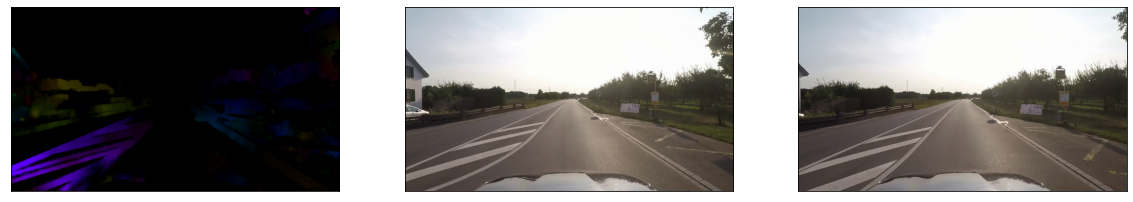

In [277]:
import matplotlib.image as mpimg
img1 = mpimg.imread(valid_data.iloc[1636]['image_path'])
img2 = mpimg.imread(valid_data.iloc[1637]['image_path'])


for i in range(10):
    rgb_diff = opticalFlowDense(img1,img2)
    if (np.average(rgb_diff) != 0):
        break
    

    
print(valid_data.iloc[1636]['image_path'])
print(valid_data.iloc[1637]['image_path'])
print(f'Optical flow avg: {np.average(rgb_diff)}')


plt.figure(1, figsize=(20,10))

plt.subplot(2,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(rgb_diff)
plt.savefig('optflow.jpg')

plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(img1)

plt.subplot(2,3,3)
plt.xticks([])
plt.yticks([])
plt.imshow(img2)